<a href="https://colab.research.google.com/github/cjjohanson/GW_GAN/blob/main/GW_GAN_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.autograd.variable import Variable
import torch.optim as optim
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
# use GPU if available and check cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    cuda = True
    print("Number of GPU's: ", torch.cuda.device_count())
    print("GPU name: ", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    cuda = False
    print("No GPU found !")

Number of GPU's:  1
GPU name:  NVIDIA A100-SXM4-40GB


In [3]:
# parameters for the size of the training sets

# how many samples in training data
train_data_length = 1024
# how many samples in each piece of training data
sample_rate = 1024
# how big each batch is
batch_size = 32

In [4]:
# create gaussian pulse training data (i.e., "real" data)

def gaussianpulse(sample_rate,n_signals):
    '''
    Returns an numpy array where n_signals is the
    number of signals and sample_rate is how many
    numbers are sampled within a given signal.
    '''
    t = np.linspace(0,1,sample_rate)
    t_0 =  np.random.uniform(0.4,0.6,n_signals)
    tau = np.random.uniform(1.0/100.0,1.0/20.0,n_signals)
    t_0 = np.expand_dims(t_0,axis = 1)
    tau = np.expand_dims(tau,axis = 1)
    h_1 = np.exp(-(t-t_0)**2/(tau**2))
    return torch.tensor(h_1)

# generate the data
gaussian_pulse_training_data = gaussianpulse(sample_rate, train_data_length)
gaussian_pulse_training_data = gaussian_pulse_training_data.to(device)

gaussian_pulse_train_set = [
    gaussian_pulse_training_data[i] for i in range(train_data_length)
]

# load the training data into DataLoader object
gaussian_pulse_train_loader = torch.utils.data.DataLoader(
    gaussian_pulse_train_set, batch_size=batch_size, shuffle=True
)

In [5]:
# create sine wave training data (i.e., "real" data)

def sine_wave(num_samples, sampling_rate, duration):
  """
  Creates a matrix of different sine waves bound by a frequence multiplier of
  4 to 4.25 and a vertical shift between -0.5 and 0.5

  num_samples: number of samples to create
  sampling_rate: the number of samples for a given observation
  duration: how long the observation lasts (in seconds)

  """
  # represents time series
  time_points = np.arange(0, duration, 2/sampling_rate)
  # matrix of zero for broadcasting
  zero_matrix = np.zeros((num_samples, sampling_rate))
  # full matrix with (num_samples X sampling_rate) matrix where each row is
  # a time series of 0 to 2 seconds sampling_rate samples
  full_matrix = time_points + zero_matrix

  # create an array of values to alter the frequency
  phase_multiplier = np.random.uniform(low=4, high=4.5, size=(num_samples, 1))
  # create an array of values to vertically shift the waves
  shift = np.random.uniform(low=-0.5, high=0.5, size=(num_samples, 1))

  # combine all parts to make final matrix
  final_matrix = np.sin(phase_multiplier * full_matrix * np.pi) + shift

  return final_matrix


# generate the data
sine_wave_training_data = sine_wave(num_samples=train_data_length,
                                    sampling_rate=sample_rate, duration=2)
sine_wave_training_data = sine_wave_training_data.to(device)

sine_wave_train_set = [
    sine_wave_training_data[i] for i in range(train_data_length)
]

# load the training data into DataLoader object
sine_wave_train_loader = torch.utils.data.DataLoader(
    sine_wave_train_set, batch_size=batch_size, shuffle=True
)

In [ ]:
# print out model architecture to text file for presentation

def write_model_architecture_to_file(model, file_name):
  '''
  Prints model architecture to text file, first deletes file if it exists
  to avoid appending

  model: PyTorch model
  file_name: text file to send the model architecture to
  file_dir: directory where the text file should be stored
  '''
  if file_name:
    os.remove(file_name)

  print(model, file=open(file_name, 'w'))

In [6]:
class GenerativeNet(torch.nn.Module):
	"""
	Class for the generator network for the CTGAN, implemented as a :class:`~torch:torch.nn.Module`. It is composed by a fully connected convolutional neural network.
	"""
	def __init__(self, num_features, latent_size):
		super(GenerativeNet, self).__init__()
		self.main = nn.Sequential(
            nn.ConvTranspose1d(in_channels=latent_size, 
															out_channels=num_features*32, kernel_size=58, 
															stride=1, padding=0),
            nn.BatchNorm1d(num_features*32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose1d(in_channels=num_features*32, 
															out_channels=num_features*16, kernel_size=4, 
															stride=1, padding=0),
            nn.BatchNorm1d(num_features*16),
            nn.LeakyReLU(0.2, inplace=True),


            nn.ConvTranspose1d(in_channels=num_features*16, 
															out_channels=num_features*8, kernel_size=4, 
															stride=1, padding=0),
            nn.BatchNorm1d(num_features*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose1d(in_channels=num_features*8, 
                               out_channels=num_features*4, kernel_size=4, 
                               stride=2, padding=1),
            nn.BatchNorm1d(num_features*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose1d(in_channels=num_features*4, 
                               out_channels=num_features*2, kernel_size=4, 
                               stride=2, padding=1),
            nn.BatchNorm1d(num_features*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose1d(in_channels=num_features*2, 
                               out_channels=num_features, kernel_size=4, 
                               stride=2, padding=1),
            nn.BatchNorm1d(num_features),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose1d(in_channels=num_features, out_channels=1, 
                               kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

	def forward(self, x):
		"""
		Given a stretch of random noise, it transforms it into a glitch
		"""
		return self.main(x)


In [7]:
# THIS IS THE DISCRIMINATOR FROM GENGLI

################################
#   Create the Discriminator   #
################################


class DiscriminativeNet(torch.nn.Module):
	"""
	Class for the discriminator network for the CTGAN, implemented as a :class:`~torch:torch.nn`. It is composed by a fully connected convolutional neural network.
	"""
	
	def __init__(self, dropout_rate, num_features, batch_size):

		super(DiscriminativeNet, self).__init__()

		self.batch_size = batch_size

		self.conv1 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=1, out_channels=num_features,
					   kernel_size=5, stride=2, padding=1, bias=False)),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv2 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_features, out_channels=num_features*2,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv3 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_features*2,
					   out_channels=num_features*4,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv4 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_features*4,
					   out_channels=num_features*8,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv5 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_features*8,
					   out_channels=num_features*16,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv6 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_features*16,
					   out_channels=num_features*32,
					   kernel_size=5, stride=2, padding=0, bias=False)),
			nn.Dropout(p=dropout_rate, inplace=True),
			nn.LeakyReLU(0.2, inplace=True))
		self.conv7 = nn.Sequential(
			nn.utils.spectral_norm
			(nn.Conv1d(in_channels=num_features*32,
					   out_channels=1, kernel_size=13,
					   stride=2, padding=0, bias=False)),
			nn.Flatten())

	def forward(self, x):
		"""
		Given a time series, it returns a classification score of whether the input is real or fake.
		"""
		x = self.conv1(x)
		x = self.conv2(x)
		x = self.conv3(x)
		x = self.conv4(x)
		x = self.conv5(x)
		x_ = self.conv6(x)
		x = self.conv7(x_)
		x_ = x_.view(self.batch_size, -1)

		return x, x_


In [8]:
######################################################
#   Weights initialization called on netG and netD   #
######################################################


def init_weights(m):

	classname = m.__class__.__name__

	if classname.find('Conv') != -1:
		m.weight.data.normal_(0.00, 0.02)

	elif classname.find('BatchNorm') != -1:
		m.weight.data.normal_(1.00, 0.02)


def init_weights2(m):

	classname = m.__class__.__name__

	if classname.find('Conv') != -1:  # or classname.find('BatchNorm') != -1:
		m.weight.data.normal_(0.00, 0.02)
	elif classname.find('LayerNorm') != -1:
		m.weight.data.normal_(1.00, 0.02)


In [9]:
############################
#   Training information   #
############################

# Number of training epochs
num_epochs = 500

# Number of iterations of the Discriminator per iteration of the Generator
ncycles_D = 5

# Loss weight for the gradient penalty
lambda_gp = 5

# Consistency term parameters
lambda_ct = 5
M = 0.1

# Learning rate for optimizers
lr_D = 0.0001
lr_G = 0.0001

# # Number of features/channels
num_features = 64

# Dropout rate
dropout_rate = 0.6

# Length random vector
length_noise = 100

# # Create fixed noise to generate glitches if safety_glitch == True
# fixed_noise = torch.randn((batch_size, 1, length_noise), device=device)
# Create fixed noise to generate glitches if safety_glitch == True
fixed_noise = torch.randn((batch_size, length_noise, 1), device=device)

# Parameters of rROF
tol = 0.0000001
lam = 0.5
beta = 1
h = 1
params = [h, beta, lam, tol]

# Create a fixed glitch for sanity check:
safety_glitch = True

# Save CTGAN state
save_state = False

# Store losses
store_loss = False

# directory to save training outputs
save_dir = '/content/gdrive/MyDrive/GAN/'


In [10]:
# set up the generator and discriminator for gaussian pulse
gen_gaussian = GenerativeNet(num_features=num_features, 
                    latent_size=length_noise).to(device)
gen_gaussian.apply(init_weights)
# print out model architecture to file for presentation
# only do this once for any generator and once for any discriminator
# because all of the models below use the same architecture
file_name = 'gen_architecture.txt'
write_model_architecture_to_file(model=gen_gaussian, file_name=file_name)

disc_gaussian = DiscriminativeNet(dropout_rate=dropout_rate, num_features=num_features, 
                         batch_size=batch_size).to(device)
disc_gaussian.apply(init_weights2)
file_name = 'disc_architecture.txt'
write_model_architecture_to_file(model=disc_gaussian, file_name=file_name)


# set up the generator and discriminator for sine wave
gen_sine = GenerativeNet(num_features=num_features, 
                    latent_size=length_noise).to(device)
gen_sine.apply(init_weights)

disc_sine = DiscriminativeNet(dropout_rate=dropout_rate, num_features=num_features, 
                         batch_size=batch_size).to(device)
disc_sine.apply(init_weights2)


DiscriminativeNet(
  (conv1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv1d(256, 512, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Sequential(
    (0): Conv1d(512, 1024, kernel_size=(5,), stride=(2,), bias=False)
    (1): Dropout(p=0.6, inplace=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv6): Sequential(
    (0): Conv1d(1024, 2048, kernel_size=(5,), stri

In [11]:
#####################
#   Training Loop   #
#####################

if torch.cuda.is_available():
	cuda = True
else:
	cuda = False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def training_loop(num_epochs, data_loader, ncycles_D, lambda_gp,
				  lambda_ct, M, batch_size, length_noise, device, netD,
				  netG, lr_D, lr_G, fixed_noise, safety_glitch, 
					training_performance_dict, save_dir=None, save_file_name=None,
					safety_glitch_file_name=None):
	"""
	Training and validation loops for CTGAN.
	
	Parameters
	----------
	num_epochs: int
		number of training epochs
	data_loader: torch.utils.data.DataLoader
		Torch data loader holding the training data
	ncycles_D: int
		Number of iterations of the Discriminator per iteration of the Generator
	lambda_gp: float
		Gradient Penalty (GP) parameter
	lambda_ct: float
		Consistency Term (CT) parameter
	M: float
		Constant parameter involved in the computation of the Consistency Term (CT). Recommended values are between 0 and 0.2.
	batch_size: int 
		Number of batches for each iteration
	length_noise: int 
		Size of the noise vector
	device: torch.device
		Torch device object. It is recommended to initialize it with a GPU
	netD: gengli.ctgan.DiscriminativeNet
		Discriminator network
	netG: gengli.ctgan.GenerativeNet
		Generator network
	lr_D: float 
		Learning rate for the discriminator
	lr_G: float
		Learning rate for the generator
	fixed_noise: torch.tensor
		Tensor holding fixed noise for sanity check
	safety_glitch: bool
		Sanity check for model. We create fixed noise to generate glitches if True.
	training_performance_dict: dictionary
		Dictionary used to store training performance data to be plotted later
	save_dir: str
		Directory where the training performance data will be saved to
	save_file_name: str
		File name where the training performance data will be saved to
	safety_glitch_file_name:
		File name where the safety glitches are save in a numpy file
	"""

	
	# create numpy array to save safety glitch outputs
	safety_glitch_output_data = list()

	# Set optimizer
	optimizerD = optim.RMSprop(netD.parameters(), lr=lr_D)
	optimizerG = optim.RMSprop(netG.parameters(), lr=lr_G)

	# Lists to keep track of progress
	G_losses = list()
	D_losses = list()
	D_real_losses = list()
	D_fake_losses = list()
	D_gp_losses = list()
	D_ct_losses = list()

	# Training loop, loops on epochs

	for epoch in tqdm(range(num_epochs), desc = 'CT-GAN training loop'):

		iters = 0
		timer_start = time.time()

		# For each batch in the data
		for batch_real in data_loader:

			# Iterate ncycles_D times over the Discriminator
			for j in np.arange(ncycles_D):

				# (1) Update D network  #

				# Train with all-real batch
				# Zeroing the gradients
				netD.zero_grad()
				# Real batch generation
				data_real = batch_real.view(batch_size, 1, -1)
				data_real = data_real.to(device)
				data_real = data_real.float()  #casting to float #FIXME: is this ok also for GPU?
				# Forward pass real batch through D
				D_real, D_real_ = netD(data_real)
				D_real = D_real.view(-1)
				# Calculate loss on all-real batch
				errD_real = torch.mean(D_real)

				# Train with all-fake batch
				# Generate batch of latent vectors
				noise = torch.randn((batch_size, length_noise, 1),
									device=device)
				# Generate fake image batch with G
				data_fake = netG(noise)
				# Classify all fake batch with D
				D_fake, D_fake_ = netD(data_fake)
				D_fake = D_fake.view(-1)
				# Calculate D's loss on the all-fake batch
				errD_fake = torch.mean(D_fake)

				# Compute gradient penalty
				GP = compute_gradient_penalty(netD, data_real, data_fake)

				# Compute consistency term
				CT = compute_consistency_term(netD, data_real, M)

				# Add the gradients from the all-real and all-fake
				# batches + gradient penalty
				errD = -errD_real + errD_fake + lambda_gp*GP + lambda_ct*CT

				# Backward propagation of total loss and Update D
				errD.backward()
				optimizerD.step()

			#########################
			# (2) Update G network  #
			#########################
			# Zeroing the gradients
			netG.zero_grad()
			# Creating noise
			noise2 = torch.randn((batch_size, length_noise, 1), device=device)
			# Forward pass through G
			fake2 = netG(noise2)
			# Since we updated D, perform a forward pass of
			# all-fake batch through D
			output, output_ = netD(fake2)
			output = output.view(-1)
			# Calculate G's loss based on this output
			errG = -torch.mean(output)
			# Backward propagation of the loss and Update G
			errG.backward()
			optimizerG.step()

			# Save Losses for plotting later
			G_losses.append(errG.item())
			D_losses.append(errD.item())
			D_real_losses.append(-errD_real.item())
			D_fake_losses.append(errD_fake.item())
			D_gp_losses.append(lambda_gp*GP.item())
			D_ct_losses.append(lambda_ct*CT.item())

			iters += 1

		# Output training stats
		begin = epoch*len(data_loader)
		end = (epoch+1)*len(data_loader)
		error_D = np.mean(D_losses[begin:end])
		error_G = np.mean(G_losses[begin:end])
		error_D_real = np.mean(D_real_losses[begin:end])
		error_D_fake = np.mean(D_fake_losses[begin:end])
		error_D_gp = np.mean(D_gp_losses[begin:end])
		error_D_ct = np.mean(D_ct_losses[begin:end])
		timer_end = time.time()

		print('[%d/%d] Loss_D: %.3f | Loss_G: %.3f | Loss D real : %.3f | Loss D fake : %.3f | Loss D GP : %.3f | Loss D CT : %.3f | Time : %.3f' % (epoch+1, num_epochs, error_D, error_G, error_D_real, error_D_fake, error_D_gp, error_D_ct, np.mean(timer_end-timer_start)))

		# Add performance data to training performance dictionary
		training_performance_dict[epoch] = dict(
				discriminator_error = error_D,
				generator_error = error_G,
				discriminator_error_real = error_D_real,
				discriminator_error_fake = error_D_fake,
				discriminator_error_gp = error_D_gp,
				discriminator_error_ct = error_D_ct
		)

		# use the safety glitch as a constant point of comparison to check the
		# training across epochs
		if safety_glitch:
			fake = netG(fixed_noise).detach().cpu().numpy()
			# training_performance_dict[epoch]['safety_glitch_output'] = fake
			safety_glitch_output_data.append(fake)

	# save this data to a json file and put said json in folder for later 
	# analysis
	if save_dir != None and save_file_name != None:
		with open(save_dir + save_file_name, 'w') as f:
			json.dump(training_performance_dict, f)
			f.close()
	 
	if safety_glitch_file_name:
		np.asarray(safety_glitch_output_data)
		np.save(save_dir + safety_glitch_file_name, safety_glitch_output_data)


def compute_gradient_penalty(D, real_samples, fake_samples):
	"""
		Function that computes gradient penalty.

	Parameters
	-----------
	D: gengli.ctgan.DiscriminativeNet
		Discriminator network
	real_samples: torch.tensor
		Batch of samples taken from the real glitches
	fake_samples: torch.tensor
		Batch of samples generated by the Generator network

	Returns
	-------
	gradient_penalty: float
		Gradient penalty (GP) term from the Discriminator loss

	"""
	# Random weight term for interpolation between real and fake samples
	alpha = Tensor(np.random.uniform(0, 1, (real_samples.size(0), 1, 1)))

	# Get random interpolation between real and fake samples
	interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
	interpolates = interpolates.requires_grad_(True)

	d_interpolates, d_interpolates_ = D(interpolates)
	fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0),
					requires_grad=False)

	# Get gradient w.r.t. interpolates
	gradients = torch.autograd.grad(outputs=d_interpolates,
									inputs=interpolates,
									grad_outputs=fake,
									create_graph=True,
									retain_graph=True,
									only_inputs=True)[0]

	gradients = gradients.view(gradients.size(0), -1)

	gradient_penalty = ((gradients.norm(2, dim=1) - 1)**2).mean()

	return gradient_penalty


def compute_consistency_term(D, real_data, M):
	"""

	Parameters
	----------
	D: gengli.ctgan.DiscriminativeNet
		Discriminator network
	real_data: torch.tensor
		Batch of samples taken from the real glitches
	M: float
		Constant parameter involved in the computation of the Consistency Term (CT). Recommended values are between 0 and 0.2.

	Returns
	-------
	consistency_term: float
		Consistency Term (CT) from the Discriminator loss

	"""
	d1, d_1 = D(real_data)
	d2, d_2 = D(real_data)

	first_term = (d1 - d2).norm(2, dim=1)
	second_term = (d_1 - d_2).norm(2, dim=1)

	consistency_term = first_term + 0.1 * second_term - M

	for i, item in enumerate(consistency_term):

		if (item < 0):
			consistency_term[i] = 0
	mean_consistency_term = consistency_term.mean()

	return mean_consistency_term


In [12]:
# training with gaussian pulse data

# Dictionary to store training performance data
gaussian_pulse_training_performance_dict = dict()

# file name to save the dictionary to
save_file_name_gaussian = 'gaussian_gan_training.json'

# file name to save safety glitch outputs to
safety_glitch_file_name_gaussian = 'gaussian_safety_glitches.npy'

training_loop(num_epochs=num_epochs, 
              data_loader=gaussian_pulse_train_loader,
              ncycles_D=ncycles_D, 
              lambda_gp=lambda_gp, 
              lambda_ct=lambda_ct,
              M=M, 
              batch_size=batch_size, 
              length_noise=length_noise,
              device=device, 
              netD=disc_gaussian, 
              netG=gen_gaussian, 
              lr_D=lr_D, 
              lr_G=lr_G, 
              fixed_noise=fixed_noise, 
              safety_glitch=safety_glitch,
              training_performance_dict=gaussian_pulse_training_performance_dict,
              save_dir=save_dir,
              save_file_name=save_file_name_gaussian,
              safety_glitch_file_name=safety_glitch_file_name_gaussian
              )

CT-GAN training loop:   0%|          | 1/500 [00:10<1:30:10, 10.84s/it]

[1/500] Loss_D: -0.822 | Loss_G: 1.795 | Loss D real : 0.068 | Loss D fake : -1.411 | Loss D GP : 0.501 | Loss D CT : 0.019 | Time : 10.840


CT-GAN training loop:   0%|          | 2/500 [00:14<53:12,  6.41s/it]  

[2/500] Loss_D: -0.568 | Loss_G: 0.626 | Loss D real : 0.003 | Loss D fake : -0.667 | Loss D GP : 0.063 | Loss D CT : 0.034 | Time : 3.305


CT-GAN training loop:   1%|          | 3/500 [00:17<41:27,  5.01s/it]

[3/500] Loss_D: -0.405 | Loss_G: 0.431 | Loss D real : -0.047 | Loss D fake : -0.441 | Loss D GP : 0.034 | Loss D CT : 0.049 | Time : 3.331


CT-GAN training loop:   1%|          | 4/500 [00:20<35:40,  4.32s/it]

[4/500] Loss_D: -0.460 | Loss_G: 0.494 | Loss D real : -0.071 | Loss D fake : -0.473 | Loss D GP : 0.041 | Loss D CT : 0.042 | Time : 3.253


CT-GAN training loop:   1%|          | 5/500 [00:24<32:27,  3.94s/it]

[5/500] Loss_D: -0.503 | Loss_G: 0.539 | Loss D real : -0.080 | Loss D fake : -0.539 | Loss D GP : 0.064 | Loss D CT : 0.053 | Time : 3.257


CT-GAN training loop:   1%|          | 6/500 [00:27<30:36,  3.72s/it]

[6/500] Loss_D: -0.487 | Loss_G: 0.492 | Loss D real : -0.079 | Loss D fake : -0.487 | Loss D GP : 0.054 | Loss D CT : 0.026 | Time : 3.294


CT-GAN training loop:   1%|▏         | 7/500 [00:30<29:32,  3.60s/it]

[7/500] Loss_D: -0.325 | Loss_G: 0.330 | Loss D real : -0.055 | Loss D fake : -0.328 | Loss D GP : 0.045 | Loss D CT : 0.013 | Time : 3.338


CT-GAN training loop:   2%|▏         | 8/500 [00:33<28:49,  3.52s/it]

[8/500] Loss_D: -0.164 | Loss_G: 0.195 | Loss D real : 0.002 | Loss D fake : -0.204 | Loss D GP : 0.031 | Loss D CT : 0.006 | Time : 3.342


CT-GAN training loop:   2%|▏         | 9/500 [00:37<28:18,  3.46s/it]

[9/500] Loss_D: -0.109 | Loss_G: 0.139 | Loss D real : -0.001 | Loss D fake : -0.139 | Loss D GP : 0.027 | Loss D CT : 0.005 | Time : 3.334


CT-GAN training loop:   2%|▏         | 10/500 [00:40<27:57,  3.42s/it]

[10/500] Loss_D: -0.099 | Loss_G: 0.075 | Loss D real : -0.059 | Loss D fake : -0.080 | Loss D GP : 0.031 | Loss D CT : 0.010 | Time : 3.339


CT-GAN training loop:   2%|▏         | 11/500 [00:43<27:37,  3.39s/it]

[11/500] Loss_D: -0.166 | Loss_G: 0.115 | Loss D real : -0.113 | Loss D fake : -0.118 | Loss D GP : 0.049 | Loss D CT : 0.016 | Time : 3.310


CT-GAN training loop:   2%|▏         | 12/500 [00:47<27:22,  3.37s/it]

[12/500] Loss_D: -0.169 | Loss_G: 0.110 | Loss D real : -0.136 | Loss D fake : -0.101 | Loss D GP : 0.060 | Loss D CT : 0.007 | Time : 3.310


CT-GAN training loop:   3%|▎         | 13/500 [00:50<27:13,  3.35s/it]

[13/500] Loss_D: -0.167 | Loss_G: 0.064 | Loss D real : -0.157 | Loss D fake : -0.067 | Loss D GP : 0.045 | Loss D CT : 0.012 | Time : 3.320


CT-GAN training loop:   3%|▎         | 14/500 [00:53<27:10,  3.36s/it]

[14/500] Loss_D: -0.138 | Loss_G: 0.044 | Loss D real : -0.172 | Loss D fake : -0.033 | Loss D GP : 0.051 | Loss D CT : 0.016 | Time : 3.358


CT-GAN training loop:   3%|▎         | 15/500 [00:57<27:03,  3.35s/it]

[15/500] Loss_D: -0.148 | Loss_G: 0.031 | Loss D real : -0.171 | Loss D fake : -0.028 | Loss D GP : 0.036 | Loss D CT : 0.015 | Time : 3.325


CT-GAN training loop:   3%|▎         | 16/500 [01:00<26:59,  3.35s/it]

[16/500] Loss_D: -0.130 | Loss_G: 0.011 | Loss D real : -0.180 | Loss D fake : -0.004 | Loss D GP : 0.041 | Loss D CT : 0.012 | Time : 3.341


CT-GAN training loop:   3%|▎         | 17/500 [01:04<27:00,  3.35s/it]

[17/500] Loss_D: -0.117 | Loss_G: 0.010 | Loss D real : -0.175 | Loss D fake : 0.017 | Loss D GP : 0.024 | Loss D CT : 0.016 | Time : 3.369


CT-GAN training loop:   4%|▎         | 18/500 [01:07<26:57,  3.36s/it]

[18/500] Loss_D: -0.112 | Loss_G: 0.010 | Loss D real : -0.172 | Loss D fake : 0.015 | Loss D GP : 0.033 | Loss D CT : 0.012 | Time : 3.358


CT-GAN training loop:   4%|▍         | 19/500 [01:10<26:53,  3.35s/it]

[19/500] Loss_D: -0.095 | Loss_G: 0.001 | Loss D real : -0.139 | Loss D fake : 0.001 | Loss D GP : 0.033 | Loss D CT : 0.009 | Time : 3.342


CT-GAN training loop:   4%|▍         | 20/500 [01:14<26:47,  3.35s/it]

[20/500] Loss_D: -0.103 | Loss_G: 0.017 | Loss D real : -0.124 | Loss D fake : -0.003 | Loss D GP : 0.018 | Loss D CT : 0.006 | Time : 3.338


CT-GAN training loop:   4%|▍         | 21/500 [01:17<26:46,  3.35s/it]

[21/500] Loss_D: -0.086 | Loss_G: 0.016 | Loss D real : -0.090 | Loss D fake : -0.017 | Loss D GP : 0.019 | Loss D CT : 0.001 | Time : 3.357


CT-GAN training loop:   4%|▍         | 22/500 [01:20<26:43,  3.35s/it]

[22/500] Loss_D: -0.084 | Loss_G: 0.040 | Loss D real : -0.060 | Loss D fake : -0.044 | Loss D GP : 0.018 | Loss D CT : 0.001 | Time : 3.353


CT-GAN training loop:   5%|▍         | 23/500 [01:24<26:42,  3.36s/it]

[23/500] Loss_D: -0.085 | Loss_G: 0.046 | Loss D real : -0.044 | Loss D fake : -0.057 | Loss D GP : 0.015 | Loss D CT : 0.002 | Time : 3.371


CT-GAN training loop:   5%|▍         | 24/500 [01:27<26:31,  3.34s/it]

[24/500] Loss_D: -0.074 | Loss_G: 0.035 | Loss D real : -0.046 | Loss D fake : -0.046 | Loss D GP : 0.018 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:   5%|▌         | 25/500 [01:30<26:24,  3.34s/it]

[25/500] Loss_D: -0.071 | Loss_G: 0.036 | Loss D real : -0.048 | Loss D fake : -0.035 | Loss D GP : 0.013 | Loss D CT : 0.000 | Time : 3.320


CT-GAN training loop:   5%|▌         | 26/500 [01:34<26:15,  3.32s/it]

[26/500] Loss_D: -0.062 | Loss_G: 0.023 | Loss D real : -0.051 | Loss D fake : -0.027 | Loss D GP : 0.015 | Loss D CT : 0.001 | Time : 3.290


CT-GAN training loop:   5%|▌         | 27/500 [01:37<26:08,  3.32s/it]

[27/500] Loss_D: -0.056 | Loss_G: 0.025 | Loss D real : -0.053 | Loss D fake : -0.025 | Loss D GP : 0.022 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:   6%|▌         | 28/500 [01:40<25:59,  3.30s/it]

[28/500] Loss_D: -0.061 | Loss_G: 0.021 | Loss D real : -0.053 | Loss D fake : -0.024 | Loss D GP : 0.012 | Loss D CT : 0.004 | Time : 3.275


CT-GAN training loop:   6%|▌         | 29/500 [01:43<25:53,  3.30s/it]

[29/500] Loss_D: -0.062 | Loss_G: 0.028 | Loss D real : -0.042 | Loss D fake : -0.039 | Loss D GP : 0.018 | Loss D CT : 0.001 | Time : 3.281


CT-GAN training loop:   6%|▌         | 30/500 [01:47<25:48,  3.29s/it]

[30/500] Loss_D: -0.061 | Loss_G: 0.032 | Loss D real : -0.039 | Loss D fake : -0.037 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.284


CT-GAN training loop:   6%|▌         | 31/500 [01:50<25:45,  3.30s/it]

[31/500] Loss_D: -0.049 | Loss_G: 0.029 | Loss D real : -0.040 | Loss D fake : -0.028 | Loss D GP : 0.017 | Loss D CT : 0.002 | Time : 3.295


CT-GAN training loop:   6%|▋         | 32/500 [01:53<25:43,  3.30s/it]

[32/500] Loss_D: -0.060 | Loss_G: 0.039 | Loss D real : -0.036 | Loss D fake : -0.036 | Loss D GP : 0.009 | Loss D CT : 0.003 | Time : 3.299


CT-GAN training loop:   7%|▋         | 33/500 [01:57<25:36,  3.29s/it]

[33/500] Loss_D: -0.048 | Loss_G: 0.042 | Loss D real : -0.036 | Loss D fake : -0.037 | Loss D GP : 0.021 | Loss D CT : 0.003 | Time : 3.267


CT-GAN training loop:   7%|▋         | 34/500 [02:00<25:31,  3.29s/it]

[34/500] Loss_D: -0.056 | Loss_G: 0.025 | Loss D real : -0.042 | Loss D fake : -0.028 | Loss D GP : 0.011 | Loss D CT : 0.003 | Time : 3.279


CT-GAN training loop:   7%|▋         | 35/500 [02:03<25:30,  3.29s/it]

[35/500] Loss_D: -0.050 | Loss_G: 0.023 | Loss D real : -0.047 | Loss D fake : -0.022 | Loss D GP : 0.017 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:   7%|▋         | 36/500 [02:06<25:29,  3.30s/it]

[36/500] Loss_D: -0.050 | Loss_G: 0.013 | Loss D real : -0.050 | Loss D fake : -0.017 | Loss D GP : 0.015 | Loss D CT : 0.002 | Time : 3.309


CT-GAN training loop:   7%|▋         | 37/500 [02:10<25:26,  3.30s/it]

[37/500] Loss_D: -0.047 | Loss_G: 0.008 | Loss D real : -0.059 | Loss D fake : -0.004 | Loss D GP : 0.015 | Loss D CT : 0.002 | Time : 3.292


CT-GAN training loop:   8%|▊         | 38/500 [02:13<25:21,  3.29s/it]

[38/500] Loss_D: -0.049 | Loss_G: 0.002 | Loss D real : -0.065 | Loss D fake : 0.004 | Loss D GP : 0.009 | Loss D CT : 0.003 | Time : 3.279


CT-GAN training loop:   8%|▊         | 39/500 [02:16<25:17,  3.29s/it]

[39/500] Loss_D: -0.053 | Loss_G: -0.007 | Loss D real : -0.075 | Loss D fake : 0.009 | Loss D GP : 0.009 | Loss D CT : 0.003 | Time : 3.290


CT-GAN training loop:   8%|▊         | 40/500 [02:20<25:16,  3.30s/it]

[40/500] Loss_D: -0.048 | Loss_G: -0.018 | Loss D real : -0.077 | Loss D fake : 0.013 | Loss D GP : 0.013 | Loss D CT : 0.003 | Time : 3.304


CT-GAN training loop:   8%|▊         | 41/500 [02:23<25:13,  3.30s/it]

[41/500] Loss_D: -0.041 | Loss_G: -0.022 | Loss D real : -0.077 | Loss D fake : 0.016 | Loss D GP : 0.018 | Loss D CT : 0.002 | Time : 3.297


CT-GAN training loop:   8%|▊         | 42/500 [02:26<25:11,  3.30s/it]

[42/500] Loss_D: -0.047 | Loss_G: -0.025 | Loss D real : -0.086 | Loss D fake : 0.026 | Loss D GP : 0.011 | Loss D CT : 0.003 | Time : 3.299


CT-GAN training loop:   9%|▊         | 43/500 [02:30<25:05,  3.30s/it]

[43/500] Loss_D: -0.039 | Loss_G: -0.037 | Loss D real : -0.086 | Loss D fake : 0.029 | Loss D GP : 0.017 | Loss D CT : 0.001 | Time : 3.282


CT-GAN training loop:   9%|▉         | 44/500 [02:33<24:59,  3.29s/it]

[44/500] Loss_D: -0.038 | Loss_G: -0.032 | Loss D real : -0.091 | Loss D fake : 0.034 | Loss D GP : 0.017 | Loss D CT : 0.002 | Time : 3.272


CT-GAN training loop:   9%|▉         | 45/500 [02:36<24:53,  3.28s/it]

[45/500] Loss_D: -0.035 | Loss_G: -0.039 | Loss D real : -0.085 | Loss D fake : 0.032 | Loss D GP : 0.018 | Loss D CT : 0.001 | Time : 3.263


CT-GAN training loop:   9%|▉         | 46/500 [02:39<24:51,  3.28s/it]

[46/500] Loss_D: -0.039 | Loss_G: -0.031 | Loss D real : -0.080 | Loss D fake : 0.026 | Loss D GP : 0.015 | Loss D CT : 0.001 | Time : 3.285


CT-GAN training loop:   9%|▉         | 47/500 [02:43<24:50,  3.29s/it]

[47/500] Loss_D: -0.020 | Loss_G: -0.026 | Loss D real : -0.083 | Loss D fake : 0.032 | Loss D GP : 0.030 | Loss D CT : 0.002 | Time : 3.298


CT-GAN training loop:  10%|▉         | 48/500 [02:46<24:42,  3.28s/it]

[48/500] Loss_D: -0.045 | Loss_G: -0.028 | Loss D real : -0.092 | Loss D fake : 0.034 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.255


CT-GAN training loop:  10%|▉         | 49/500 [02:49<24:38,  3.28s/it]

[49/500] Loss_D: -0.038 | Loss_G: -0.030 | Loss D real : -0.090 | Loss D fake : 0.035 | Loss D GP : 0.015 | Loss D CT : 0.002 | Time : 3.268


CT-GAN training loop:  10%|█         | 50/500 [02:52<24:33,  3.27s/it]

[50/500] Loss_D: -0.041 | Loss_G: -0.031 | Loss D real : -0.087 | Loss D fake : 0.034 | Loss D GP : 0.010 | Loss D CT : 0.002 | Time : 3.266


CT-GAN training loop:  10%|█         | 51/500 [02:56<24:36,  3.29s/it]

[51/500] Loss_D: -0.032 | Loss_G: -0.026 | Loss D real : -0.078 | Loss D fake : 0.028 | Loss D GP : 0.017 | Loss D CT : 0.001 | Time : 3.314


CT-GAN training loop:  10%|█         | 52/500 [02:59<24:32,  3.29s/it]

[52/500] Loss_D: -0.040 | Loss_G: -0.026 | Loss D real : -0.080 | Loss D fake : 0.028 | Loss D GP : 0.010 | Loss D CT : 0.002 | Time : 3.285


CT-GAN training loop:  11%|█         | 53/500 [03:02<24:31,  3.29s/it]

[53/500] Loss_D: -0.032 | Loss_G: -0.028 | Loss D real : -0.082 | Loss D fake : 0.029 | Loss D GP : 0.018 | Loss D CT : 0.002 | Time : 3.298


CT-GAN training loop:  11%|█         | 54/500 [03:06<24:27,  3.29s/it]

[54/500] Loss_D: -0.035 | Loss_G: -0.030 | Loss D real : -0.072 | Loss D fake : 0.026 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.286


CT-GAN training loop:  11%|█         | 55/500 [03:09<24:28,  3.30s/it]

[55/500] Loss_D: -0.030 | Loss_G: -0.034 | Loss D real : -0.073 | Loss D fake : 0.025 | Loss D GP : 0.015 | Loss D CT : 0.002 | Time : 3.316


CT-GAN training loop:  11%|█         | 56/500 [03:12<24:25,  3.30s/it]

[56/500] Loss_D: -0.028 | Loss_G: -0.030 | Loss D real : -0.077 | Loss D fake : 0.031 | Loss D GP : 0.016 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  11%|█▏        | 57/500 [03:16<24:22,  3.30s/it]

[57/500] Loss_D: -0.034 | Loss_G: -0.030 | Loss D real : -0.074 | Loss D fake : 0.027 | Loss D GP : 0.010 | Loss D CT : 0.003 | Time : 3.296


CT-GAN training loop:  12%|█▏        | 58/500 [03:19<24:15,  3.29s/it]

[58/500] Loss_D: -0.038 | Loss_G: -0.035 | Loss D real : -0.074 | Loss D fake : 0.023 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.270


CT-GAN training loop:  12%|█▏        | 59/500 [03:22<24:13,  3.30s/it]

[59/500] Loss_D: -0.035 | Loss_G: -0.032 | Loss D real : -0.074 | Loss D fake : 0.024 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  12%|█▏        | 60/500 [03:25<24:11,  3.30s/it]

[60/500] Loss_D: -0.030 | Loss_G: -0.033 | Loss D real : -0.076 | Loss D fake : 0.033 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.300


CT-GAN training loop:  12%|█▏        | 61/500 [03:29<24:05,  3.29s/it]

[61/500] Loss_D: -0.038 | Loss_G: -0.037 | Loss D real : -0.074 | Loss D fake : 0.026 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.276


CT-GAN training loop:  12%|█▏        | 62/500 [03:32<24:04,  3.30s/it]

[62/500] Loss_D: -0.028 | Loss_G: -0.027 | Loss D real : -0.080 | Loss D fake : 0.033 | Loss D GP : 0.017 | Loss D CT : 0.002 | Time : 3.306


CT-GAN training loop:  13%|█▎        | 63/500 [03:35<24:01,  3.30s/it]

[63/500] Loss_D: -0.028 | Loss_G: -0.031 | Loss D real : -0.068 | Loss D fake : 0.024 | Loss D GP : 0.015 | Loss D CT : 0.002 | Time : 3.296


CT-GAN training loop:  13%|█▎        | 64/500 [03:39<23:54,  3.29s/it]

[64/500] Loss_D: -0.030 | Loss_G: -0.033 | Loss D real : -0.074 | Loss D fake : 0.029 | Loss D GP : 0.013 | Loss D CT : 0.002 | Time : 3.266


CT-GAN training loop:  13%|█▎        | 65/500 [03:42<23:49,  3.29s/it]

[65/500] Loss_D: -0.026 | Loss_G: -0.025 | Loss D real : -0.078 | Loss D fake : 0.035 | Loss D GP : 0.014 | Loss D CT : 0.003 | Time : 3.272


CT-GAN training loop:  13%|█▎        | 66/500 [03:45<23:45,  3.28s/it]

[66/500] Loss_D: -0.029 | Loss_G: -0.031 | Loss D real : -0.079 | Loss D fake : 0.036 | Loss D GP : 0.012 | Loss D CT : 0.002 | Time : 3.278


CT-GAN training loop:  13%|█▎        | 67/500 [03:48<23:41,  3.28s/it]

[67/500] Loss_D: -0.034 | Loss_G: -0.032 | Loss D real : -0.075 | Loss D fake : 0.032 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.274


CT-GAN training loop:  14%|█▎        | 68/500 [03:52<23:38,  3.28s/it]

[68/500] Loss_D: -0.024 | Loss_G: -0.038 | Loss D real : -0.081 | Loss D fake : 0.039 | Loss D GP : 0.017 | Loss D CT : 0.001 | Time : 3.279


CT-GAN training loop:  14%|█▍        | 69/500 [03:55<23:40,  3.30s/it]

[69/500] Loss_D: -0.029 | Loss_G: -0.033 | Loss D real : -0.069 | Loss D fake : 0.028 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.322


CT-GAN training loop:  14%|█▍        | 70/500 [03:58<23:39,  3.30s/it]

[70/500] Loss_D: -0.027 | Loss_G: -0.038 | Loss D real : -0.075 | Loss D fake : 0.031 | Loss D GP : 0.016 | Loss D CT : 0.001 | Time : 3.311


CT-GAN training loop:  14%|█▍        | 71/500 [04:02<23:36,  3.30s/it]

[71/500] Loss_D: -0.031 | Loss_G: -0.034 | Loss D real : -0.080 | Loss D fake : 0.036 | Loss D GP : 0.012 | Loss D CT : 0.002 | Time : 3.298


CT-GAN training loop:  14%|█▍        | 72/500 [04:05<23:31,  3.30s/it]

[72/500] Loss_D: -0.031 | Loss_G: -0.031 | Loss D real : -0.077 | Loss D fake : 0.035 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.288


CT-GAN training loop:  15%|█▍        | 73/500 [04:08<23:27,  3.30s/it]

[73/500] Loss_D: -0.027 | Loss_G: -0.032 | Loss D real : -0.078 | Loss D fake : 0.039 | Loss D GP : 0.010 | Loss D CT : 0.003 | Time : 3.286


CT-GAN training loop:  15%|█▍        | 74/500 [04:12<23:20,  3.29s/it]

[74/500] Loss_D: -0.018 | Loss_G: -0.041 | Loss D real : -0.068 | Loss D fake : 0.028 | Loss D GP : 0.021 | Loss D CT : 0.001 | Time : 3.269


CT-GAN training loop:  15%|█▌        | 75/500 [04:15<23:18,  3.29s/it]

[75/500] Loss_D: -0.032 | Loss_G: -0.036 | Loss D real : -0.076 | Loss D fake : 0.035 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  15%|█▌        | 76/500 [04:18<23:17,  3.30s/it]

[76/500] Loss_D: -0.028 | Loss_G: -0.035 | Loss D real : -0.073 | Loss D fake : 0.030 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.304


CT-GAN training loop:  15%|█▌        | 77/500 [04:21<23:14,  3.30s/it]

[77/500] Loss_D: -0.025 | Loss_G: -0.025 | Loss D real : -0.062 | Loss D fake : 0.025 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.293


CT-GAN training loop:  16%|█▌        | 78/500 [04:25<23:11,  3.30s/it]

[78/500] Loss_D: -0.026 | Loss_G: -0.032 | Loss D real : -0.068 | Loss D fake : 0.029 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:  16%|█▌        | 79/500 [04:28<23:09,  3.30s/it]

[79/500] Loss_D: -0.027 | Loss_G: -0.037 | Loss D real : -0.075 | Loss D fake : 0.036 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  16%|█▌        | 80/500 [04:31<23:08,  3.31s/it]

[80/500] Loss_D: -0.023 | Loss_G: -0.036 | Loss D real : -0.072 | Loss D fake : 0.035 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.316


CT-GAN training loop:  16%|█▌        | 81/500 [04:35<23:05,  3.31s/it]

[81/500] Loss_D: -0.027 | Loss_G: -0.036 | Loss D real : -0.077 | Loss D fake : 0.036 | Loss D GP : 0.012 | Loss D CT : 0.002 | Time : 3.299


CT-GAN training loop:  16%|█▋        | 82/500 [04:38<23:04,  3.31s/it]

[82/500] Loss_D: -0.027 | Loss_G: -0.032 | Loss D real : -0.075 | Loss D fake : 0.036 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.323


CT-GAN training loop:  17%|█▋        | 83/500 [04:41<22:59,  3.31s/it]

[83/500] Loss_D: -0.015 | Loss_G: -0.035 | Loss D real : -0.066 | Loss D fake : 0.026 | Loss D GP : 0.024 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  17%|█▋        | 84/500 [04:45<22:54,  3.30s/it]

[84/500] Loss_D: -0.028 | Loss_G: -0.038 | Loss D real : -0.066 | Loss D fake : 0.025 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  17%|█▋        | 85/500 [04:48<22:52,  3.31s/it]

[85/500] Loss_D: -0.026 | Loss_G: -0.036 | Loss D real : -0.067 | Loss D fake : 0.032 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.310


CT-GAN training loop:  17%|█▋        | 86/500 [04:51<22:49,  3.31s/it]

[86/500] Loss_D: -0.022 | Loss_G: -0.028 | Loss D real : -0.058 | Loss D fake : 0.023 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  17%|█▋        | 87/500 [04:55<22:44,  3.30s/it]

[87/500] Loss_D: -0.024 | Loss_G: -0.033 | Loss D real : -0.067 | Loss D fake : 0.033 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  18%|█▊        | 88/500 [04:58<22:41,  3.31s/it]

[88/500] Loss_D: -0.021 | Loss_G: -0.032 | Loss D real : -0.065 | Loss D fake : 0.029 | Loss D GP : 0.013 | Loss D CT : 0.002 | Time : 3.303


CT-GAN training loop:  18%|█▊        | 89/500 [05:01<22:36,  3.30s/it]

[89/500] Loss_D: -0.024 | Loss_G: -0.032 | Loss D real : -0.070 | Loss D fake : 0.034 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.286


CT-GAN training loop:  18%|█▊        | 90/500 [05:04<22:34,  3.30s/it]

[90/500] Loss_D: -0.016 | Loss_G: -0.031 | Loss D real : -0.060 | Loss D fake : 0.029 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.308


CT-GAN training loop:  18%|█▊        | 91/500 [05:08<22:30,  3.30s/it]

[91/500] Loss_D: -0.025 | Loss_G: -0.023 | Loss D real : -0.073 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.002 | Time : 3.295


CT-GAN training loop:  18%|█▊        | 92/500 [05:11<22:27,  3.30s/it]

[92/500] Loss_D: -0.024 | Loss_G: -0.025 | Loss D real : -0.066 | Loss D fake : 0.032 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  19%|█▊        | 93/500 [05:14<22:23,  3.30s/it]

[93/500] Loss_D: -0.022 | Loss_G: -0.040 | Loss D real : -0.070 | Loss D fake : 0.034 | Loss D GP : 0.012 | Loss D CT : 0.002 | Time : 3.295


CT-GAN training loop:  19%|█▉        | 94/500 [05:18<22:21,  3.31s/it]

[94/500] Loss_D: -0.024 | Loss_G: -0.033 | Loss D real : -0.073 | Loss D fake : 0.039 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.313


CT-GAN training loop:  19%|█▉        | 95/500 [05:21<22:19,  3.31s/it]

[95/500] Loss_D: -0.025 | Loss_G: -0.031 | Loss D real : -0.064 | Loss D fake : 0.030 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.308


CT-GAN training loop:  19%|█▉        | 96/500 [05:24<22:16,  3.31s/it]

[96/500] Loss_D: -0.020 | Loss_G: -0.032 | Loss D real : -0.065 | Loss D fake : 0.031 | Loss D GP : 0.013 | Loss D CT : 0.000 | Time : 3.311


CT-GAN training loop:  19%|█▉        | 97/500 [05:28<22:08,  3.30s/it]

[97/500] Loss_D: -0.021 | Loss_G: -0.038 | Loss D real : -0.058 | Loss D fake : 0.024 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.265


CT-GAN training loop:  20%|█▉        | 98/500 [05:31<22:04,  3.30s/it]

[98/500] Loss_D: -0.024 | Loss_G: -0.030 | Loss D real : -0.065 | Loss D fake : 0.031 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.288


CT-GAN training loop:  20%|█▉        | 99/500 [05:34<22:02,  3.30s/it]

[99/500] Loss_D: -0.022 | Loss_G: -0.024 | Loss D real : -0.069 | Loss D fake : 0.036 | Loss D GP : 0.010 | Loss D CT : 0.002 | Time : 3.302


CT-GAN training loop:  20%|██        | 100/500 [05:37<21:59,  3.30s/it]

[100/500] Loss_D: -0.023 | Loss_G: -0.033 | Loss D real : -0.058 | Loss D fake : 0.025 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.295


CT-GAN training loop:  20%|██        | 101/500 [05:41<21:54,  3.29s/it]

[101/500] Loss_D: -0.024 | Loss_G: -0.033 | Loss D real : -0.065 | Loss D fake : 0.030 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.281


CT-GAN training loop:  20%|██        | 102/500 [05:44<21:52,  3.30s/it]

[102/500] Loss_D: -0.022 | Loss_G: -0.030 | Loss D real : -0.068 | Loss D fake : 0.033 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.304


CT-GAN training loop:  21%|██        | 103/500 [05:47<21:51,  3.30s/it]

[103/500] Loss_D: -0.001 | Loss_G: -0.033 | Loss D real : -0.067 | Loss D fake : 0.035 | Loss D GP : 0.031 | Loss D CT : 0.001 | Time : 3.309


CT-GAN training loop:  21%|██        | 104/500 [05:51<21:46,  3.30s/it]

[104/500] Loss_D: -0.019 | Loss_G: -0.036 | Loss D real : -0.076 | Loss D fake : 0.043 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.288


CT-GAN training loop:  21%|██        | 105/500 [05:54<21:42,  3.30s/it]

[105/500] Loss_D: -0.024 | Loss_G: -0.040 | Loss D real : -0.068 | Loss D fake : 0.035 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.289


CT-GAN training loop:  21%|██        | 106/500 [05:57<21:39,  3.30s/it]

[106/500] Loss_D: -0.022 | Loss_G: -0.035 | Loss D real : -0.066 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:  21%|██▏       | 107/500 [06:01<21:34,  3.30s/it]

[107/500] Loss_D: -0.020 | Loss_G: -0.030 | Loss D real : -0.058 | Loss D fake : 0.027 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.283


CT-GAN training loop:  22%|██▏       | 108/500 [06:04<21:31,  3.29s/it]

[108/500] Loss_D: -0.021 | Loss_G: -0.034 | Loss D real : -0.066 | Loss D fake : 0.034 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.287


CT-GAN training loop:  22%|██▏       | 109/500 [06:07<21:28,  3.30s/it]

[109/500] Loss_D: -0.018 | Loss_G: -0.032 | Loss D real : -0.066 | Loss D fake : 0.036 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.299


CT-GAN training loop:  22%|██▏       | 110/500 [06:10<21:26,  3.30s/it]

[110/500] Loss_D: -0.017 | Loss_G: -0.036 | Loss D real : -0.070 | Loss D fake : 0.038 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  22%|██▏       | 111/500 [06:14<21:24,  3.30s/it]

[111/500] Loss_D: -0.019 | Loss_G: -0.033 | Loss D real : -0.065 | Loss D fake : 0.034 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  22%|██▏       | 112/500 [06:17<21:20,  3.30s/it]

[112/500] Loss_D: -0.020 | Loss_G: -0.033 | Loss D real : -0.062 | Loss D fake : 0.032 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  23%|██▎       | 113/500 [06:20<21:18,  3.30s/it]

[113/500] Loss_D: -0.014 | Loss_G: -0.040 | Loss D real : -0.074 | Loss D fake : 0.042 | Loss D GP : 0.016 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  23%|██▎       | 114/500 [06:24<21:15,  3.31s/it]

[114/500] Loss_D: -0.020 | Loss_G: -0.038 | Loss D real : -0.070 | Loss D fake : 0.041 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.308


CT-GAN training loop:  23%|██▎       | 115/500 [06:27<21:12,  3.31s/it]

[115/500] Loss_D: -0.019 | Loss_G: -0.033 | Loss D real : -0.065 | Loss D fake : 0.035 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  23%|██▎       | 116/500 [06:30<21:08,  3.30s/it]

[116/500] Loss_D: -0.015 | Loss_G: -0.037 | Loss D real : -0.070 | Loss D fake : 0.041 | Loss D GP : 0.012 | Loss D CT : 0.002 | Time : 3.292


CT-GAN training loop:  23%|██▎       | 117/500 [06:34<21:04,  3.30s/it]

[117/500] Loss_D: -0.023 | Loss_G: -0.039 | Loss D real : -0.062 | Loss D fake : 0.030 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  24%|██▎       | 118/500 [06:37<21:03,  3.31s/it]

[118/500] Loss_D: -0.015 | Loss_G: -0.032 | Loss D real : -0.067 | Loss D fake : 0.037 | Loss D GP : 0.014 | Loss D CT : 0.002 | Time : 3.323


CT-GAN training loop:  24%|██▍       | 119/500 [06:40<21:01,  3.31s/it]

[119/500] Loss_D: -0.017 | Loss_G: -0.031 | Loss D real : -0.062 | Loss D fake : 0.032 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.314


CT-GAN training loop:  24%|██▍       | 120/500 [06:43<20:58,  3.31s/it]

[120/500] Loss_D: -0.019 | Loss_G: -0.042 | Loss D real : -0.071 | Loss D fake : 0.042 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.312


CT-GAN training loop:  24%|██▍       | 121/500 [06:47<20:54,  3.31s/it]

[121/500] Loss_D: -0.015 | Loss_G: -0.044 | Loss D real : -0.066 | Loss D fake : 0.035 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  24%|██▍       | 122/500 [06:50<20:50,  3.31s/it]

[122/500] Loss_D: -0.016 | Loss_G: -0.035 | Loss D real : -0.063 | Loss D fake : 0.034 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.299


CT-GAN training loop:  25%|██▍       | 123/500 [06:53<20:46,  3.31s/it]

[123/500] Loss_D: -0.015 | Loss_G: -0.038 | Loss D real : -0.058 | Loss D fake : 0.030 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  25%|██▍       | 124/500 [06:57<20:42,  3.30s/it]

[124/500] Loss_D: -0.018 | Loss_G: -0.038 | Loss D real : -0.066 | Loss D fake : 0.037 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  25%|██▌       | 125/500 [07:00<20:40,  3.31s/it]

[125/500] Loss_D: -0.013 | Loss_G: -0.035 | Loss D real : -0.065 | Loss D fake : 0.037 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.308


CT-GAN training loop:  25%|██▌       | 126/500 [07:03<20:37,  3.31s/it]

[126/500] Loss_D: -0.019 | Loss_G: -0.032 | Loss D real : -0.068 | Loss D fake : 0.038 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.309


CT-GAN training loop:  25%|██▌       | 127/500 [07:07<20:37,  3.32s/it]

[127/500] Loss_D: -0.017 | Loss_G: -0.028 | Loss D real : -0.054 | Loss D fake : 0.028 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.337


CT-GAN training loop:  26%|██▌       | 128/500 [07:10<20:34,  3.32s/it]

[128/500] Loss_D: -0.014 | Loss_G: -0.037 | Loss D real : -0.062 | Loss D fake : 0.034 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.314


CT-GAN training loop:  26%|██▌       | 129/500 [07:13<20:34,  3.33s/it]

[129/500] Loss_D: -0.013 | Loss_G: -0.031 | Loss D real : -0.060 | Loss D fake : 0.033 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.342


CT-GAN training loop:  26%|██▌       | 130/500 [07:17<20:27,  3.32s/it]

[130/500] Loss_D: -0.015 | Loss_G: -0.028 | Loss D real : -0.063 | Loss D fake : 0.037 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.290


CT-GAN training loop:  26%|██▌       | 131/500 [07:20<20:21,  3.31s/it]

[131/500] Loss_D: -0.016 | Loss_G: -0.041 | Loss D real : -0.070 | Loss D fake : 0.043 | Loss D GP : 0.010 | Loss D CT : 0.002 | Time : 3.289


CT-GAN training loop:  26%|██▋       | 132/500 [07:23<20:16,  3.31s/it]

[132/500] Loss_D: -0.015 | Loss_G: -0.039 | Loss D real : -0.073 | Loss D fake : 0.044 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:  27%|██▋       | 133/500 [07:27<20:15,  3.31s/it]

[133/500] Loss_D: -0.015 | Loss_G: -0.031 | Loss D real : -0.063 | Loss D fake : 0.035 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.318


CT-GAN training loop:  27%|██▋       | 134/500 [07:30<20:12,  3.31s/it]

[134/500] Loss_D: -0.018 | Loss_G: -0.037 | Loss D real : -0.066 | Loss D fake : 0.040 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.311


CT-GAN training loop:  27%|██▋       | 135/500 [07:33<20:04,  3.30s/it]

[135/500] Loss_D: -0.013 | Loss_G: -0.035 | Loss D real : -0.066 | Loss D fake : 0.039 | Loss D GP : 0.014 | Loss D CT : 0.001 | Time : 3.272


CT-GAN training loop:  27%|██▋       | 136/500 [07:36<20:02,  3.30s/it]

[136/500] Loss_D: -0.019 | Loss_G: -0.044 | Loss D real : -0.062 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.305


CT-GAN training loop:  27%|██▋       | 137/500 [07:40<19:59,  3.31s/it]

[137/500] Loss_D: -0.019 | Loss_G: -0.039 | Loss D real : -0.068 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  28%|██▊       | 138/500 [07:43<19:54,  3.30s/it]

[138/500] Loss_D: -0.009 | Loss_G: -0.038 | Loss D real : -0.059 | Loss D fake : 0.031 | Loss D GP : 0.019 | Loss D CT : 0.000 | Time : 3.287


CT-GAN training loop:  28%|██▊       | 139/500 [07:46<19:48,  3.29s/it]

[139/500] Loss_D: -0.020 | Loss_G: -0.044 | Loss D real : -0.072 | Loss D fake : 0.042 | Loss D GP : 0.009 | Loss D CT : 0.002 | Time : 3.273


CT-GAN training loop:  28%|██▊       | 140/500 [07:50<19:46,  3.30s/it]

[140/500] Loss_D: -0.012 | Loss_G: -0.033 | Loss D real : -0.063 | Loss D fake : 0.037 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  28%|██▊       | 141/500 [07:53<19:40,  3.29s/it]

[141/500] Loss_D: -0.021 | Loss_G: -0.041 | Loss D real : -0.066 | Loss D fake : 0.035 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.267


CT-GAN training loop:  28%|██▊       | 142/500 [07:56<19:38,  3.29s/it]

[142/500] Loss_D: -0.010 | Loss_G: -0.039 | Loss D real : -0.067 | Loss D fake : 0.041 | Loss D GP : 0.015 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  29%|██▊       | 143/500 [07:59<19:36,  3.30s/it]

[143/500] Loss_D: -0.018 | Loss_G: -0.041 | Loss D real : -0.063 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  29%|██▉       | 144/500 [08:03<19:32,  3.29s/it]

[144/500] Loss_D: -0.013 | Loss_G: -0.039 | Loss D real : -0.060 | Loss D fake : 0.034 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.287


CT-GAN training loop:  29%|██▉       | 145/500 [08:06<19:27,  3.29s/it]

[145/500] Loss_D: -0.018 | Loss_G: -0.041 | Loss D real : -0.061 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.269


CT-GAN training loop:  29%|██▉       | 146/500 [08:09<19:23,  3.29s/it]

[146/500] Loss_D: -0.015 | Loss_G: -0.037 | Loss D real : -0.060 | Loss D fake : 0.035 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.278


CT-GAN training loop:  29%|██▉       | 147/500 [08:13<19:20,  3.29s/it]

[147/500] Loss_D: -0.015 | Loss_G: -0.038 | Loss D real : -0.058 | Loss D fake : 0.033 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.285


CT-GAN training loop:  30%|██▉       | 148/500 [08:16<19:18,  3.29s/it]

[148/500] Loss_D: -0.011 | Loss_G: -0.041 | Loss D real : -0.071 | Loss D fake : 0.047 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  30%|██▉       | 149/500 [08:19<19:12,  3.28s/it]

[149/500] Loss_D: -0.017 | Loss_G: -0.044 | Loss D real : -0.058 | Loss D fake : 0.032 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.262


CT-GAN training loop:  30%|███       | 150/500 [08:22<19:08,  3.28s/it]

[150/500] Loss_D: -0.016 | Loss_G: -0.045 | Loss D real : -0.062 | Loss D fake : 0.035 | Loss D GP : 0.011 | Loss D CT : 0.000 | Time : 3.271


CT-GAN training loop:  30%|███       | 151/500 [08:26<19:06,  3.29s/it]

[151/500] Loss_D: -0.016 | Loss_G: -0.035 | Loss D real : -0.065 | Loss D fake : 0.041 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.296


CT-GAN training loop:  30%|███       | 152/500 [08:29<19:05,  3.29s/it]

[152/500] Loss_D: -0.016 | Loss_G: -0.033 | Loss D real : -0.056 | Loss D fake : 0.032 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  31%|███       | 153/500 [08:32<19:02,  3.29s/it]

[153/500] Loss_D: -0.010 | Loss_G: -0.037 | Loss D real : -0.060 | Loss D fake : 0.036 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.290


CT-GAN training loop:  31%|███       | 154/500 [08:36<18:58,  3.29s/it]

[154/500] Loss_D: -0.018 | Loss_G: -0.037 | Loss D real : -0.068 | Loss D fake : 0.041 | Loss D GP : 0.006 | Loss D CT : 0.002 | Time : 3.287


CT-GAN training loop:  31%|███       | 155/500 [08:39<18:57,  3.30s/it]

[155/500] Loss_D: -0.017 | Loss_G: -0.036 | Loss D real : -0.066 | Loss D fake : 0.040 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.308


CT-GAN training loop:  31%|███       | 156/500 [08:42<18:53,  3.30s/it]

[156/500] Loss_D: -0.013 | Loss_G: -0.036 | Loss D real : -0.062 | Loss D fake : 0.037 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.287


CT-GAN training loop:  31%|███▏      | 157/500 [08:46<18:49,  3.29s/it]

[157/500] Loss_D: -0.017 | Loss_G: -0.038 | Loss D real : -0.062 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.286


CT-GAN training loop:  32%|███▏      | 158/500 [08:49<18:49,  3.30s/it]

[158/500] Loss_D: -0.015 | Loss_G: -0.037 | Loss D real : -0.066 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.317


CT-GAN training loop:  32%|███▏      | 159/500 [08:52<18:47,  3.31s/it]

[159/500] Loss_D: -0.013 | Loss_G: -0.036 | Loss D real : -0.056 | Loss D fake : 0.029 | Loss D GP : 0.012 | Loss D CT : 0.002 | Time : 3.319


CT-GAN training loop:  32%|███▏      | 160/500 [08:55<18:43,  3.30s/it]

[160/500] Loss_D: -0.015 | Loss_G: -0.039 | Loss D real : -0.072 | Loss D fake : 0.049 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  32%|███▏      | 161/500 [08:59<18:39,  3.30s/it]

[161/500] Loss_D: -0.012 | Loss_G: -0.038 | Loss D real : -0.057 | Loss D fake : 0.037 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.299


CT-GAN training loop:  32%|███▏      | 162/500 [09:02<18:35,  3.30s/it]

[162/500] Loss_D: -0.013 | Loss_G: -0.039 | Loss D real : -0.063 | Loss D fake : 0.040 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.290


CT-GAN training loop:  33%|███▎      | 163/500 [09:05<18:30,  3.30s/it]

[163/500] Loss_D: -0.014 | Loss_G: -0.040 | Loss D real : -0.061 | Loss D fake : 0.036 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.283


CT-GAN training loop:  33%|███▎      | 164/500 [09:09<18:27,  3.30s/it]

[164/500] Loss_D: -0.016 | Loss_G: -0.044 | Loss D real : -0.069 | Loss D fake : 0.041 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.292


CT-GAN training loop:  33%|███▎      | 165/500 [09:12<18:22,  3.29s/it]

[165/500] Loss_D: -0.018 | Loss_G: -0.041 | Loss D real : -0.067 | Loss D fake : 0.041 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.275


CT-GAN training loop:  33%|███▎      | 166/500 [09:15<18:20,  3.30s/it]

[166/500] Loss_D: -0.018 | Loss_G: -0.046 | Loss D real : -0.067 | Loss D fake : 0.041 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.303


CT-GAN training loop:  33%|███▎      | 167/500 [09:19<18:16,  3.29s/it]

[167/500] Loss_D: -0.016 | Loss_G: -0.043 | Loss D real : -0.066 | Loss D fake : 0.041 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.285


CT-GAN training loop:  34%|███▎      | 168/500 [09:22<18:12,  3.29s/it]

[168/500] Loss_D: -0.007 | Loss_G: -0.041 | Loss D real : -0.058 | Loss D fake : 0.035 | Loss D GP : 0.016 | Loss D CT : 0.001 | Time : 3.279


CT-GAN training loop:  34%|███▍      | 169/500 [09:25<18:09,  3.29s/it]

[169/500] Loss_D: -0.015 | Loss_G: -0.039 | Loss D real : -0.066 | Loss D fake : 0.041 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.295


CT-GAN training loop:  34%|███▍      | 170/500 [09:28<18:09,  3.30s/it]

[170/500] Loss_D: -0.016 | Loss_G: -0.043 | Loss D real : -0.065 | Loss D fake : 0.041 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.319


CT-GAN training loop:  34%|███▍      | 171/500 [09:32<18:04,  3.30s/it]

[171/500] Loss_D: -0.015 | Loss_G: -0.047 | Loss D real : -0.067 | Loss D fake : 0.043 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.279


CT-GAN training loop:  34%|███▍      | 172/500 [09:35<18:02,  3.30s/it]

[172/500] Loss_D: -0.013 | Loss_G: -0.031 | Loss D real : -0.059 | Loss D fake : 0.035 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.309


CT-GAN training loop:  35%|███▍      | 173/500 [09:38<17:57,  3.30s/it]

[173/500] Loss_D: -0.014 | Loss_G: -0.038 | Loss D real : -0.066 | Loss D fake : 0.043 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.282


CT-GAN training loop:  35%|███▍      | 174/500 [09:42<17:56,  3.30s/it]

[174/500] Loss_D: -0.017 | Loss_G: -0.041 | Loss D real : -0.066 | Loss D fake : 0.042 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.316


CT-GAN training loop:  35%|███▌      | 175/500 [09:45<17:53,  3.30s/it]

[175/500] Loss_D: -0.014 | Loss_G: -0.038 | Loss D real : -0.062 | Loss D fake : 0.038 | Loss D GP : 0.008 | Loss D CT : 0.002 | Time : 3.302


CT-GAN training loop:  35%|███▌      | 176/500 [09:48<17:50,  3.30s/it]

[176/500] Loss_D: -0.012 | Loss_G: -0.036 | Loss D real : -0.062 | Loss D fake : 0.040 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  35%|███▌      | 177/500 [09:52<17:47,  3.31s/it]

[177/500] Loss_D: -0.012 | Loss_G: -0.041 | Loss D real : -0.066 | Loss D fake : 0.042 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  36%|███▌      | 178/500 [09:55<17:41,  3.30s/it]

[178/500] Loss_D: -0.015 | Loss_G: -0.032 | Loss D real : -0.060 | Loss D fake : 0.036 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.274


CT-GAN training loop:  36%|███▌      | 179/500 [09:58<17:39,  3.30s/it]

[179/500] Loss_D: -0.014 | Loss_G: -0.035 | Loss D real : -0.066 | Loss D fake : 0.044 | Loss D GP : 0.006 | Loss D CT : 0.002 | Time : 3.303


CT-GAN training loop:  36%|███▌      | 180/500 [10:01<17:36,  3.30s/it]

[180/500] Loss_D: -0.016 | Loss_G: -0.043 | Loss D real : -0.062 | Loss D fake : 0.036 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  36%|███▌      | 181/500 [10:05<17:32,  3.30s/it]

[181/500] Loss_D: -0.014 | Loss_G: -0.044 | Loss D real : -0.071 | Loss D fake : 0.047 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  36%|███▋      | 182/500 [10:08<17:27,  3.29s/it]

[182/500] Loss_D: -0.012 | Loss_G: -0.032 | Loss D real : -0.057 | Loss D fake : 0.035 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.275


CT-GAN training loop:  37%|███▋      | 183/500 [10:11<17:23,  3.29s/it]

[183/500] Loss_D: -0.013 | Loss_G: -0.039 | Loss D real : -0.060 | Loss D fake : 0.037 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.284


CT-GAN training loop:  37%|███▋      | 184/500 [10:15<17:20,  3.29s/it]

[184/500] Loss_D: -0.014 | Loss_G: -0.038 | Loss D real : -0.060 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.289


CT-GAN training loop:  37%|███▋      | 185/500 [10:18<17:17,  3.29s/it]

[185/500] Loss_D: -0.011 | Loss_G: -0.039 | Loss D real : -0.058 | Loss D fake : 0.038 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  37%|███▋      | 186/500 [10:21<17:13,  3.29s/it]

[186/500] Loss_D: -0.014 | Loss_G: -0.037 | Loss D real : -0.055 | Loss D fake : 0.033 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.282


CT-GAN training loop:  37%|███▋      | 187/500 [10:24<17:10,  3.29s/it]

[187/500] Loss_D: -0.013 | Loss_G: -0.034 | Loss D real : -0.058 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.289


CT-GAN training loop:  38%|███▊      | 188/500 [10:28<17:07,  3.29s/it]

[188/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.061 | Loss D fake : 0.039 | Loss D GP : 0.015 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:  38%|███▊      | 189/500 [10:31<17:05,  3.30s/it]

[189/500] Loss_D: -0.016 | Loss_G: -0.035 | Loss D real : -0.059 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  38%|███▊      | 190/500 [10:34<17:01,  3.29s/it]

[190/500] Loss_D: -0.015 | Loss_G: -0.042 | Loss D real : -0.065 | Loss D fake : 0.042 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.287


CT-GAN training loop:  38%|███▊      | 191/500 [10:38<16:58,  3.30s/it]

[191/500] Loss_D: -0.013 | Loss_G: -0.039 | Loss D real : -0.056 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  38%|███▊      | 192/500 [10:41<16:55,  3.30s/it]

[192/500] Loss_D: -0.013 | Loss_G: -0.041 | Loss D real : -0.068 | Loss D fake : 0.047 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  39%|███▊      | 193/500 [10:44<16:52,  3.30s/it]

[193/500] Loss_D: -0.011 | Loss_G: -0.038 | Loss D real : -0.068 | Loss D fake : 0.046 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  39%|███▉      | 194/500 [10:48<16:47,  3.29s/it]

[194/500] Loss_D: -0.012 | Loss_G: -0.042 | Loss D real : -0.068 | Loss D fake : 0.045 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.278


CT-GAN training loop:  39%|███▉      | 195/500 [10:51<16:45,  3.30s/it]

[195/500] Loss_D: -0.015 | Loss_G: -0.044 | Loss D real : -0.066 | Loss D fake : 0.041 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  39%|███▉      | 196/500 [10:54<16:42,  3.30s/it]

[196/500] Loss_D: -0.012 | Loss_G: -0.040 | Loss D real : -0.057 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.292


CT-GAN training loop:  39%|███▉      | 197/500 [10:57<16:41,  3.30s/it]

[197/500] Loss_D: -0.011 | Loss_G: -0.035 | Loss D real : -0.060 | Loss D fake : 0.038 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.319


CT-GAN training loop:  40%|███▉      | 198/500 [11:01<16:36,  3.30s/it]

[198/500] Loss_D: -0.011 | Loss_G: -0.048 | Loss D real : -0.071 | Loss D fake : 0.046 | Loss D GP : 0.011 | Loss D CT : 0.002 | Time : 3.281


CT-GAN training loop:  40%|███▉      | 199/500 [11:04<16:35,  3.31s/it]

[199/500] Loss_D: -0.017 | Loss_G: -0.041 | Loss D real : -0.060 | Loss D fake : 0.035 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.320


CT-GAN training loop:  40%|████      | 200/500 [11:07<16:29,  3.30s/it]

[200/500] Loss_D: -0.013 | Loss_G: -0.037 | Loss D real : -0.061 | Loss D fake : 0.038 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.276


CT-GAN training loop:  40%|████      | 201/500 [11:11<16:24,  3.29s/it]

[201/500] Loss_D: -0.010 | Loss_G: -0.043 | Loss D real : -0.058 | Loss D fake : 0.037 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.269


CT-GAN training loop:  40%|████      | 202/500 [11:14<16:19,  3.29s/it]

[202/500] Loss_D: -0.014 | Loss_G: -0.038 | Loss D real : -0.057 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.273


CT-GAN training loop:  41%|████      | 203/500 [11:17<16:17,  3.29s/it]

[203/500] Loss_D: -0.005 | Loss_G: -0.038 | Loss D real : -0.062 | Loss D fake : 0.043 | Loss D GP : 0.014 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop:  41%|████      | 204/500 [11:21<16:16,  3.30s/it]

[204/500] Loss_D: -0.015 | Loss_G: -0.043 | Loss D real : -0.068 | Loss D fake : 0.046 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.314


CT-GAN training loop:  41%|████      | 205/500 [11:24<16:11,  3.29s/it]

[205/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.056 | Loss D fake : 0.037 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.278


CT-GAN training loop:  41%|████      | 206/500 [11:27<16:06,  3.29s/it]

[206/500] Loss_D: -0.013 | Loss_G: -0.041 | Loss D real : -0.062 | Loss D fake : 0.041 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.269


CT-GAN training loop:  41%|████▏     | 207/500 [11:30<16:04,  3.29s/it]

[207/500] Loss_D: -0.011 | Loss_G: -0.038 | Loss D real : -0.059 | Loss D fake : 0.038 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop:  42%|████▏     | 208/500 [11:34<15:59,  3.29s/it]

[208/500] Loss_D: -0.011 | Loss_G: -0.036 | Loss D real : -0.053 | Loss D fake : 0.030 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.270


CT-GAN training loop:  42%|████▏     | 209/500 [11:37<15:57,  3.29s/it]

[209/500] Loss_D: -0.010 | Loss_G: -0.039 | Loss D real : -0.059 | Loss D fake : 0.039 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.301


CT-GAN training loop:  42%|████▏     | 210/500 [11:40<15:55,  3.29s/it]

[210/500] Loss_D: -0.015 | Loss_G: -0.042 | Loss D real : -0.064 | Loss D fake : 0.041 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.299


CT-GAN training loop:  42%|████▏     | 211/500 [11:44<15:55,  3.30s/it]

[211/500] Loss_D: -0.011 | Loss_G: -0.040 | Loss D real : -0.058 | Loss D fake : 0.035 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.325


CT-GAN training loop:  42%|████▏     | 212/500 [11:47<15:50,  3.30s/it]

[212/500] Loss_D: -0.011 | Loss_G: -0.036 | Loss D real : -0.062 | Loss D fake : 0.038 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.291


CT-GAN training loop:  43%|████▎     | 213/500 [11:50<15:48,  3.30s/it]

[213/500] Loss_D: -0.012 | Loss_G: -0.045 | Loss D real : -0.067 | Loss D fake : 0.045 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.307


CT-GAN training loop:  43%|████▎     | 214/500 [11:54<15:45,  3.31s/it]

[214/500] Loss_D: -0.008 | Loss_G: -0.041 | Loss D real : -0.060 | Loss D fake : 0.040 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.309


CT-GAN training loop:  43%|████▎     | 215/500 [11:57<15:41,  3.30s/it]

[215/500] Loss_D: -0.013 | Loss_G: -0.039 | Loss D real : -0.054 | Loss D fake : 0.032 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.288


CT-GAN training loop:  43%|████▎     | 216/500 [12:00<15:36,  3.30s/it]

[216/500] Loss_D: -0.007 | Loss_G: -0.043 | Loss D real : -0.061 | Loss D fake : 0.043 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.282


CT-GAN training loop:  43%|████▎     | 217/500 [12:03<15:31,  3.29s/it]

[217/500] Loss_D: -0.008 | Loss_G: -0.042 | Loss D real : -0.061 | Loss D fake : 0.040 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.278


CT-GAN training loop:  44%|████▎     | 218/500 [12:07<15:28,  3.29s/it]

[218/500] Loss_D: -0.014 | Loss_G: -0.035 | Loss D real : -0.052 | Loss D fake : 0.031 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.296


CT-GAN training loop:  44%|████▍     | 219/500 [12:10<15:26,  3.30s/it]

[219/500] Loss_D: -0.011 | Loss_G: -0.039 | Loss D real : -0.060 | Loss D fake : 0.039 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  44%|████▍     | 220/500 [12:13<15:23,  3.30s/it]

[220/500] Loss_D: -0.012 | Loss_G: -0.038 | Loss D real : -0.059 | Loss D fake : 0.039 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  44%|████▍     | 221/500 [12:17<15:20,  3.30s/it]

[221/500] Loss_D: -0.008 | Loss_G: -0.039 | Loss D real : -0.057 | Loss D fake : 0.039 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  44%|████▍     | 222/500 [12:20<15:16,  3.30s/it]

[222/500] Loss_D: -0.009 | Loss_G: -0.039 | Loss D real : -0.056 | Loss D fake : 0.033 | Loss D GP : 0.013 | Loss D CT : 0.001 | Time : 3.288


CT-GAN training loop:  45%|████▍     | 223/500 [12:23<15:14,  3.30s/it]

[223/500] Loss_D: -0.012 | Loss_G: -0.041 | Loss D real : -0.059 | Loss D fake : 0.038 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.307


CT-GAN training loop:  45%|████▍     | 224/500 [12:26<15:11,  3.30s/it]

[224/500] Loss_D: -0.010 | Loss_G: -0.042 | Loss D real : -0.059 | Loss D fake : 0.040 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  45%|████▌     | 225/500 [12:30<15:07,  3.30s/it]

[225/500] Loss_D: -0.009 | Loss_G: -0.035 | Loss D real : -0.056 | Loss D fake : 0.035 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  45%|████▌     | 226/500 [12:33<15:03,  3.30s/it]

[226/500] Loss_D: -0.010 | Loss_G: -0.046 | Loss D real : -0.064 | Loss D fake : 0.044 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.284


CT-GAN training loop:  45%|████▌     | 227/500 [12:36<15:00,  3.30s/it]

[227/500] Loss_D: -0.012 | Loss_G: -0.045 | Loss D real : -0.062 | Loss D fake : 0.042 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  46%|████▌     | 228/500 [12:40<14:56,  3.30s/it]

[228/500] Loss_D: -0.011 | Loss_G: -0.040 | Loss D real : -0.057 | Loss D fake : 0.037 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.283


CT-GAN training loop:  46%|████▌     | 229/500 [12:43<14:53,  3.30s/it]

[229/500] Loss_D: -0.013 | Loss_G: -0.033 | Loss D real : -0.058 | Loss D fake : 0.037 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.301


CT-GAN training loop:  46%|████▌     | 230/500 [12:46<14:50,  3.30s/it]

[230/500] Loss_D: -0.011 | Loss_G: -0.040 | Loss D real : -0.057 | Loss D fake : 0.038 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.296


CT-GAN training loop:  46%|████▌     | 231/500 [12:50<14:46,  3.29s/it]

[231/500] Loss_D: -0.013 | Loss_G: -0.040 | Loss D real : -0.063 | Loss D fake : 0.042 | Loss D GP : 0.007 | Loss D CT : 0.002 | Time : 3.280


CT-GAN training loop:  46%|████▋     | 232/500 [12:53<14:43,  3.30s/it]

[232/500] Loss_D: -0.010 | Loss_G: -0.039 | Loss D real : -0.056 | Loss D fake : 0.035 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.301


CT-GAN training loop:  47%|████▋     | 233/500 [12:56<14:41,  3.30s/it]

[233/500] Loss_D: -0.012 | Loss_G: -0.030 | Loss D real : -0.049 | Loss D fake : 0.030 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.310


CT-GAN training loop:  47%|████▋     | 234/500 [12:59<14:38,  3.30s/it]

[234/500] Loss_D: -0.012 | Loss_G: -0.030 | Loss D real : -0.049 | Loss D fake : 0.030 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.295


CT-GAN training loop:  47%|████▋     | 235/500 [13:03<14:34,  3.30s/it]

[235/500] Loss_D: -0.011 | Loss_G: -0.039 | Loss D real : -0.063 | Loss D fake : 0.041 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.291


CT-GAN training loop:  47%|████▋     | 236/500 [13:06<14:31,  3.30s/it]

[236/500] Loss_D: -0.014 | Loss_G: -0.037 | Loss D real : -0.058 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  47%|████▋     | 237/500 [13:09<14:28,  3.30s/it]

[237/500] Loss_D: -0.011 | Loss_G: -0.035 | Loss D real : -0.055 | Loss D fake : 0.034 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  48%|████▊     | 238/500 [13:13<14:24,  3.30s/it]

[238/500] Loss_D: -0.010 | Loss_G: -0.043 | Loss D real : -0.064 | Loss D fake : 0.044 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.291


CT-GAN training loop:  48%|████▊     | 239/500 [13:16<14:20,  3.30s/it]

[239/500] Loss_D: -0.013 | Loss_G: -0.041 | Loss D real : -0.053 | Loss D fake : 0.032 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.281


CT-GAN training loop:  48%|████▊     | 240/500 [13:19<14:16,  3.30s/it]

[240/500] Loss_D: -0.013 | Loss_G: -0.031 | Loss D real : -0.050 | Loss D fake : 0.029 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  48%|████▊     | 241/500 [13:23<14:13,  3.29s/it]

[241/500] Loss_D: -0.011 | Loss_G: -0.034 | Loss D real : -0.047 | Loss D fake : 0.030 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.290


CT-GAN training loop:  48%|████▊     | 242/500 [13:26<14:10,  3.29s/it]

[242/500] Loss_D: -0.008 | Loss_G: -0.040 | Loss D real : -0.054 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.292


CT-GAN training loop:  49%|████▊     | 243/500 [13:29<14:07,  3.30s/it]

[243/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.054 | Loss D fake : 0.035 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  49%|████▉     | 244/500 [13:32<14:04,  3.30s/it]

[244/500] Loss_D: -0.008 | Loss_G: -0.037 | Loss D real : -0.061 | Loss D fake : 0.042 | Loss D GP : 0.011 | Loss D CT : 0.000 | Time : 3.300


CT-GAN training loop:  49%|████▉     | 245/500 [13:36<14:00,  3.30s/it]

[245/500] Loss_D: -0.012 | Loss_G: -0.033 | Loss D real : -0.051 | Loss D fake : 0.031 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.285


CT-GAN training loop:  49%|████▉     | 246/500 [13:39<13:57,  3.30s/it]

[246/500] Loss_D: -0.010 | Loss_G: -0.035 | Loss D real : -0.052 | Loss D fake : 0.031 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.295


CT-GAN training loop:  49%|████▉     | 247/500 [13:42<13:54,  3.30s/it]

[247/500] Loss_D: -0.011 | Loss_G: -0.038 | Loss D real : -0.053 | Loss D fake : 0.033 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop:  50%|████▉     | 248/500 [13:46<13:50,  3.29s/it]

[248/500] Loss_D: -0.013 | Loss_G: -0.034 | Loss D real : -0.061 | Loss D fake : 0.038 | Loss D GP : 0.009 | Loss D CT : 0.002 | Time : 3.284


CT-GAN training loop:  50%|████▉     | 249/500 [13:49<13:47,  3.30s/it]

[249/500] Loss_D: -0.012 | Loss_G: -0.040 | Loss D real : -0.059 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.301


CT-GAN training loop:  50%|█████     | 250/500 [13:52<13:44,  3.30s/it]

[250/500] Loss_D: -0.012 | Loss_G: -0.040 | Loss D real : -0.054 | Loss D fake : 0.034 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.292


CT-GAN training loop:  50%|█████     | 251/500 [13:56<13:42,  3.30s/it]

[251/500] Loss_D: -0.008 | Loss_G: -0.032 | Loss D real : -0.048 | Loss D fake : 0.033 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.309


CT-GAN training loop:  50%|█████     | 252/500 [13:59<13:38,  3.30s/it]

[252/500] Loss_D: -0.010 | Loss_G: -0.041 | Loss D real : -0.053 | Loss D fake : 0.035 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  51%|█████     | 253/500 [14:02<13:34,  3.30s/it]

[253/500] Loss_D: -0.011 | Loss_G: -0.036 | Loss D real : -0.050 | Loss D fake : 0.028 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.279


CT-GAN training loop:  51%|█████     | 254/500 [14:05<13:29,  3.29s/it]

[254/500] Loss_D: -0.014 | Loss_G: -0.037 | Loss D real : -0.054 | Loss D fake : 0.032 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.277


CT-GAN training loop:  51%|█████     | 255/500 [14:09<13:27,  3.30s/it]

[255/500] Loss_D: -0.010 | Loss_G: -0.039 | Loss D real : -0.053 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.311


CT-GAN training loop:  51%|█████     | 256/500 [14:12<13:25,  3.30s/it]

[256/500] Loss_D: -0.010 | Loss_G: -0.039 | Loss D real : -0.052 | Loss D fake : 0.034 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.310


CT-GAN training loop:  51%|█████▏    | 257/500 [14:15<13:22,  3.30s/it]

[257/500] Loss_D: -0.002 | Loss_G: -0.036 | Loss D real : -0.053 | Loss D fake : 0.033 | Loss D GP : 0.015 | Loss D CT : 0.002 | Time : 3.295


CT-GAN training loop:  52%|█████▏    | 258/500 [14:19<13:18,  3.30s/it]

[258/500] Loss_D: -0.012 | Loss_G: -0.036 | Loss D real : -0.052 | Loss D fake : 0.033 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.286


CT-GAN training loop:  52%|█████▏    | 259/500 [14:22<13:14,  3.30s/it]

[259/500] Loss_D: -0.011 | Loss_G: -0.040 | Loss D real : -0.061 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.290


CT-GAN training loop:  52%|█████▏    | 260/500 [14:25<13:09,  3.29s/it]

[260/500] Loss_D: -0.008 | Loss_G: -0.032 | Loss D real : -0.048 | Loss D fake : 0.033 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.266


CT-GAN training loop:  52%|█████▏    | 261/500 [14:28<13:06,  3.29s/it]

[261/500] Loss_D: -0.013 | Loss_G: -0.040 | Loss D real : -0.058 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.299


CT-GAN training loop:  52%|█████▏    | 262/500 [14:32<13:04,  3.30s/it]

[262/500] Loss_D: -0.012 | Loss_G: -0.042 | Loss D real : -0.063 | Loss D fake : 0.043 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  53%|█████▎    | 263/500 [14:35<13:01,  3.30s/it]

[263/500] Loss_D: -0.008 | Loss_G: -0.041 | Loss D real : -0.058 | Loss D fake : 0.041 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.296


CT-GAN training loop:  53%|█████▎    | 264/500 [14:38<12:56,  3.29s/it]

[264/500] Loss_D: -0.012 | Loss_G: -0.040 | Loss D real : -0.063 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.272


CT-GAN training loop:  53%|█████▎    | 265/500 [14:42<12:53,  3.29s/it]

[265/500] Loss_D: -0.009 | Loss_G: -0.041 | Loss D real : -0.057 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.285


CT-GAN training loop:  53%|█████▎    | 266/500 [14:45<12:50,  3.29s/it]

[266/500] Loss_D: -0.009 | Loss_G: -0.041 | Loss D real : -0.057 | Loss D fake : 0.039 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.289


CT-GAN training loop:  53%|█████▎    | 267/500 [14:48<12:46,  3.29s/it]

[267/500] Loss_D: -0.006 | Loss_G: -0.041 | Loss D real : -0.059 | Loss D fake : 0.039 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.280


CT-GAN training loop:  54%|█████▎    | 268/500 [14:51<12:43,  3.29s/it]

[268/500] Loss_D: -0.010 | Loss_G: -0.040 | Loss D real : -0.054 | Loss D fake : 0.034 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.288


CT-GAN training loop:  54%|█████▍    | 269/500 [14:55<12:38,  3.29s/it]

[269/500] Loss_D: -0.007 | Loss_G: -0.030 | Loss D real : -0.052 | Loss D fake : 0.033 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.273


CT-GAN training loop:  54%|█████▍    | 270/500 [14:58<12:37,  3.29s/it]

[270/500] Loss_D: -0.011 | Loss_G: -0.042 | Loss D real : -0.057 | Loss D fake : 0.038 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.313


CT-GAN training loop:  54%|█████▍    | 271/500 [15:01<12:34,  3.30s/it]

[271/500] Loss_D: -0.010 | Loss_G: -0.030 | Loss D real : -0.051 | Loss D fake : 0.033 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.296


CT-GAN training loop:  54%|█████▍    | 272/500 [15:05<12:30,  3.29s/it]

[272/500] Loss_D: -0.010 | Loss_G: -0.022 | Loss D real : -0.043 | Loss D fake : 0.022 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.284


CT-GAN training loop:  55%|█████▍    | 273/500 [15:08<12:28,  3.30s/it]

[273/500] Loss_D: -0.009 | Loss_G: -0.040 | Loss D real : -0.053 | Loss D fake : 0.038 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.298


CT-GAN training loop:  55%|█████▍    | 274/500 [15:11<12:24,  3.30s/it]

[274/500] Loss_D: -0.010 | Loss_G: -0.040 | Loss D real : -0.056 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  55%|█████▌    | 275/500 [15:15<12:22,  3.30s/it]

[275/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.057 | Loss D fake : 0.040 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  55%|█████▌    | 276/500 [15:18<12:20,  3.30s/it]

[276/500] Loss_D: -0.007 | Loss_G: -0.042 | Loss D real : -0.060 | Loss D fake : 0.043 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.313


CT-GAN training loop:  55%|█████▌    | 277/500 [15:21<12:16,  3.30s/it]

[277/500] Loss_D: -0.009 | Loss_G: -0.037 | Loss D real : -0.056 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.304


CT-GAN training loop:  56%|█████▌    | 278/500 [15:24<12:12,  3.30s/it]

[278/500] Loss_D: -0.008 | Loss_G: -0.030 | Loss D real : -0.048 | Loss D fake : 0.028 | Loss D GP : 0.010 | Loss D CT : 0.001 | Time : 3.286


CT-GAN training loop:  56%|█████▌    | 279/500 [15:28<12:08,  3.30s/it]

[279/500] Loss_D: -0.010 | Loss_G: -0.033 | Loss D real : -0.044 | Loss D fake : 0.027 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.288


CT-GAN training loop:  56%|█████▌    | 280/500 [15:31<12:05,  3.30s/it]

[280/500] Loss_D: -0.009 | Loss_G: -0.044 | Loss D real : -0.060 | Loss D fake : 0.044 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.300


CT-GAN training loop:  56%|█████▌    | 281/500 [15:34<12:02,  3.30s/it]

[281/500] Loss_D: -0.014 | Loss_G: -0.040 | Loss D real : -0.064 | Loss D fake : 0.041 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:  56%|█████▋    | 282/500 [15:38<11:58,  3.29s/it]

[282/500] Loss_D: -0.012 | Loss_G: -0.043 | Loss D real : -0.067 | Loss D fake : 0.046 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.276


CT-GAN training loop:  57%|█████▋    | 283/500 [15:41<11:54,  3.29s/it]

[283/500] Loss_D: -0.011 | Loss_G: -0.039 | Loss D real : -0.057 | Loss D fake : 0.037 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  57%|█████▋    | 284/500 [15:44<11:52,  3.30s/it]

[284/500] Loss_D: -0.009 | Loss_G: -0.036 | Loss D real : -0.048 | Loss D fake : 0.032 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.294


CT-GAN training loop:  57%|█████▋    | 285/500 [15:48<11:49,  3.30s/it]

[285/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.056 | Loss D fake : 0.039 | Loss D GP : 0.011 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  57%|█████▋    | 286/500 [15:51<11:44,  3.29s/it]

[286/500] Loss_D: -0.009 | Loss_G: -0.028 | Loss D real : -0.041 | Loss D fake : 0.024 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.269


CT-GAN training loop:  57%|█████▋    | 287/500 [15:54<11:40,  3.29s/it]

[287/500] Loss_D: -0.007 | Loss_G: -0.032 | Loss D real : -0.047 | Loss D fake : 0.031 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.277


CT-GAN training loop:  58%|█████▊    | 288/500 [15:57<11:39,  3.30s/it]

[288/500] Loss_D: -0.008 | Loss_G: -0.037 | Loss D real : -0.055 | Loss D fake : 0.037 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.315


CT-GAN training loop:  58%|█████▊    | 289/500 [16:01<11:35,  3.30s/it]

[289/500] Loss_D: -0.005 | Loss_G: -0.029 | Loss D real : -0.048 | Loss D fake : 0.033 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.290


CT-GAN training loop:  58%|█████▊    | 290/500 [16:04<11:31,  3.30s/it]

[290/500] Loss_D: -0.007 | Loss_G: -0.040 | Loss D real : -0.058 | Loss D fake : 0.043 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.288


CT-GAN training loop:  58%|█████▊    | 291/500 [16:07<11:26,  3.28s/it]

[291/500] Loss_D: -0.009 | Loss_G: -0.032 | Loss D real : -0.050 | Loss D fake : 0.029 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.255


CT-GAN training loop:  58%|█████▊    | 292/500 [16:11<11:24,  3.29s/it]

[292/500] Loss_D: -0.008 | Loss_G: -0.038 | Loss D real : -0.059 | Loss D fake : 0.042 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.295


CT-GAN training loop:  59%|█████▊    | 293/500 [16:14<11:20,  3.29s/it]

[293/500] Loss_D: -0.010 | Loss_G: -0.038 | Loss D real : -0.053 | Loss D fake : 0.036 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.281


CT-GAN training loop:  59%|█████▉    | 294/500 [16:17<11:17,  3.29s/it]

[294/500] Loss_D: -0.006 | Loss_G: -0.033 | Loss D real : -0.046 | Loss D fake : 0.032 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.289


CT-GAN training loop:  59%|█████▉    | 295/500 [16:20<11:13,  3.29s/it]

[295/500] Loss_D: -0.008 | Loss_G: -0.033 | Loss D real : -0.053 | Loss D fake : 0.038 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.280


CT-GAN training loop:  59%|█████▉    | 296/500 [16:24<11:10,  3.29s/it]

[296/500] Loss_D: -0.011 | Loss_G: -0.041 | Loss D real : -0.054 | Loss D fake : 0.034 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.288


CT-GAN training loop:  59%|█████▉    | 297/500 [16:27<11:06,  3.29s/it]

[297/500] Loss_D: -0.010 | Loss_G: -0.040 | Loss D real : -0.055 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.274


CT-GAN training loop:  60%|█████▉    | 298/500 [16:30<11:04,  3.29s/it]

[298/500] Loss_D: -0.005 | Loss_G: -0.026 | Loss D real : -0.048 | Loss D fake : 0.029 | Loss D GP : 0.014 | Loss D CT : 0.000 | Time : 3.301


CT-GAN training loop:  60%|█████▉    | 299/500 [16:34<11:02,  3.29s/it]

[299/500] Loss_D: -0.009 | Loss_G: -0.037 | Loss D real : -0.056 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop:  60%|██████    | 300/500 [16:37<10:59,  3.30s/it]

[300/500] Loss_D: -0.011 | Loss_G: -0.039 | Loss D real : -0.059 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  60%|██████    | 301/500 [16:40<10:56,  3.30s/it]

[301/500] Loss_D: -0.008 | Loss_G: -0.040 | Loss D real : -0.056 | Loss D fake : 0.041 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.295


CT-GAN training loop:  60%|██████    | 302/500 [16:44<10:53,  3.30s/it]

[302/500] Loss_D: -0.012 | Loss_G: -0.034 | Loss D real : -0.048 | Loss D fake : 0.030 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.305


CT-GAN training loop:  61%|██████    | 303/500 [16:47<10:50,  3.30s/it]

[303/500] Loss_D: -0.012 | Loss_G: -0.037 | Loss D real : -0.054 | Loss D fake : 0.036 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.299


CT-GAN training loop:  61%|██████    | 304/500 [16:50<10:47,  3.30s/it]

[304/500] Loss_D: -0.006 | Loss_G: -0.035 | Loss D real : -0.054 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  61%|██████    | 305/500 [16:53<10:43,  3.30s/it]

[305/500] Loss_D: -0.009 | Loss_G: -0.041 | Loss D real : -0.056 | Loss D fake : 0.037 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  61%|██████    | 306/500 [16:57<10:40,  3.30s/it]

[306/500] Loss_D: -0.009 | Loss_G: -0.037 | Loss D real : -0.053 | Loss D fake : 0.035 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.292


CT-GAN training loop:  61%|██████▏   | 307/500 [17:00<10:37,  3.30s/it]

[307/500] Loss_D: -0.006 | Loss_G: -0.038 | Loss D real : -0.050 | Loss D fake : 0.035 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.305


CT-GAN training loop:  62%|██████▏   | 308/500 [17:03<10:34,  3.30s/it]

[308/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.059 | Loss D fake : 0.044 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.304


CT-GAN training loop:  62%|██████▏   | 309/500 [17:07<10:31,  3.30s/it]

[309/500] Loss_D: -0.007 | Loss_G: -0.036 | Loss D real : -0.050 | Loss D fake : 0.035 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.302


CT-GAN training loop:  62%|██████▏   | 310/500 [17:10<10:27,  3.30s/it]

[310/500] Loss_D: -0.008 | Loss_G: -0.039 | Loss D real : -0.056 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.286


CT-GAN training loop:  62%|██████▏   | 311/500 [17:13<10:23,  3.30s/it]

[311/500] Loss_D: -0.008 | Loss_G: -0.033 | Loss D real : -0.049 | Loss D fake : 0.034 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.289


CT-GAN training loop:  62%|██████▏   | 312/500 [17:17<10:20,  3.30s/it]

[312/500] Loss_D: -0.011 | Loss_G: -0.033 | Loss D real : -0.048 | Loss D fake : 0.030 | Loss D GP : 0.006 | Loss D CT : 0.002 | Time : 3.300


CT-GAN training loop:  63%|██████▎   | 313/500 [17:20<10:18,  3.31s/it]

[313/500] Loss_D: -0.008 | Loss_G: -0.031 | Loss D real : -0.049 | Loss D fake : 0.034 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.317


CT-GAN training loop:  63%|██████▎   | 314/500 [17:23<10:14,  3.30s/it]

[314/500] Loss_D: -0.010 | Loss_G: -0.034 | Loss D real : -0.052 | Loss D fake : 0.034 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.300


CT-GAN training loop:  63%|██████▎   | 315/500 [17:26<10:10,  3.30s/it]

[315/500] Loss_D: -0.010 | Loss_G: -0.041 | Loss D real : -0.059 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.281


CT-GAN training loop:  63%|██████▎   | 316/500 [17:30<10:06,  3.30s/it]

[316/500] Loss_D: -0.009 | Loss_G: -0.037 | Loss D real : -0.052 | Loss D fake : 0.036 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.289


CT-GAN training loop:  63%|██████▎   | 317/500 [17:33<10:03,  3.30s/it]

[317/500] Loss_D: -0.008 | Loss_G: -0.034 | Loss D real : -0.051 | Loss D fake : 0.036 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.292


CT-GAN training loop:  64%|██████▎   | 318/500 [17:36<10:00,  3.30s/it]

[318/500] Loss_D: -0.009 | Loss_G: -0.038 | Loss D real : -0.060 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.304


CT-GAN training loop:  64%|██████▍   | 319/500 [17:40<09:56,  3.30s/it]

[319/500] Loss_D: -0.011 | Loss_G: -0.042 | Loss D real : -0.057 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.286


CT-GAN training loop:  64%|██████▍   | 320/500 [17:43<09:53,  3.30s/it]

[320/500] Loss_D: -0.008 | Loss_G: -0.044 | Loss D real : -0.066 | Loss D fake : 0.050 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.304


CT-GAN training loop:  64%|██████▍   | 321/500 [17:46<09:50,  3.30s/it]

[321/500] Loss_D: -0.007 | Loss_G: -0.038 | Loss D real : -0.046 | Loss D fake : 0.032 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.287


CT-GAN training loop:  64%|██████▍   | 322/500 [17:50<09:47,  3.30s/it]

[322/500] Loss_D: -0.006 | Loss_G: -0.034 | Loss D real : -0.047 | Loss D fake : 0.033 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.311


CT-GAN training loop:  65%|██████▍   | 323/500 [17:53<09:44,  3.30s/it]

[323/500] Loss_D: -0.008 | Loss_G: -0.030 | Loss D real : -0.048 | Loss D fake : 0.033 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.308


CT-GAN training loop:  65%|██████▍   | 324/500 [17:56<09:41,  3.30s/it]

[324/500] Loss_D: -0.006 | Loss_G: -0.042 | Loss D real : -0.060 | Loss D fake : 0.043 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  65%|██████▌   | 325/500 [17:59<09:36,  3.29s/it]

[325/500] Loss_D: -0.011 | Loss_G: -0.031 | Loss D real : -0.056 | Loss D fake : 0.034 | Loss D GP : 0.009 | Loss D CT : 0.002 | Time : 3.264


CT-GAN training loop:  65%|██████▌   | 326/500 [18:03<09:32,  3.29s/it]

[326/500] Loss_D: -0.006 | Loss_G: -0.037 | Loss D real : -0.052 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.286


CT-GAN training loop:  65%|██████▌   | 327/500 [18:06<09:29,  3.29s/it]

[327/500] Loss_D: -0.009 | Loss_G: -0.036 | Loss D real : -0.051 | Loss D fake : 0.035 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.295


CT-GAN training loop:  66%|██████▌   | 328/500 [18:09<09:27,  3.30s/it]

[328/500] Loss_D: -0.010 | Loss_G: -0.036 | Loss D real : -0.055 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.306


CT-GAN training loop:  66%|██████▌   | 329/500 [18:13<09:24,  3.30s/it]

[329/500] Loss_D: -0.005 | Loss_G: -0.034 | Loss D real : -0.047 | Loss D fake : 0.035 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.296


CT-GAN training loop:  66%|██████▌   | 330/500 [18:16<09:20,  3.29s/it]

[330/500] Loss_D: -0.008 | Loss_G: -0.032 | Loss D real : -0.049 | Loss D fake : 0.031 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.282


CT-GAN training loop:  66%|██████▌   | 331/500 [18:19<09:15,  3.29s/it]

[331/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.053 | Loss D fake : 0.037 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.272


CT-GAN training loop:  66%|██████▋   | 332/500 [18:22<09:12,  3.29s/it]

[332/500] Loss_D: -0.006 | Loss_G: -0.034 | Loss D real : -0.046 | Loss D fake : 0.032 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.280


CT-GAN training loop:  67%|██████▋   | 333/500 [18:26<09:09,  3.29s/it]

[333/500] Loss_D: -0.009 | Loss_G: -0.029 | Loss D real : -0.041 | Loss D fake : 0.025 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.295


CT-GAN training loop:  67%|██████▋   | 334/500 [18:29<09:06,  3.29s/it]

[334/500] Loss_D: -0.007 | Loss_G: -0.040 | Loss D real : -0.052 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.299


CT-GAN training loop:  67%|██████▋   | 335/500 [18:32<09:03,  3.29s/it]

[335/500] Loss_D: -0.007 | Loss_G: -0.030 | Loss D real : -0.045 | Loss D fake : 0.031 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.283


CT-GAN training loop:  67%|██████▋   | 336/500 [18:36<08:59,  3.29s/it]

[336/500] Loss_D: -0.005 | Loss_G: -0.040 | Loss D real : -0.053 | Loss D fake : 0.038 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.291


CT-GAN training loop:  67%|██████▋   | 337/500 [18:39<08:58,  3.30s/it]

[337/500] Loss_D: -0.007 | Loss_G: -0.037 | Loss D real : -0.052 | Loss D fake : 0.037 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.330


CT-GAN training loop:  68%|██████▊   | 338/500 [18:42<08:55,  3.31s/it]

[338/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.051 | Loss D fake : 0.037 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.312


CT-GAN training loop:  68%|██████▊   | 339/500 [18:46<08:51,  3.30s/it]

[339/500] Loss_D: -0.012 | Loss_G: -0.037 | Loss D real : -0.047 | Loss D fake : 0.028 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.286


CT-GAN training loop:  68%|██████▊   | 340/500 [18:49<08:49,  3.31s/it]

[340/500] Loss_D: -0.007 | Loss_G: -0.033 | Loss D real : -0.053 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.315


CT-GAN training loop:  68%|██████▊   | 341/500 [18:52<08:45,  3.31s/it]

[341/500] Loss_D: -0.006 | Loss_G: -0.038 | Loss D real : -0.054 | Loss D fake : 0.040 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.303


CT-GAN training loop:  68%|██████▊   | 342/500 [18:56<08:42,  3.31s/it]

[342/500] Loss_D: -0.007 | Loss_G: -0.036 | Loss D real : -0.053 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  69%|██████▊   | 343/500 [18:59<08:38,  3.30s/it]

[343/500] Loss_D: -0.005 | Loss_G: -0.036 | Loss D real : -0.049 | Loss D fake : 0.035 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.291


CT-GAN training loop:  69%|██████▉   | 344/500 [19:02<08:36,  3.31s/it]

[344/500] Loss_D: -0.010 | Loss_G: -0.044 | Loss D real : -0.056 | Loss D fake : 0.039 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.324


CT-GAN training loop:  69%|██████▉   | 345/500 [19:05<08:31,  3.30s/it]

[345/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.054 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.282


CT-GAN training loop:  69%|██████▉   | 346/500 [19:09<08:27,  3.30s/it]

[346/500] Loss_D: -0.007 | Loss_G: -0.038 | Loss D real : -0.054 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.281


CT-GAN training loop:  69%|██████▉   | 347/500 [19:12<08:24,  3.30s/it]

[347/500] Loss_D: -0.007 | Loss_G: -0.043 | Loss D real : -0.054 | Loss D fake : 0.041 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.291


CT-GAN training loop:  70%|██████▉   | 348/500 [19:15<08:21,  3.30s/it]

[348/500] Loss_D: -0.006 | Loss_G: -0.040 | Loss D real : -0.054 | Loss D fake : 0.041 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.309


CT-GAN training loop:  70%|██████▉   | 349/500 [19:19<08:19,  3.31s/it]

[349/500] Loss_D: -0.007 | Loss_G: -0.040 | Loss D real : -0.054 | Loss D fake : 0.041 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.311


CT-GAN training loop:  70%|███████   | 350/500 [19:22<08:16,  3.31s/it]

[350/500] Loss_D: -0.008 | Loss_G: -0.042 | Loss D real : -0.055 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.308


CT-GAN training loop:  70%|███████   | 351/500 [19:25<08:12,  3.31s/it]

[351/500] Loss_D: -0.008 | Loss_G: -0.041 | Loss D real : -0.051 | Loss D fake : 0.037 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.299


CT-GAN training loop:  70%|███████   | 352/500 [19:29<08:09,  3.31s/it]

[352/500] Loss_D: -0.007 | Loss_G: -0.039 | Loss D real : -0.052 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  71%|███████   | 353/500 [19:32<08:05,  3.31s/it]

[353/500] Loss_D: -0.009 | Loss_G: -0.040 | Loss D real : -0.055 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.299


CT-GAN training loop:  71%|███████   | 354/500 [19:35<08:02,  3.30s/it]

[354/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.053 | Loss D fake : 0.038 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  71%|███████   | 355/500 [19:38<07:58,  3.30s/it]

[355/500] Loss_D: -0.009 | Loss_G: -0.039 | Loss D real : -0.051 | Loss D fake : 0.033 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.289


CT-GAN training loop:  71%|███████   | 356/500 [19:42<07:55,  3.31s/it]

[356/500] Loss_D: -0.006 | Loss_G: -0.032 | Loss D real : -0.043 | Loss D fake : 0.030 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.314


CT-GAN training loop:  71%|███████▏  | 357/500 [19:45<07:52,  3.31s/it]

[357/500] Loss_D: -0.006 | Loss_G: -0.041 | Loss D real : -0.055 | Loss D fake : 0.043 | Loss D GP : 0.005 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  72%|███████▏  | 358/500 [19:48<07:49,  3.31s/it]

[358/500] Loss_D: -0.006 | Loss_G: -0.035 | Loss D real : -0.048 | Loss D fake : 0.033 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:  72%|███████▏  | 359/500 [19:52<07:45,  3.30s/it]

[359/500] Loss_D: -0.007 | Loss_G: -0.036 | Loss D real : -0.052 | Loss D fake : 0.037 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.283


CT-GAN training loop:  72%|███████▏  | 360/500 [19:55<07:41,  3.30s/it]

[360/500] Loss_D: -0.007 | Loss_G: -0.033 | Loss D real : -0.046 | Loss D fake : 0.032 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.288


CT-GAN training loop:  72%|███████▏  | 361/500 [19:58<07:38,  3.30s/it]

[361/500] Loss_D: -0.006 | Loss_G: -0.033 | Loss D real : -0.053 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.299


CT-GAN training loop:  72%|███████▏  | 362/500 [20:02<07:35,  3.30s/it]

[362/500] Loss_D: -0.009 | Loss_G: -0.038 | Loss D real : -0.050 | Loss D fake : 0.035 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.305


CT-GAN training loop:  73%|███████▎  | 363/500 [20:05<07:32,  3.30s/it]

[363/500] Loss_D: -0.006 | Loss_G: -0.036 | Loss D real : -0.044 | Loss D fake : 0.030 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.309


CT-GAN training loop:  73%|███████▎  | 364/500 [20:08<07:27,  3.29s/it]

[364/500] Loss_D: -0.007 | Loss_G: -0.040 | Loss D real : -0.057 | Loss D fake : 0.044 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.264


CT-GAN training loop:  73%|███████▎  | 365/500 [20:11<07:24,  3.29s/it]

[365/500] Loss_D: -0.008 | Loss_G: -0.038 | Loss D real : -0.057 | Loss D fake : 0.041 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.286


CT-GAN training loop:  73%|███████▎  | 366/500 [20:15<07:21,  3.29s/it]

[366/500] Loss_D: -0.009 | Loss_G: -0.040 | Loss D real : -0.055 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.292


CT-GAN training loop:  73%|███████▎  | 367/500 [20:18<07:18,  3.29s/it]

[367/500] Loss_D: -0.004 | Loss_G: -0.044 | Loss D real : -0.057 | Loss D fake : 0.045 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.291


CT-GAN training loop:  74%|███████▎  | 368/500 [20:21<07:15,  3.30s/it]

[368/500] Loss_D: -0.008 | Loss_G: -0.043 | Loss D real : -0.055 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.309


CT-GAN training loop:  74%|███████▍  | 369/500 [20:25<07:11,  3.29s/it]

[369/500] Loss_D: -0.008 | Loss_G: -0.038 | Loss D real : -0.051 | Loss D fake : 0.038 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.282


CT-GAN training loop:  74%|███████▍  | 370/500 [20:28<07:08,  3.30s/it]

[370/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.045 | Loss D fake : 0.031 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  74%|███████▍  | 371/500 [20:31<07:04,  3.29s/it]

[371/500] Loss_D: -0.008 | Loss_G: -0.037 | Loss D real : -0.053 | Loss D fake : 0.036 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.281


CT-GAN training loop:  74%|███████▍  | 372/500 [20:35<07:02,  3.30s/it]

[372/500] Loss_D: -0.009 | Loss_G: -0.040 | Loss D real : -0.059 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.310


CT-GAN training loop:  75%|███████▍  | 373/500 [20:38<06:59,  3.30s/it]

[373/500] Loss_D: -0.007 | Loss_G: -0.031 | Loss D real : -0.043 | Loss D fake : 0.028 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.311


CT-GAN training loop:  75%|███████▍  | 374/500 [20:41<06:57,  3.32s/it]

[374/500] Loss_D: -0.007 | Loss_G: -0.046 | Loss D real : -0.058 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.343


CT-GAN training loop:  75%|███████▌  | 375/500 [20:44<06:54,  3.31s/it]

[375/500] Loss_D: -0.007 | Loss_G: -0.037 | Loss D real : -0.047 | Loss D fake : 0.034 | Loss D GP : 0.005 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  75%|███████▌  | 376/500 [20:48<06:50,  3.31s/it]

[376/500] Loss_D: -0.006 | Loss_G: -0.037 | Loss D real : -0.054 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.002 | Time : 3.294


CT-GAN training loop:  75%|███████▌  | 377/500 [20:51<06:47,  3.31s/it]

[377/500] Loss_D: -0.008 | Loss_G: -0.043 | Loss D real : -0.052 | Loss D fake : 0.039 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.306


CT-GAN training loop:  76%|███████▌  | 378/500 [20:54<06:43,  3.31s/it]

[378/500] Loss_D: -0.006 | Loss_G: -0.047 | Loss D real : -0.059 | Loss D fake : 0.046 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.309


CT-GAN training loop:  76%|███████▌  | 379/500 [20:58<06:39,  3.30s/it]

[379/500] Loss_D: -0.008 | Loss_G: -0.040 | Loss D real : -0.051 | Loss D fake : 0.037 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.289


CT-GAN training loop:  76%|███████▌  | 380/500 [21:01<06:37,  3.31s/it]

[380/500] Loss_D: -0.006 | Loss_G: -0.037 | Loss D real : -0.054 | Loss D fake : 0.039 | Loss D GP : 0.009 | Loss D CT : 0.000 | Time : 3.320


CT-GAN training loop:  76%|███████▌  | 381/500 [21:04<06:34,  3.31s/it]

[381/500] Loss_D: -0.004 | Loss_G: -0.037 | Loss D real : -0.049 | Loss D fake : 0.037 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.310


CT-GAN training loop:  76%|███████▋  | 382/500 [21:08<06:30,  3.31s/it]

[382/500] Loss_D: -0.009 | Loss_G: -0.033 | Loss D real : -0.052 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.305


CT-GAN training loop:  77%|███████▋  | 383/500 [21:11<06:26,  3.30s/it]

[383/500] Loss_D: -0.008 | Loss_G: -0.035 | Loss D real : -0.051 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.276


CT-GAN training loop:  77%|███████▋  | 384/500 [21:14<06:22,  3.29s/it]

[384/500] Loss_D: -0.009 | Loss_G: -0.034 | Loss D real : -0.053 | Loss D fake : 0.037 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.276


CT-GAN training loop:  77%|███████▋  | 385/500 [21:17<06:18,  3.29s/it]

[385/500] Loss_D: -0.009 | Loss_G: -0.030 | Loss D real : -0.048 | Loss D fake : 0.032 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.291


CT-GAN training loop:  77%|███████▋  | 386/500 [21:21<06:15,  3.30s/it]

[386/500] Loss_D: -0.006 | Loss_G: -0.046 | Loss D real : -0.059 | Loss D fake : 0.045 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  77%|███████▋  | 387/500 [21:24<06:12,  3.30s/it]

[387/500] Loss_D: -0.008 | Loss_G: -0.041 | Loss D real : -0.055 | Loss D fake : 0.041 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.294


CT-GAN training loop:  78%|███████▊  | 388/500 [21:27<06:08,  3.29s/it]

[388/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.051 | Loss D fake : 0.034 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.282


CT-GAN training loop:  78%|███████▊  | 389/500 [21:31<06:06,  3.30s/it]

[389/500] Loss_D: -0.007 | Loss_G: -0.042 | Loss D real : -0.054 | Loss D fake : 0.037 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.306


CT-GAN training loop:  78%|███████▊  | 390/500 [21:34<06:04,  3.31s/it]

[390/500] Loss_D: -0.008 | Loss_G: -0.032 | Loss D real : -0.047 | Loss D fake : 0.033 | Loss D GP : 0.005 | Loss D CT : 0.001 | Time : 3.335


CT-GAN training loop:  78%|███████▊  | 391/500 [21:37<06:00,  3.31s/it]

[391/500] Loss_D: -0.005 | Loss_G: -0.035 | Loss D real : -0.046 | Loss D fake : 0.034 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.295


CT-GAN training loop:  78%|███████▊  | 392/500 [21:41<05:56,  3.30s/it]

[392/500] Loss_D: -0.005 | Loss_G: -0.035 | Loss D real : -0.045 | Loss D fake : 0.031 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.296


CT-GAN training loop:  79%|███████▊  | 393/500 [21:44<05:53,  3.30s/it]

[393/500] Loss_D: -0.009 | Loss_G: -0.037 | Loss D real : -0.052 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.302


CT-GAN training loop:  79%|███████▉  | 394/500 [21:47<05:50,  3.31s/it]

[394/500] Loss_D: -0.009 | Loss_G: -0.029 | Loss D real : -0.042 | Loss D fake : 0.027 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.311


CT-GAN training loop:  79%|███████▉  | 395/500 [21:51<05:46,  3.30s/it]

[395/500] Loss_D: -0.004 | Loss_G: -0.039 | Loss D real : -0.057 | Loss D fake : 0.046 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  79%|███████▉  | 396/500 [21:54<05:43,  3.31s/it]

[396/500] Loss_D: -0.006 | Loss_G: -0.034 | Loss D real : -0.044 | Loss D fake : 0.032 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.312


CT-GAN training loop:  79%|███████▉  | 397/500 [21:57<05:39,  3.30s/it]

[397/500] Loss_D: -0.004 | Loss_G: -0.046 | Loss D real : -0.058 | Loss D fake : 0.047 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.276


CT-GAN training loop:  80%|███████▉  | 398/500 [22:00<05:36,  3.29s/it]

[398/500] Loss_D: -0.008 | Loss_G: -0.036 | Loss D real : -0.052 | Loss D fake : 0.038 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.279


CT-GAN training loop:  80%|███████▉  | 399/500 [22:04<05:32,  3.29s/it]

[399/500] Loss_D: -0.003 | Loss_G: -0.042 | Loss D real : -0.056 | Loss D fake : 0.044 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  80%|████████  | 400/500 [22:07<05:29,  3.29s/it]

[400/500] Loss_D: -0.008 | Loss_G: -0.038 | Loss D real : -0.051 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.286


CT-GAN training loop:  80%|████████  | 401/500 [22:10<05:25,  3.29s/it]

[401/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.050 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.284


CT-GAN training loop:  80%|████████  | 402/500 [22:14<05:22,  3.30s/it]

[402/500] Loss_D: -0.007 | Loss_G: -0.043 | Loss D real : -0.057 | Loss D fake : 0.042 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.301


CT-GAN training loop:  81%|████████  | 403/500 [22:17<05:19,  3.29s/it]

[403/500] Loss_D: -0.007 | Loss_G: -0.030 | Loss D real : -0.044 | Loss D fake : 0.031 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.281


CT-GAN training loop:  81%|████████  | 404/500 [22:20<05:16,  3.30s/it]

[404/500] Loss_D: -0.006 | Loss_G: -0.035 | Loss D real : -0.049 | Loss D fake : 0.030 | Loss D GP : 0.012 | Loss D CT : 0.001 | Time : 3.303


CT-GAN training loop:  81%|████████  | 405/500 [22:23<05:13,  3.30s/it]

[405/500] Loss_D: -0.009 | Loss_G: -0.026 | Loss D real : -0.042 | Loss D fake : 0.027 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.308


CT-GAN training loop:  81%|████████  | 406/500 [22:27<05:10,  3.30s/it]

[406/500] Loss_D: -0.009 | Loss_G: -0.038 | Loss D real : -0.053 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.299


CT-GAN training loop:  81%|████████▏ | 407/500 [22:30<05:07,  3.31s/it]

[407/500] Loss_D: -0.007 | Loss_G: -0.043 | Loss D real : -0.055 | Loss D fake : 0.042 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.315


CT-GAN training loop:  82%|████████▏ | 408/500 [22:33<05:03,  3.30s/it]

[408/500] Loss_D: -0.005 | Loss_G: -0.033 | Loss D real : -0.044 | Loss D fake : 0.030 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  82%|████████▏ | 409/500 [22:37<05:00,  3.30s/it]

[409/500] Loss_D: -0.005 | Loss_G: -0.036 | Loss D real : -0.052 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.304


CT-GAN training loop:  82%|████████▏ | 410/500 [22:40<04:56,  3.30s/it]

[410/500] Loss_D: -0.007 | Loss_G: -0.042 | Loss D real : -0.055 | Loss D fake : 0.042 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.284


CT-GAN training loop:  82%|████████▏ | 411/500 [22:43<04:53,  3.30s/it]

[411/500] Loss_D: -0.004 | Loss_G: -0.039 | Loss D real : -0.055 | Loss D fake : 0.045 | Loss D GP : 0.005 | Loss D CT : 0.001 | Time : 3.304


CT-GAN training loop:  82%|████████▏ | 412/500 [22:47<04:50,  3.30s/it]

[412/500] Loss_D: -0.008 | Loss_G: -0.042 | Loss D real : -0.061 | Loss D fake : 0.044 | Loss D GP : 0.009 | Loss D CT : 0.001 | Time : 3.280


CT-GAN training loop:  83%|████████▎ | 413/500 [22:50<04:46,  3.30s/it]

[413/500] Loss_D: -0.008 | Loss_G: -0.042 | Loss D real : -0.058 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.294


CT-GAN training loop:  83%|████████▎ | 414/500 [22:53<04:43,  3.30s/it]

[414/500] Loss_D: -0.008 | Loss_G: -0.039 | Loss D real : -0.053 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.303


CT-GAN training loop:  83%|████████▎ | 415/500 [22:56<04:40,  3.30s/it]

[415/500] Loss_D: -0.006 | Loss_G: -0.035 | Loss D real : -0.050 | Loss D fake : 0.037 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.283


CT-GAN training loop:  83%|████████▎ | 416/500 [23:00<04:36,  3.29s/it]

[416/500] Loss_D: -0.007 | Loss_G: -0.042 | Loss D real : -0.054 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.287


CT-GAN training loop:  83%|████████▎ | 417/500 [23:03<04:33,  3.30s/it]

[417/500] Loss_D: -0.008 | Loss_G: -0.040 | Loss D real : -0.056 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.307


CT-GAN training loop:  84%|████████▎ | 418/500 [23:06<04:30,  3.30s/it]

[418/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.051 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.299


CT-GAN training loop:  84%|████████▍ | 419/500 [23:10<04:27,  3.30s/it]

[419/500] Loss_D: -0.005 | Loss_G: -0.040 | Loss D real : -0.059 | Loss D fake : 0.043 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.305


CT-GAN training loop:  84%|████████▍ | 420/500 [23:13<04:23,  3.29s/it]

[420/500] Loss_D: -0.007 | Loss_G: -0.041 | Loss D real : -0.057 | Loss D fake : 0.043 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.271


CT-GAN training loop:  84%|████████▍ | 421/500 [23:16<04:19,  3.29s/it]

[421/500] Loss_D: -0.005 | Loss_G: -0.038 | Loss D real : -0.057 | Loss D fake : 0.044 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.265


CT-GAN training loop:  84%|████████▍ | 422/500 [23:20<04:16,  3.29s/it]

[422/500] Loss_D: -0.008 | Loss_G: -0.038 | Loss D real : -0.048 | Loss D fake : 0.033 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop:  85%|████████▍ | 423/500 [23:23<04:13,  3.29s/it]

[423/500] Loss_D: -0.005 | Loss_G: -0.033 | Loss D real : -0.046 | Loss D fake : 0.033 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.293


CT-GAN training loop:  85%|████████▍ | 424/500 [23:26<04:10,  3.30s/it]

[424/500] Loss_D: -0.005 | Loss_G: -0.040 | Loss D real : -0.052 | Loss D fake : 0.039 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.301


CT-GAN training loop:  85%|████████▌ | 425/500 [23:29<04:07,  3.30s/it]

[425/500] Loss_D: -0.004 | Loss_G: -0.041 | Loss D real : -0.054 | Loss D fake : 0.043 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.298


CT-GAN training loop:  85%|████████▌ | 426/500 [23:33<04:04,  3.30s/it]

[426/500] Loss_D: -0.007 | Loss_G: -0.043 | Loss D real : -0.056 | Loss D fake : 0.043 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop:  85%|████████▌ | 427/500 [23:36<04:00,  3.30s/it]

[427/500] Loss_D: -0.010 | Loss_G: -0.028 | Loss D real : -0.042 | Loss D fake : 0.026 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.294


CT-GAN training loop:  86%|████████▌ | 428/500 [23:39<03:57,  3.30s/it]

[428/500] Loss_D: -0.006 | Loss_G: -0.040 | Loss D real : -0.051 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.290


CT-GAN training loop:  86%|████████▌ | 429/500 [23:43<03:54,  3.30s/it]

[429/500] Loss_D: -0.006 | Loss_G: -0.042 | Loss D real : -0.054 | Loss D fake : 0.042 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.304


CT-GAN training loop:  86%|████████▌ | 430/500 [23:46<03:50,  3.30s/it]

[430/500] Loss_D: -0.007 | Loss_G: -0.035 | Loss D real : -0.052 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  86%|████████▌ | 431/500 [23:49<03:47,  3.30s/it]

[431/500] Loss_D: -0.007 | Loss_G: -0.032 | Loss D real : -0.051 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  86%|████████▋ | 432/500 [23:53<03:44,  3.30s/it]

[432/500] Loss_D: -0.006 | Loss_G: -0.044 | Loss D real : -0.058 | Loss D fake : 0.045 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.295


CT-GAN training loop:  87%|████████▋ | 433/500 [23:56<03:41,  3.31s/it]

[433/500] Loss_D: -0.004 | Loss_G: -0.041 | Loss D real : -0.053 | Loss D fake : 0.042 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.327


CT-GAN training loop:  87%|████████▋ | 434/500 [23:59<03:38,  3.31s/it]

[434/500] Loss_D: -0.005 | Loss_G: -0.052 | Loss D real : -0.062 | Loss D fake : 0.050 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.311


CT-GAN training loop:  87%|████████▋ | 435/500 [24:02<03:35,  3.31s/it]

[435/500] Loss_D: -0.008 | Loss_G: -0.031 | Loss D real : -0.048 | Loss D fake : 0.033 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.309


CT-GAN training loop:  87%|████████▋ | 436/500 [24:06<03:31,  3.30s/it]

[436/500] Loss_D: -0.006 | Loss_G: -0.044 | Loss D real : -0.060 | Loss D fake : 0.048 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.275


CT-GAN training loop:  87%|████████▋ | 437/500 [24:09<03:28,  3.30s/it]

[437/500] Loss_D: -0.006 | Loss_G: -0.045 | Loss D real : -0.054 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  88%|████████▊ | 438/500 [24:12<03:24,  3.30s/it]

[438/500] Loss_D: -0.003 | Loss_G: -0.042 | Loss D real : -0.055 | Loss D fake : 0.045 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.283


CT-GAN training loop:  88%|████████▊ | 439/500 [24:16<03:20,  3.29s/it]

[439/500] Loss_D: -0.008 | Loss_G: -0.038 | Loss D real : -0.056 | Loss D fake : 0.041 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.283


CT-GAN training loop:  88%|████████▊ | 440/500 [24:19<03:17,  3.29s/it]

[440/500] Loss_D: -0.006 | Loss_G: -0.031 | Loss D real : -0.042 | Loss D fake : 0.029 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.275


CT-GAN training loop:  88%|████████▊ | 441/500 [24:22<03:14,  3.30s/it]

[441/500] Loss_D: -0.006 | Loss_G: -0.033 | Loss D real : -0.046 | Loss D fake : 0.034 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.313


CT-GAN training loop:  88%|████████▊ | 442/500 [24:26<03:11,  3.30s/it]

[442/500] Loss_D: -0.008 | Loss_G: -0.055 | Loss D real : -0.064 | Loss D fake : 0.050 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.303


CT-GAN training loop:  89%|████████▊ | 443/500 [24:29<03:08,  3.30s/it]

[443/500] Loss_D: -0.006 | Loss_G: -0.037 | Loss D real : -0.050 | Loss D fake : 0.038 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.304


CT-GAN training loop:  89%|████████▉ | 444/500 [24:32<03:04,  3.30s/it]

[444/500] Loss_D: -0.006 | Loss_G: -0.043 | Loss D real : -0.061 | Loss D fake : 0.047 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.299


CT-GAN training loop:  89%|████████▉ | 445/500 [24:35<03:01,  3.31s/it]

[445/500] Loss_D: -0.006 | Loss_G: -0.037 | Loss D real : -0.051 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.319


CT-GAN training loop:  89%|████████▉ | 446/500 [24:39<02:58,  3.31s/it]

[446/500] Loss_D: -0.008 | Loss_G: -0.036 | Loss D real : -0.051 | Loss D fake : 0.037 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.302


CT-GAN training loop:  89%|████████▉ | 447/500 [24:42<02:55,  3.30s/it]

[447/500] Loss_D: -0.007 | Loss_G: -0.037 | Loss D real : -0.054 | Loss D fake : 0.040 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.288


CT-GAN training loop:  90%|████████▉ | 448/500 [24:45<02:51,  3.30s/it]

[448/500] Loss_D: -0.006 | Loss_G: -0.032 | Loss D real : -0.044 | Loss D fake : 0.032 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.294


CT-GAN training loop:  90%|████████▉ | 449/500 [24:49<02:48,  3.30s/it]

[449/500] Loss_D: -0.007 | Loss_G: -0.039 | Loss D real : -0.050 | Loss D fake : 0.038 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.286


CT-GAN training loop:  90%|█████████ | 450/500 [24:52<02:44,  3.30s/it]

[450/500] Loss_D: -0.011 | Loss_G: -0.035 | Loss D real : -0.052 | Loss D fake : 0.033 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  90%|█████████ | 451/500 [24:55<02:41,  3.30s/it]

[451/500] Loss_D: -0.008 | Loss_G: -0.036 | Loss D real : -0.054 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.300


CT-GAN training loop:  90%|█████████ | 452/500 [24:59<02:38,  3.30s/it]

[452/500] Loss_D: -0.005 | Loss_G: -0.032 | Loss D real : -0.045 | Loss D fake : 0.034 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop:  91%|█████████ | 453/500 [25:02<02:35,  3.30s/it]

[453/500] Loss_D: -0.005 | Loss_G: -0.044 | Loss D real : -0.055 | Loss D fake : 0.043 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  91%|█████████ | 454/500 [25:05<02:31,  3.29s/it]

[454/500] Loss_D: -0.005 | Loss_G: -0.042 | Loss D real : -0.053 | Loss D fake : 0.041 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.274


CT-GAN training loop:  91%|█████████ | 455/500 [25:08<02:28,  3.30s/it]

[455/500] Loss_D: -0.005 | Loss_G: -0.037 | Loss D real : -0.051 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.298


CT-GAN training loop:  91%|█████████ | 456/500 [25:12<02:25,  3.30s/it]

[456/500] Loss_D: -0.007 | Loss_G: -0.042 | Loss D real : -0.054 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  91%|█████████▏| 457/500 [25:15<02:21,  3.30s/it]

[457/500] Loss_D: -0.007 | Loss_G: -0.033 | Loss D real : -0.049 | Loss D fake : 0.036 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.288


CT-GAN training loop:  92%|█████████▏| 458/500 [25:18<02:18,  3.30s/it]

[458/500] Loss_D: -0.003 | Loss_G: -0.038 | Loss D real : -0.048 | Loss D fake : 0.037 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  92%|█████████▏| 459/500 [25:22<02:15,  3.30s/it]

[459/500] Loss_D: -0.003 | Loss_G: -0.037 | Loss D real : -0.047 | Loss D fake : 0.037 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.297


CT-GAN training loop:  92%|█████████▏| 460/500 [25:25<02:11,  3.30s/it]

[460/500] Loss_D: -0.004 | Loss_G: -0.048 | Loss D real : -0.059 | Loss D fake : 0.048 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.290


CT-GAN training loop:  92%|█████████▏| 461/500 [25:28<02:08,  3.29s/it]

[461/500] Loss_D: -0.006 | Loss_G: -0.038 | Loss D real : -0.051 | Loss D fake : 0.038 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.282


CT-GAN training loop:  92%|█████████▏| 462/500 [25:31<02:05,  3.29s/it]

[462/500] Loss_D: -0.003 | Loss_G: -0.028 | Loss D real : -0.040 | Loss D fake : 0.028 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.282


CT-GAN training loop:  93%|█████████▎| 463/500 [25:35<02:01,  3.30s/it]

[463/500] Loss_D: -0.005 | Loss_G: -0.026 | Loss D real : -0.039 | Loss D fake : 0.026 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.303


CT-GAN training loop:  93%|█████████▎| 464/500 [25:38<01:58,  3.30s/it]

[464/500] Loss_D: -0.003 | Loss_G: -0.036 | Loss D real : -0.047 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.302


CT-GAN training loop:  93%|█████████▎| 465/500 [25:41<01:55,  3.30s/it]

[465/500] Loss_D: -0.004 | Loss_G: -0.038 | Loss D real : -0.048 | Loss D fake : 0.035 | Loss D GP : 0.008 | Loss D CT : 0.001 | Time : 3.293


CT-GAN training loop:  93%|█████████▎| 466/500 [25:45<01:52,  3.30s/it]

[466/500] Loss_D: -0.005 | Loss_G: -0.031 | Loss D real : -0.046 | Loss D fake : 0.034 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.301


CT-GAN training loop:  93%|█████████▎| 467/500 [25:48<01:49,  3.31s/it]

[467/500] Loss_D: -0.006 | Loss_G: -0.043 | Loss D real : -0.055 | Loss D fake : 0.040 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.316


CT-GAN training loop:  94%|█████████▎| 468/500 [25:51<01:45,  3.30s/it]

[468/500] Loss_D: -0.007 | Loss_G: -0.039 | Loss D real : -0.050 | Loss D fake : 0.038 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.281


CT-GAN training loop:  94%|█████████▍| 469/500 [25:55<01:42,  3.30s/it]

[469/500] Loss_D: -0.009 | Loss_G: -0.036 | Loss D real : -0.050 | Loss D fake : 0.034 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.286


CT-GAN training loop:  94%|█████████▍| 470/500 [25:58<01:39,  3.30s/it]

[470/500] Loss_D: -0.007 | Loss_G: -0.044 | Loss D real : -0.061 | Loss D fake : 0.046 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.309


CT-GAN training loop:  94%|█████████▍| 471/500 [26:01<01:35,  3.30s/it]

[471/500] Loss_D: -0.003 | Loss_G: -0.034 | Loss D real : -0.048 | Loss D fake : 0.038 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  94%|█████████▍| 472/500 [26:04<01:32,  3.29s/it]

[472/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.049 | Loss D fake : 0.038 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.274


CT-GAN training loop:  95%|█████████▍| 473/500 [26:08<01:28,  3.28s/it]

[473/500] Loss_D: -0.004 | Loss_G: -0.047 | Loss D real : -0.055 | Loss D fake : 0.044 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.261


CT-GAN training loop:  95%|█████████▍| 474/500 [26:11<01:25,  3.29s/it]

[474/500] Loss_D: -0.005 | Loss_G: -0.032 | Loss D real : -0.044 | Loss D fake : 0.034 | Loss D GP : 0.005 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  95%|█████████▌| 475/500 [26:14<01:22,  3.29s/it]

[475/500] Loss_D: -0.003 | Loss_G: -0.036 | Loss D real : -0.049 | Loss D fake : 0.039 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.287


CT-GAN training loop:  95%|█████████▌| 476/500 [26:18<01:18,  3.29s/it]

[476/500] Loss_D: -0.005 | Loss_G: -0.043 | Loss D real : -0.056 | Loss D fake : 0.044 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.274


CT-GAN training loop:  95%|█████████▌| 477/500 [26:21<01:15,  3.29s/it]

[477/500] Loss_D: -0.006 | Loss_G: -0.039 | Loss D real : -0.052 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  96%|█████████▌| 478/500 [26:24<01:12,  3.29s/it]

[478/500] Loss_D: -0.007 | Loss_G: -0.045 | Loss D real : -0.060 | Loss D fake : 0.046 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  96%|█████████▌| 479/500 [26:28<01:09,  3.30s/it]

[479/500] Loss_D: -0.005 | Loss_G: -0.046 | Loss D real : -0.057 | Loss D fake : 0.044 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.306


CT-GAN training loop:  96%|█████████▌| 480/500 [26:31<01:05,  3.30s/it]

[480/500] Loss_D: -0.005 | Loss_G: -0.036 | Loss D real : -0.049 | Loss D fake : 0.038 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.291


CT-GAN training loop:  96%|█████████▌| 481/500 [26:34<01:02,  3.30s/it]

[481/500] Loss_D: -0.004 | Loss_G: -0.035 | Loss D real : -0.048 | Loss D fake : 0.036 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.311


CT-GAN training loop:  96%|█████████▋| 482/500 [26:37<00:59,  3.30s/it]

[482/500] Loss_D: -0.007 | Loss_G: -0.045 | Loss D real : -0.055 | Loss D fake : 0.042 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.292


CT-GAN training loop:  97%|█████████▋| 483/500 [26:41<00:56,  3.31s/it]

[483/500] Loss_D: -0.003 | Loss_G: -0.038 | Loss D real : -0.050 | Loss D fake : 0.039 | Loss D GP : 0.008 | Loss D CT : 0.000 | Time : 3.314


CT-GAN training loop:  97%|█████████▋| 484/500 [26:44<00:52,  3.30s/it]

[484/500] Loss_D: -0.004 | Loss_G: -0.030 | Loss D real : -0.041 | Loss D fake : 0.031 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.281


CT-GAN training loop:  97%|█████████▋| 485/500 [26:47<00:49,  3.30s/it]

[485/500] Loss_D: -0.005 | Loss_G: -0.043 | Loss D real : -0.056 | Loss D fake : 0.044 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.300


CT-GAN training loop:  97%|█████████▋| 486/500 [26:51<00:46,  3.30s/it]

[486/500] Loss_D: -0.004 | Loss_G: -0.041 | Loss D real : -0.050 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.291


CT-GAN training loop:  97%|█████████▋| 487/500 [26:54<00:42,  3.30s/it]

[487/500] Loss_D: -0.004 | Loss_G: -0.037 | Loss D real : -0.050 | Loss D fake : 0.039 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.302


CT-GAN training loop:  98%|█████████▊| 488/500 [26:57<00:39,  3.29s/it]

[488/500] Loss_D: -0.006 | Loss_G: -0.033 | Loss D real : -0.043 | Loss D fake : 0.033 | Loss D GP : 0.004 | Loss D CT : 0.001 | Time : 3.270


CT-GAN training loop:  98%|█████████▊| 489/500 [27:00<00:36,  3.29s/it]

[489/500] Loss_D: -0.002 | Loss_G: -0.037 | Loss D real : -0.047 | Loss D fake : 0.038 | Loss D GP : 0.006 | Loss D CT : 0.001 | Time : 3.279


CT-GAN training loop:  98%|█████████▊| 490/500 [27:04<00:32,  3.29s/it]

[490/500] Loss_D: -0.005 | Loss_G: -0.044 | Loss D real : -0.058 | Loss D fake : 0.046 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.271


CT-GAN training loop:  98%|█████████▊| 491/500 [27:07<00:29,  3.28s/it]

[491/500] Loss_D: -0.004 | Loss_G: -0.046 | Loss D real : -0.058 | Loss D fake : 0.046 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.273


CT-GAN training loop:  98%|█████████▊| 492/500 [27:10<00:26,  3.28s/it]

[492/500] Loss_D: -0.005 | Loss_G: -0.033 | Loss D real : -0.047 | Loss D fake : 0.035 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.277


CT-GAN training loop:  99%|█████████▊| 493/500 [27:14<00:23,  3.29s/it]

[493/500] Loss_D: -0.005 | Loss_G: -0.027 | Loss D real : -0.042 | Loss D fake : 0.029 | Loss D GP : 0.007 | Loss D CT : 0.001 | Time : 3.296


CT-GAN training loop:  99%|█████████▉| 494/500 [27:17<00:19,  3.29s/it]

[494/500] Loss_D: -0.005 | Loss_G: -0.038 | Loss D real : -0.050 | Loss D fake : 0.039 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.303


CT-GAN training loop:  99%|█████████▉| 495/500 [27:20<00:16,  3.30s/it]

[495/500] Loss_D: -0.004 | Loss_G: -0.038 | Loss D real : -0.051 | Loss D fake : 0.040 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.319


CT-GAN training loop:  99%|█████████▉| 496/500 [27:24<00:13,  3.31s/it]

[496/500] Loss_D: -0.006 | Loss_G: -0.043 | Loss D real : -0.056 | Loss D fake : 0.043 | Loss D GP : 0.006 | Loss D CT : 0.000 | Time : 3.328


CT-GAN training loop:  99%|█████████▉| 497/500 [27:27<00:09,  3.31s/it]

[497/500] Loss_D: -0.005 | Loss_G: -0.035 | Loss D real : -0.043 | Loss D fake : 0.033 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.297


CT-GAN training loop: 100%|█████████▉| 498/500 [27:30<00:06,  3.31s/it]

[498/500] Loss_D: 0.001 | Loss_G: -0.037 | Loss D real : -0.049 | Loss D fake : 0.039 | Loss D GP : 0.010 | Loss D CT : 0.000 | Time : 3.303


CT-GAN training loop: 100%|█████████▉| 499/500 [27:33<00:03,  3.31s/it]

[499/500] Loss_D: -0.003 | Loss_G: -0.034 | Loss D real : -0.045 | Loss D fake : 0.035 | Loss D GP : 0.007 | Loss D CT : 0.000 | Time : 3.299


CT-GAN training loop: 100%|██████████| 500/500 [27:37<00:00,  3.31s/it]

[500/500] Loss_D: -0.006 | Loss_G: -0.036 | Loss D real : -0.049 | Loss D fake : 0.038 | Loss D GP : 0.005 | Loss D CT : 0.000 | Time : 3.333


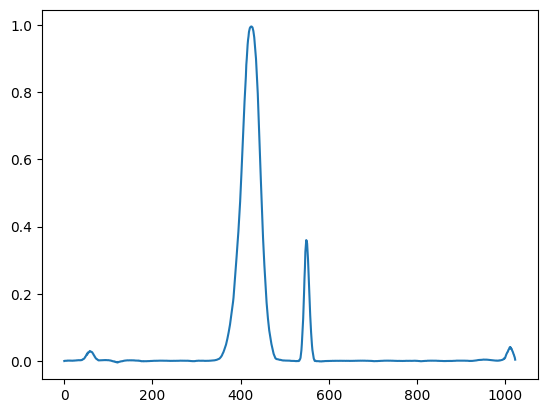

In [13]:
# take a look at a result using a random latent vector as input

random_input = torch.randn(100).to(device)
x = gen_gaussian(random_input.unsqueeze(1).unsqueeze(0))
x = x.detach().cpu()

plt.plot(x.squeeze(0).squeeze(0))

In [14]:
# training with sine wave data

# Dictionary to store training performance data
sine_wave_training_performance_dict = dict()

# file name to save the dictionary to
save_file_name_sine = 'since_gan_training.json'

# file name to save safety glitch outputs to
safety_glitch_file_name_sine = 'sine_safety_glitches.npy'

training_loop(num_epochs=num_epochs, 
              data_loader=sine_wave_train_loader,
              ncycles_D=ncycles_D, 
              lambda_gp=lambda_gp, 
              lambda_ct=lambda_ct,
              M=M, 
              batch_size=batch_size, 
              length_noise=length_noise,
              device=device, 
              netD=disc_sine, 
              netG=gen_sine, 
              lr_D=lr_D, 
              lr_G=lr_G, 
              fixed_noise=fixed_noise, 
              safety_glitch=safety_glitch,
              training_performance_dict=sine_wave_training_performance_dict,
              save_dir=save_dir,
              save_file_name=save_file_name_sine,
              safety_glitch_file_name=safety_glitch_file_name_sine
              )

CT-GAN training loop:   0%|          | 1/500 [00:03<27:23,  3.29s/it]

[1/500] Loss_D: 1.199 | Loss_G: 2.364 | Loss D real : -0.093 | Loss D fake : -1.705 | Loss D GP : 2.963 | Loss D CT : 0.034 | Time : 3.291


CT-GAN training loop:   0%|          | 2/500 [00:06<27:02,  3.26s/it]

[2/500] Loss_D: 1.865 | Loss_G: -0.179 | Loss D real : -0.145 | Loss D fake : 0.164 | Loss D GP : 1.808 | Loss D CT : 0.038 | Time : 3.231


CT-GAN training loop:   1%|          | 3/500 [00:09<27:03,  3.27s/it]

[3/500] Loss_D: 0.405 | Loss_G: 0.318 | Loss D real : -0.121 | Loss D fake : -0.270 | Loss D GP : 0.745 | Loss D CT : 0.050 | Time : 3.274


CT-GAN training loop:   1%|          | 4/500 [00:13<26:54,  3.25s/it]

[4/500] Loss_D: 0.318 | Loss_G: -0.061 | Loss D real : -0.218 | Loss D fake : 0.045 | Loss D GP : 0.437 | Loss D CT : 0.054 | Time : 3.232


CT-GAN training loop:   1%|          | 5/500 [00:16<26:45,  3.24s/it]

[5/500] Loss_D: 0.197 | Loss_G: 0.046 | Loss D real : -0.242 | Loss D fake : -0.016 | Loss D GP : 0.388 | Loss D CT : 0.067 | Time : 3.221


CT-GAN training loop:   1%|          | 6/500 [00:19<26:40,  3.24s/it]

[6/500] Loss_D: 0.240 | Loss_G: 0.038 | Loss D real : -0.244 | Loss D fake : -0.048 | Loss D GP : 0.469 | Loss D CT : 0.064 | Time : 3.231


CT-GAN training loop:   1%|▏         | 7/500 [00:22<26:36,  3.24s/it]

[7/500] Loss_D: 0.194 | Loss_G: 0.012 | Loss D real : -0.217 | Loss D fake : -0.008 | Loss D GP : 0.388 | Loss D CT : 0.032 | Time : 3.230


CT-GAN training loop:   2%|▏         | 8/500 [00:25<26:37,  3.25s/it]

[8/500] Loss_D: 0.280 | Loss_G: -0.021 | Loss D real : -0.234 | Loss D fake : 0.018 | Loss D GP : 0.453 | Loss D CT : 0.042 | Time : 3.261


CT-GAN training loop:   2%|▏         | 9/500 [00:29<26:32,  3.24s/it]

[9/500] Loss_D: 0.123 | Loss_G: -0.010 | Loss D real : -0.252 | Loss D fake : 0.013 | Loss D GP : 0.317 | Loss D CT : 0.044 | Time : 3.235


CT-GAN training loop:   2%|▏         | 10/500 [00:32<26:30,  3.25s/it]

[10/500] Loss_D: 0.133 | Loss_G: -0.022 | Loss D real : -0.277 | Loss D fake : 0.064 | Loss D GP : 0.290 | Loss D CT : 0.056 | Time : 3.248


CT-GAN training loop:   2%|▏         | 11/500 [00:35<26:22,  3.24s/it]

[11/500] Loss_D: 0.156 | Loss_G: -0.056 | Loss D real : -0.249 | Loss D fake : 0.065 | Loss D GP : 0.297 | Loss D CT : 0.043 | Time : 3.210


CT-GAN training loop:   2%|▏         | 12/500 [00:38<26:19,  3.24s/it]

[12/500] Loss_D: 0.118 | Loss_G: -0.069 | Loss D real : -0.237 | Loss D fake : 0.056 | Loss D GP : 0.252 | Loss D CT : 0.048 | Time : 3.232


CT-GAN training loop:   3%|▎         | 13/500 [00:42<26:15,  3.24s/it]

[13/500] Loss_D: 0.199 | Loss_G: -0.076 | Loss D real : -0.243 | Loss D fake : 0.081 | Loss D GP : 0.324 | Loss D CT : 0.037 | Time : 3.231


CT-GAN training loop:   3%|▎         | 14/500 [00:45<26:17,  3.25s/it]

[14/500] Loss_D: 0.246 | Loss_G: -0.066 | Loss D real : -0.246 | Loss D fake : 0.068 | Loss D GP : 0.382 | Loss D CT : 0.042 | Time : 3.264


CT-GAN training loop:   3%|▎         | 15/500 [00:48<26:16,  3.25s/it]

[15/500] Loss_D: 0.342 | Loss_G: -0.023 | Loss D real : -0.218 | Loss D fake : 0.019 | Loss D GP : 0.506 | Loss D CT : 0.036 | Time : 3.257


CT-GAN training loop:   3%|▎         | 16/500 [00:51<26:12,  3.25s/it]

[16/500] Loss_D: 0.275 | Loss_G: -0.047 | Loss D real : -0.228 | Loss D fake : 0.048 | Loss D GP : 0.417 | Loss D CT : 0.037 | Time : 3.241


CT-GAN training loop:   3%|▎         | 17/500 [00:55<26:07,  3.25s/it]

[17/500] Loss_D: 0.279 | Loss_G: -0.064 | Loss D real : -0.227 | Loss D fake : 0.056 | Loss D GP : 0.408 | Loss D CT : 0.043 | Time : 3.237


CT-GAN training loop:   4%|▎         | 18/500 [00:58<26:04,  3.25s/it]

[18/500] Loss_D: 0.399 | Loss_G: -0.049 | Loss D real : -0.207 | Loss D fake : 0.054 | Loss D GP : 0.505 | Loss D CT : 0.047 | Time : 3.241


CT-GAN training loop:   4%|▍         | 19/500 [01:01<25:57,  3.24s/it]

[19/500] Loss_D: 0.299 | Loss_G: -0.069 | Loss D real : -0.205 | Loss D fake : 0.067 | Loss D GP : 0.410 | Loss D CT : 0.026 | Time : 3.219


CT-GAN training loop:   4%|▍         | 20/500 [01:04<25:54,  3.24s/it]

[20/500] Loss_D: 0.358 | Loss_G: -0.073 | Loss D real : -0.221 | Loss D fake : 0.062 | Loss D GP : 0.478 | Loss D CT : 0.040 | Time : 3.238


CT-GAN training loop:   4%|▍         | 21/500 [01:08<25:51,  3.24s/it]

[21/500] Loss_D: 0.252 | Loss_G: -0.077 | Loss D real : -0.245 | Loss D fake : 0.090 | Loss D GP : 0.369 | Loss D CT : 0.038 | Time : 3.237


CT-GAN training loop:   4%|▍         | 22/500 [01:11<25:47,  3.24s/it]

[22/500] Loss_D: 0.140 | Loss_G: -0.081 | Loss D real : -0.236 | Loss D fake : 0.089 | Loss D GP : 0.255 | Loss D CT : 0.033 | Time : 3.228


CT-GAN training loop:   5%|▍         | 23/500 [01:14<25:44,  3.24s/it]

[23/500] Loss_D: 0.130 | Loss_G: -0.064 | Loss D real : -0.224 | Loss D fake : 0.060 | Loss D GP : 0.247 | Loss D CT : 0.047 | Time : 3.239


CT-GAN training loop:   5%|▍         | 24/500 [01:17<25:42,  3.24s/it]

[24/500] Loss_D: 0.158 | Loss_G: -0.087 | Loss D real : -0.224 | Loss D fake : 0.080 | Loss D GP : 0.264 | Loss D CT : 0.038 | Time : 3.239


CT-GAN training loop:   5%|▌         | 25/500 [01:21<25:43,  3.25s/it]

[25/500] Loss_D: 0.148 | Loss_G: -0.051 | Loss D real : -0.224 | Loss D fake : 0.054 | Loss D GP : 0.283 | Loss D CT : 0.035 | Time : 3.268


CT-GAN training loop:   5%|▌         | 26/500 [01:24<25:39,  3.25s/it]

[26/500] Loss_D: 0.131 | Loss_G: -0.049 | Loss D real : -0.227 | Loss D fake : 0.046 | Loss D GP : 0.288 | Loss D CT : 0.023 | Time : 3.243


CT-GAN training loop:   5%|▌         | 27/500 [01:27<25:35,  3.25s/it]

[27/500] Loss_D: 0.262 | Loss_G: -0.080 | Loss D real : -0.247 | Loss D fake : 0.094 | Loss D GP : 0.388 | Loss D CT : 0.027 | Time : 3.237


CT-GAN training loop:   6%|▌         | 28/500 [01:30<25:32,  3.25s/it]

[28/500] Loss_D: 0.264 | Loss_G: -0.074 | Loss D real : -0.237 | Loss D fake : 0.081 | Loss D GP : 0.390 | Loss D CT : 0.029 | Time : 3.249


CT-GAN training loop:   6%|▌         | 29/500 [01:34<25:32,  3.25s/it]

[29/500] Loss_D: 0.154 | Loss_G: -0.085 | Loss D real : -0.237 | Loss D fake : 0.065 | Loss D GP : 0.284 | Loss D CT : 0.041 | Time : 3.266


CT-GAN training loop:   6%|▌         | 30/500 [01:37<25:31,  3.26s/it]

[30/500] Loss_D: 0.124 | Loss_G: -0.083 | Loss D real : -0.233 | Loss D fake : 0.080 | Loss D GP : 0.247 | Loss D CT : 0.030 | Time : 3.262


CT-GAN training loop:   6%|▌         | 31/500 [01:40<25:26,  3.25s/it]

[31/500] Loss_D: 0.128 | Loss_G: -0.088 | Loss D real : -0.228 | Loss D fake : 0.084 | Loss D GP : 0.241 | Loss D CT : 0.030 | Time : 3.243


CT-GAN training loop:   6%|▋         | 32/500 [01:43<25:22,  3.25s/it]

[32/500] Loss_D: 0.112 | Loss_G: -0.064 | Loss D real : -0.230 | Loss D fake : 0.045 | Loss D GP : 0.257 | Loss D CT : 0.040 | Time : 3.249


CT-GAN training loop:   7%|▋         | 33/500 [01:47<25:18,  3.25s/it]

[33/500] Loss_D: 0.061 | Loss_G: -0.054 | Loss D real : -0.227 | Loss D fake : 0.052 | Loss D GP : 0.204 | Loss D CT : 0.032 | Time : 3.241


CT-GAN training loop:   7%|▋         | 34/500 [01:50<25:13,  3.25s/it]

[34/500] Loss_D: 0.136 | Loss_G: -0.078 | Loss D real : -0.237 | Loss D fake : 0.095 | Loss D GP : 0.247 | Loss D CT : 0.030 | Time : 3.241


CT-GAN training loop:   7%|▋         | 35/500 [01:53<25:08,  3.24s/it]

[35/500] Loss_D: 0.073 | Loss_G: -0.035 | Loss D real : -0.222 | Loss D fake : 0.061 | Loss D GP : 0.211 | Loss D CT : 0.023 | Time : 3.230


CT-GAN training loop:   7%|▋         | 36/500 [01:56<25:06,  3.25s/it]

[36/500] Loss_D: 0.122 | Loss_G: -0.060 | Loss D real : -0.211 | Loss D fake : 0.074 | Loss D GP : 0.236 | Loss D CT : 0.023 | Time : 3.249


CT-GAN training loop:   7%|▋         | 37/500 [02:00<25:06,  3.25s/it]

[37/500] Loss_D: 0.050 | Loss_G: -0.050 | Loss D real : -0.213 | Loss D fake : 0.061 | Loss D GP : 0.184 | Loss D CT : 0.020 | Time : 3.270


CT-GAN training loop:   8%|▊         | 38/500 [02:03<25:04,  3.26s/it]

[38/500] Loss_D: 0.025 | Loss_G: -0.046 | Loss D real : -0.186 | Loss D fake : 0.044 | Loss D GP : 0.148 | Loss D CT : 0.019 | Time : 3.262


CT-GAN training loop:   8%|▊         | 39/500 [02:06<25:04,  3.26s/it]

[39/500] Loss_D: 0.010 | Loss_G: -0.025 | Loss D real : -0.175 | Loss D fake : 0.029 | Loss D GP : 0.141 | Loss D CT : 0.015 | Time : 3.275


CT-GAN training loop:   8%|▊         | 40/500 [02:09<24:58,  3.26s/it]

[40/500] Loss_D: 0.026 | Loss_G: -0.054 | Loss D real : -0.195 | Loss D fake : 0.058 | Loss D GP : 0.143 | Loss D CT : 0.020 | Time : 3.240


CT-GAN training loop:   8%|▊         | 41/500 [02:13<24:53,  3.25s/it]

[41/500] Loss_D: 0.010 | Loss_G: -0.045 | Loss D real : -0.199 | Loss D fake : 0.050 | Loss D GP : 0.141 | Loss D CT : 0.019 | Time : 3.243


CT-GAN training loop:   8%|▊         | 42/500 [02:16<24:51,  3.26s/it]

[42/500] Loss_D: -0.007 | Loss_G: -0.052 | Loss D real : -0.206 | Loss D fake : 0.057 | Loss D GP : 0.120 | Loss D CT : 0.022 | Time : 3.262


CT-GAN training loop:   9%|▊         | 43/500 [02:19<24:50,  3.26s/it]

[43/500] Loss_D: 0.056 | Loss_G: -0.076 | Loss D real : -0.205 | Loss D fake : 0.073 | Loss D GP : 0.171 | Loss D CT : 0.017 | Time : 3.268


CT-GAN training loop:   9%|▉         | 44/500 [02:22<24:47,  3.26s/it]

[44/500] Loss_D: 0.022 | Loss_G: -0.059 | Loss D real : -0.191 | Loss D fake : 0.051 | Loss D GP : 0.143 | Loss D CT : 0.020 | Time : 3.257


CT-GAN training loop:   9%|▉         | 45/500 [02:26<24:42,  3.26s/it]

[45/500] Loss_D: 0.031 | Loss_G: -0.059 | Loss D real : -0.198 | Loss D fake : 0.066 | Loss D GP : 0.143 | Loss D CT : 0.019 | Time : 3.248


CT-GAN training loop:   9%|▉         | 46/500 [02:29<24:39,  3.26s/it]

[46/500] Loss_D: 0.031 | Loss_G: -0.057 | Loss D real : -0.191 | Loss D fake : 0.051 | Loss D GP : 0.153 | Loss D CT : 0.019 | Time : 3.260


CT-GAN training loop:   9%|▉         | 47/500 [02:32<24:38,  3.26s/it]

[47/500] Loss_D: 0.018 | Loss_G: -0.077 | Loss D real : -0.209 | Loss D fake : 0.086 | Loss D GP : 0.118 | Loss D CT : 0.024 | Time : 3.273


CT-GAN training loop:  10%|▉         | 48/500 [02:36<24:36,  3.27s/it]

[48/500] Loss_D: 0.006 | Loss_G: -0.060 | Loss D real : -0.184 | Loss D fake : 0.058 | Loss D GP : 0.118 | Loss D CT : 0.014 | Time : 3.270


CT-GAN training loop:  10%|▉         | 49/500 [02:39<24:30,  3.26s/it]

[49/500] Loss_D: 0.003 | Loss_G: -0.045 | Loss D real : -0.197 | Loss D fake : 0.064 | Loss D GP : 0.119 | Loss D CT : 0.017 | Time : 3.244


CT-GAN training loop:  10%|█         | 50/500 [02:42<24:26,  3.26s/it]

[50/500] Loss_D: 0.069 | Loss_G: -0.080 | Loss D real : -0.205 | Loss D fake : 0.085 | Loss D GP : 0.166 | Loss D CT : 0.023 | Time : 3.253


CT-GAN training loop:  10%|█         | 51/500 [02:45<24:26,  3.27s/it]

[51/500] Loss_D: 0.008 | Loss_G: -0.069 | Loss D real : -0.195 | Loss D fake : 0.070 | Loss D GP : 0.112 | Loss D CT : 0.020 | Time : 3.281


CT-GAN training loop:  10%|█         | 52/500 [02:49<24:26,  3.27s/it]

[52/500] Loss_D: -0.008 | Loss_G: -0.057 | Loss D real : -0.175 | Loss D fake : 0.046 | Loss D GP : 0.105 | Loss D CT : 0.016 | Time : 3.288


CT-GAN training loop:  11%|█         | 53/500 [02:52<24:23,  3.27s/it]

[53/500] Loss_D: -0.015 | Loss_G: -0.062 | Loss D real : -0.204 | Loss D fake : 0.074 | Loss D GP : 0.098 | Loss D CT : 0.018 | Time : 3.270


CT-GAN training loop:  11%|█         | 54/500 [02:55<24:18,  3.27s/it]

[54/500] Loss_D: -0.032 | Loss_G: -0.072 | Loss D real : -0.195 | Loss D fake : 0.070 | Loss D GP : 0.076 | Loss D CT : 0.017 | Time : 3.257


CT-GAN training loop:  11%|█         | 55/500 [02:58<24:21,  3.29s/it]

[55/500] Loss_D: -0.020 | Loss_G: -0.071 | Loss D real : -0.189 | Loss D fake : 0.072 | Loss D GP : 0.086 | Loss D CT : 0.011 | Time : 3.319


CT-GAN training loop:  11%|█         | 56/500 [03:02<24:17,  3.28s/it]

[56/500] Loss_D: 0.009 | Loss_G: -0.077 | Loss D real : -0.172 | Loss D fake : 0.063 | Loss D GP : 0.102 | Loss D CT : 0.016 | Time : 3.276


CT-GAN training loop:  11%|█▏        | 57/500 [03:05<24:15,  3.29s/it]

[57/500] Loss_D: -0.011 | Loss_G: -0.068 | Loss D real : -0.198 | Loss D fake : 0.082 | Loss D GP : 0.088 | Loss D CT : 0.018 | Time : 3.288


CT-GAN training loop:  12%|█▏        | 58/500 [03:08<24:10,  3.28s/it]

[58/500] Loss_D: 0.017 | Loss_G: -0.062 | Loss D real : -0.186 | Loss D fake : 0.069 | Loss D GP : 0.115 | Loss D CT : 0.018 | Time : 3.268


CT-GAN training loop:  12%|█▏        | 59/500 [03:12<24:08,  3.28s/it]

[59/500] Loss_D: -0.013 | Loss_G: -0.089 | Loss D real : -0.173 | Loss D fake : 0.063 | Loss D GP : 0.087 | Loss D CT : 0.010 | Time : 3.289


CT-GAN training loop:  12%|█▏        | 60/500 [03:15<23:59,  3.27s/it]

[60/500] Loss_D: 0.035 | Loss_G: -0.070 | Loss D real : -0.196 | Loss D fake : 0.077 | Loss D GP : 0.136 | Loss D CT : 0.018 | Time : 3.241


CT-GAN training loop:  12%|█▏        | 61/500 [03:18<23:54,  3.27s/it]

[61/500] Loss_D: 0.020 | Loss_G: -0.100 | Loss D real : -0.197 | Loss D fake : 0.083 | Loss D GP : 0.117 | Loss D CT : 0.017 | Time : 3.251


CT-GAN training loop:  12%|█▏        | 62/500 [03:21<23:49,  3.26s/it]

[62/500] Loss_D: -0.037 | Loss_G: -0.050 | Loss D real : -0.203 | Loss D fake : 0.081 | Loss D GP : 0.071 | Loss D CT : 0.013 | Time : 3.256


CT-GAN training loop:  13%|█▎        | 63/500 [03:25<23:47,  3.27s/it]

[63/500] Loss_D: -0.020 | Loss_G: -0.092 | Loss D real : -0.176 | Loss D fake : 0.062 | Loss D GP : 0.083 | Loss D CT : 0.011 | Time : 3.267


CT-GAN training loop:  13%|█▎        | 64/500 [03:28<23:41,  3.26s/it]

[64/500] Loss_D: -0.011 | Loss_G: -0.074 | Loss D real : -0.186 | Loss D fake : 0.070 | Loss D GP : 0.094 | Loss D CT : 0.011 | Time : 3.247


CT-GAN training loop:  13%|█▎        | 65/500 [03:31<23:42,  3.27s/it]

[65/500] Loss_D: -0.024 | Loss_G: -0.070 | Loss D real : -0.183 | Loss D fake : 0.078 | Loss D GP : 0.070 | Loss D CT : 0.012 | Time : 3.290


CT-GAN training loop:  13%|█▎        | 66/500 [03:34<23:40,  3.27s/it]

[66/500] Loss_D: -0.023 | Loss_G: -0.078 | Loss D real : -0.201 | Loss D fake : 0.085 | Loss D GP : 0.082 | Loss D CT : 0.011 | Time : 3.274


CT-GAN training loop:  13%|█▎        | 67/500 [03:38<23:43,  3.29s/it]

[67/500] Loss_D: -0.008 | Loss_G: -0.088 | Loss D real : -0.202 | Loss D fake : 0.089 | Loss D GP : 0.087 | Loss D CT : 0.018 | Time : 3.316


CT-GAN training loop:  14%|█▎        | 68/500 [03:41<23:36,  3.28s/it]

[68/500] Loss_D: -0.007 | Loss_G: -0.086 | Loss D real : -0.191 | Loss D fake : 0.076 | Loss D GP : 0.094 | Loss D CT : 0.014 | Time : 3.258


CT-GAN training loop:  14%|█▍        | 69/500 [03:44<23:29,  3.27s/it]

[69/500] Loss_D: -0.018 | Loss_G: -0.075 | Loss D real : -0.198 | Loss D fake : 0.093 | Loss D GP : 0.069 | Loss D CT : 0.018 | Time : 3.244


CT-GAN training loop:  14%|█▍        | 70/500 [03:48<23:31,  3.28s/it]

[70/500] Loss_D: -0.024 | Loss_G: -0.088 | Loss D real : -0.196 | Loss D fake : 0.078 | Loss D GP : 0.082 | Loss D CT : 0.013 | Time : 3.312


CT-GAN training loop:  14%|█▍        | 71/500 [03:51<23:30,  3.29s/it]

[71/500] Loss_D: -0.027 | Loss_G: -0.093 | Loss D real : -0.202 | Loss D fake : 0.094 | Loss D GP : 0.069 | Loss D CT : 0.011 | Time : 3.297


CT-GAN training loop:  14%|█▍        | 72/500 [03:54<23:32,  3.30s/it]

[72/500] Loss_D: -0.017 | Loss_G: -0.076 | Loss D real : -0.192 | Loss D fake : 0.080 | Loss D GP : 0.083 | Loss D CT : 0.013 | Time : 3.326


CT-GAN training loop:  15%|█▍        | 73/500 [03:58<23:32,  3.31s/it]

[73/500] Loss_D: -0.043 | Loss_G: -0.079 | Loss D real : -0.181 | Loss D fake : 0.066 | Loss D GP : 0.059 | Loss D CT : 0.013 | Time : 3.323


CT-GAN training loop:  15%|█▍        | 74/500 [04:01<23:33,  3.32s/it]

[74/500] Loss_D: -0.041 | Loss_G: -0.084 | Loss D real : -0.204 | Loss D fake : 0.092 | Loss D GP : 0.060 | Loss D CT : 0.012 | Time : 3.337


CT-GAN training loop:  15%|█▌        | 75/500 [04:04<23:31,  3.32s/it]

[75/500] Loss_D: -0.047 | Loss_G: -0.081 | Loss D real : -0.193 | Loss D fake : 0.076 | Loss D GP : 0.061 | Loss D CT : 0.009 | Time : 3.325


CT-GAN training loop:  15%|█▌        | 76/500 [04:08<23:30,  3.33s/it]

[76/500] Loss_D: -0.011 | Loss_G: -0.090 | Loss D real : -0.197 | Loss D fake : 0.097 | Loss D GP : 0.079 | Loss D CT : 0.010 | Time : 3.336


CT-GAN training loop:  15%|█▌        | 77/500 [04:11<23:30,  3.33s/it]

[77/500] Loss_D: -0.008 | Loss_G: -0.084 | Loss D real : -0.183 | Loss D fake : 0.082 | Loss D GP : 0.081 | Loss D CT : 0.012 | Time : 3.346


CT-GAN training loop:  16%|█▌        | 78/500 [04:14<23:24,  3.33s/it]

[78/500] Loss_D: -0.011 | Loss_G: -0.096 | Loss D real : -0.204 | Loss D fake : 0.103 | Loss D GP : 0.076 | Loss D CT : 0.013 | Time : 3.316


CT-GAN training loop:  16%|█▌        | 79/500 [04:18<23:21,  3.33s/it]

[79/500] Loss_D: -0.004 | Loss_G: -0.093 | Loss D real : -0.181 | Loss D fake : 0.081 | Loss D GP : 0.085 | Loss D CT : 0.010 | Time : 3.325


CT-GAN training loop:  16%|█▌        | 80/500 [04:21<23:19,  3.33s/it]

[80/500] Loss_D: 0.016 | Loss_G: -0.096 | Loss D real : -0.179 | Loss D fake : 0.082 | Loss D GP : 0.106 | Loss D CT : 0.007 | Time : 3.340


CT-GAN training loop:  16%|█▌        | 81/500 [04:24<23:23,  3.35s/it]

[81/500] Loss_D: -0.015 | Loss_G: -0.105 | Loss D real : -0.181 | Loss D fake : 0.086 | Loss D GP : 0.072 | Loss D CT : 0.007 | Time : 3.383


CT-GAN training loop:  16%|█▋        | 82/500 [04:28<23:16,  3.34s/it]

[82/500] Loss_D: -0.020 | Loss_G: -0.082 | Loss D real : -0.186 | Loss D fake : 0.083 | Loss D GP : 0.071 | Loss D CT : 0.012 | Time : 3.315


CT-GAN training loop:  17%|█▋        | 83/500 [04:31<23:09,  3.33s/it]

[83/500] Loss_D: 0.012 | Loss_G: -0.081 | Loss D real : -0.194 | Loss D fake : 0.089 | Loss D GP : 0.105 | Loss D CT : 0.012 | Time : 3.313


CT-GAN training loop:  17%|█▋        | 84/500 [04:34<23:06,  3.33s/it]

[84/500] Loss_D: -0.019 | Loss_G: -0.094 | Loss D real : -0.184 | Loss D fake : 0.081 | Loss D GP : 0.076 | Loss D CT : 0.009 | Time : 3.325


CT-GAN training loop:  17%|█▋        | 85/500 [04:38<23:06,  3.34s/it]

[85/500] Loss_D: -0.025 | Loss_G: -0.095 | Loss D real : -0.194 | Loss D fake : 0.098 | Loss D GP : 0.058 | Loss D CT : 0.013 | Time : 3.361


CT-GAN training loop:  17%|█▋        | 86/500 [04:41<23:02,  3.34s/it]

[86/500] Loss_D: 0.013 | Loss_G: -0.109 | Loss D real : -0.185 | Loss D fake : 0.099 | Loss D GP : 0.089 | Loss D CT : 0.010 | Time : 3.330


CT-GAN training loop:  17%|█▋        | 87/500 [04:44<23:01,  3.34s/it]

[87/500] Loss_D: -0.030 | Loss_G: -0.099 | Loss D real : -0.194 | Loss D fake : 0.099 | Loss D GP : 0.057 | Loss D CT : 0.009 | Time : 3.352


CT-GAN training loop:  18%|█▊        | 88/500 [04:48<22:56,  3.34s/it]

[88/500] Loss_D: -0.023 | Loss_G: -0.092 | Loss D real : -0.216 | Loss D fake : 0.122 | Loss D GP : 0.060 | Loss D CT : 0.012 | Time : 3.330


CT-GAN training loop:  18%|█▊        | 89/500 [04:51<22:52,  3.34s/it]

[89/500] Loss_D: -0.011 | Loss_G: -0.097 | Loss D real : -0.199 | Loss D fake : 0.100 | Loss D GP : 0.078 | Loss D CT : 0.009 | Time : 3.330


CT-GAN training loop:  18%|█▊        | 90/500 [04:54<22:47,  3.33s/it]

[90/500] Loss_D: -0.015 | Loss_G: -0.092 | Loss D real : -0.206 | Loss D fake : 0.102 | Loss D GP : 0.075 | Loss D CT : 0.014 | Time : 3.320


CT-GAN training loop:  18%|█▊        | 91/500 [04:58<22:45,  3.34s/it]

[91/500] Loss_D: -0.027 | Loss_G: -0.101 | Loss D real : -0.189 | Loss D fake : 0.100 | Loss D GP : 0.054 | Loss D CT : 0.008 | Time : 3.346


CT-GAN training loop:  18%|█▊        | 92/500 [05:01<22:41,  3.34s/it]

[92/500] Loss_D: -0.000 | Loss_G: -0.088 | Loss D real : -0.170 | Loss D fake : 0.076 | Loss D GP : 0.085 | Loss D CT : 0.008 | Time : 3.330


CT-GAN training loop:  19%|█▊        | 93/500 [05:04<22:37,  3.33s/it]

[93/500] Loss_D: -0.029 | Loss_G: -0.090 | Loss D real : -0.198 | Loss D fake : 0.099 | Loss D GP : 0.059 | Loss D CT : 0.011 | Time : 3.324


CT-GAN training loop:  19%|█▉        | 94/500 [05:08<22:31,  3.33s/it]

[94/500] Loss_D: -0.050 | Loss_G: -0.067 | Loss D real : -0.198 | Loss D fake : 0.085 | Loss D GP : 0.056 | Loss D CT : 0.007 | Time : 3.314


CT-GAN training loop:  19%|█▉        | 95/500 [05:11<22:31,  3.34s/it]

[95/500] Loss_D: -0.036 | Loss_G: -0.097 | Loss D real : -0.180 | Loss D fake : 0.087 | Loss D GP : 0.052 | Loss D CT : 0.006 | Time : 3.350


CT-GAN training loop:  19%|█▉        | 96/500 [05:14<22:25,  3.33s/it]

[96/500] Loss_D: -0.023 | Loss_G: -0.103 | Loss D real : -0.197 | Loss D fake : 0.105 | Loss D GP : 0.061 | Loss D CT : 0.008 | Time : 3.316


CT-GAN training loop:  19%|█▉        | 97/500 [05:18<22:22,  3.33s/it]

[97/500] Loss_D: -0.013 | Loss_G: -0.076 | Loss D real : -0.193 | Loss D fake : 0.099 | Loss D GP : 0.066 | Loss D CT : 0.016 | Time : 3.324


CT-GAN training loop:  20%|█▉        | 98/500 [05:21<22:16,  3.32s/it]

[98/500] Loss_D: -0.007 | Loss_G: -0.111 | Loss D real : -0.182 | Loss D fake : 0.099 | Loss D GP : 0.069 | Loss D CT : 0.008 | Time : 3.307


CT-GAN training loop:  20%|█▉        | 99/500 [05:24<22:15,  3.33s/it]

[99/500] Loss_D: -0.002 | Loss_G: -0.092 | Loss D real : -0.196 | Loss D fake : 0.104 | Loss D GP : 0.080 | Loss D CT : 0.010 | Time : 3.341


CT-GAN training loop:  20%|██        | 100/500 [05:28<22:13,  3.33s/it]

[100/500] Loss_D: -0.022 | Loss_G: -0.093 | Loss D real : -0.193 | Loss D fake : 0.105 | Loss D GP : 0.055 | Loss D CT : 0.010 | Time : 3.336


CT-GAN training loop:  20%|██        | 101/500 [05:31<22:07,  3.33s/it]

[101/500] Loss_D: -0.006 | Loss_G: -0.089 | Loss D real : -0.192 | Loss D fake : 0.101 | Loss D GP : 0.076 | Loss D CT : 0.010 | Time : 3.311


CT-GAN training loop:  20%|██        | 102/500 [05:34<22:03,  3.33s/it]

[102/500] Loss_D: -0.010 | Loss_G: -0.094 | Loss D real : -0.193 | Loss D fake : 0.090 | Loss D GP : 0.085 | Loss D CT : 0.008 | Time : 3.317


CT-GAN training loop:  21%|██        | 103/500 [05:38<22:03,  3.33s/it]

[103/500] Loss_D: -0.036 | Loss_G: -0.088 | Loss D real : -0.194 | Loss D fake : 0.097 | Loss D GP : 0.053 | Loss D CT : 0.008 | Time : 3.348


CT-GAN training loop:  21%|██        | 104/500 [05:41<22:02,  3.34s/it]

[104/500] Loss_D: -0.024 | Loss_G: -0.099 | Loss D real : -0.199 | Loss D fake : 0.106 | Loss D GP : 0.056 | Loss D CT : 0.013 | Time : 3.350


CT-GAN training loop:  21%|██        | 105/500 [05:44<21:59,  3.34s/it]

[105/500] Loss_D: -0.008 | Loss_G: -0.099 | Loss D real : -0.193 | Loss D fake : 0.104 | Loss D GP : 0.072 | Loss D CT : 0.009 | Time : 3.339


CT-GAN training loop:  21%|██        | 106/500 [05:48<21:56,  3.34s/it]

[106/500] Loss_D: -0.003 | Loss_G: -0.103 | Loss D real : -0.191 | Loss D fake : 0.105 | Loss D GP : 0.070 | Loss D CT : 0.013 | Time : 3.344


CT-GAN training loop:  21%|██▏       | 107/500 [05:51<21:53,  3.34s/it]

[107/500] Loss_D: -0.005 | Loss_G: -0.098 | Loss D real : -0.187 | Loss D fake : 0.102 | Loss D GP : 0.069 | Loss D CT : 0.011 | Time : 3.334


CT-GAN training loop:  22%|██▏       | 108/500 [05:54<21:49,  3.34s/it]

[108/500] Loss_D: -0.012 | Loss_G: -0.104 | Loss D real : -0.188 | Loss D fake : 0.105 | Loss D GP : 0.062 | Loss D CT : 0.010 | Time : 3.338


CT-GAN training loop:  22%|██▏       | 109/500 [05:58<21:50,  3.35s/it]

[109/500] Loss_D: 0.022 | Loss_G: -0.099 | Loss D real : -0.173 | Loss D fake : 0.095 | Loss D GP : 0.094 | Loss D CT : 0.005 | Time : 3.376


CT-GAN training loop:  22%|██▏       | 110/500 [06:01<21:45,  3.35s/it]

[110/500] Loss_D: -0.024 | Loss_G: -0.086 | Loss D real : -0.204 | Loss D fake : 0.107 | Loss D GP : 0.060 | Loss D CT : 0.013 | Time : 3.334


CT-GAN training loop:  22%|██▏       | 111/500 [06:04<21:42,  3.35s/it]

[111/500] Loss_D: -0.022 | Loss_G: -0.091 | Loss D real : -0.170 | Loss D fake : 0.078 | Loss D GP : 0.062 | Loss D CT : 0.008 | Time : 3.348


CT-GAN training loop:  22%|██▏       | 112/500 [06:08<21:39,  3.35s/it]

[112/500] Loss_D: -0.016 | Loss_G: -0.110 | Loss D real : -0.188 | Loss D fake : 0.106 | Loss D GP : 0.059 | Loss D CT : 0.007 | Time : 3.348


CT-GAN training loop:  23%|██▎       | 113/500 [06:11<21:35,  3.35s/it]

[113/500] Loss_D: 0.014 | Loss_G: -0.095 | Loss D real : -0.174 | Loss D fake : 0.084 | Loss D GP : 0.079 | Loss D CT : 0.025 | Time : 3.336


CT-GAN training loop:  23%|██▎       | 114/500 [06:14<21:32,  3.35s/it]

[114/500] Loss_D: -0.007 | Loss_G: -0.105 | Loss D real : -0.201 | Loss D fake : 0.118 | Loss D GP : 0.067 | Loss D CT : 0.009 | Time : 3.352


CT-GAN training loop:  23%|██▎       | 115/500 [06:18<21:28,  3.35s/it]

[115/500] Loss_D: -0.011 | Loss_G: -0.114 | Loss D real : -0.186 | Loss D fake : 0.102 | Loss D GP : 0.065 | Loss D CT : 0.007 | Time : 3.336


CT-GAN training loop:  23%|██▎       | 116/500 [06:21<21:22,  3.34s/it]

[116/500] Loss_D: -0.020 | Loss_G: -0.094 | Loss D real : -0.182 | Loss D fake : 0.094 | Loss D GP : 0.061 | Loss D CT : 0.008 | Time : 3.324


CT-GAN training loop:  23%|██▎       | 117/500 [06:24<21:18,  3.34s/it]

[117/500] Loss_D: 0.005 | Loss_G: -0.091 | Loss D real : -0.186 | Loss D fake : 0.096 | Loss D GP : 0.086 | Loss D CT : 0.009 | Time : 3.328


CT-GAN training loop:  24%|██▎       | 118/500 [06:28<21:14,  3.34s/it]

[118/500] Loss_D: -0.021 | Loss_G: -0.093 | Loss D real : -0.194 | Loss D fake : 0.106 | Loss D GP : 0.056 | Loss D CT : 0.011 | Time : 3.330


CT-GAN training loop:  24%|██▍       | 119/500 [06:31<21:09,  3.33s/it]

[119/500] Loss_D: -0.014 | Loss_G: -0.099 | Loss D real : -0.181 | Loss D fake : 0.102 | Loss D GP : 0.058 | Loss D CT : 0.008 | Time : 3.318


CT-GAN training loop:  24%|██▍       | 120/500 [06:34<21:04,  3.33s/it]

[120/500] Loss_D: 0.006 | Loss_G: -0.113 | Loss D real : -0.186 | Loss D fake : 0.111 | Loss D GP : 0.073 | Loss D CT : 0.008 | Time : 3.312


CT-GAN training loop:  24%|██▍       | 121/500 [06:38<21:02,  3.33s/it]

[121/500] Loss_D: -0.020 | Loss_G: -0.101 | Loss D real : -0.193 | Loss D fake : 0.110 | Loss D GP : 0.055 | Loss D CT : 0.008 | Time : 3.340


CT-GAN training loop:  24%|██▍       | 122/500 [06:41<21:00,  3.33s/it]

[122/500] Loss_D: -0.023 | Loss_G: -0.104 | Loss D real : -0.182 | Loss D fake : 0.098 | Loss D GP : 0.055 | Loss D CT : 0.007 | Time : 3.337


CT-GAN training loop:  25%|██▍       | 123/500 [06:44<21:00,  3.34s/it]

[123/500] Loss_D: -0.015 | Loss_G: -0.117 | Loss D real : -0.185 | Loss D fake : 0.104 | Loss D GP : 0.053 | Loss D CT : 0.013 | Time : 3.365


CT-GAN training loop:  25%|██▍       | 124/500 [06:48<20:57,  3.34s/it]

[124/500] Loss_D: 0.018 | Loss_G: -0.108 | Loss D real : -0.202 | Loss D fake : 0.116 | Loss D GP : 0.094 | Loss D CT : 0.010 | Time : 3.339


CT-GAN training loop:  25%|██▌       | 125/500 [06:51<20:55,  3.35s/it]

[125/500] Loss_D: -0.009 | Loss_G: -0.098 | Loss D real : -0.176 | Loss D fake : 0.096 | Loss D GP : 0.062 | Loss D CT : 0.008 | Time : 3.353


CT-GAN training loop:  25%|██▌       | 126/500 [06:54<20:51,  3.35s/it]

[126/500] Loss_D: -0.037 | Loss_G: -0.094 | Loss D real : -0.202 | Loss D fake : 0.099 | Loss D GP : 0.057 | Loss D CT : 0.009 | Time : 3.337


CT-GAN training loop:  25%|██▌       | 127/500 [06:58<20:48,  3.35s/it]

[127/500] Loss_D: -0.034 | Loss_G: -0.085 | Loss D real : -0.198 | Loss D fake : 0.104 | Loss D GP : 0.050 | Loss D CT : 0.010 | Time : 3.345


CT-GAN training loop:  26%|██▌       | 128/500 [07:01<20:44,  3.35s/it]

[128/500] Loss_D: -0.017 | Loss_G: -0.101 | Loss D real : -0.179 | Loss D fake : 0.096 | Loss D GP : 0.054 | Loss D CT : 0.011 | Time : 3.342


CT-GAN training loop:  26%|██▌       | 129/500 [07:05<20:43,  3.35s/it]

[129/500] Loss_D: -0.018 | Loss_G: -0.118 | Loss D real : -0.192 | Loss D fake : 0.111 | Loss D GP : 0.058 | Loss D CT : 0.005 | Time : 3.357


CT-GAN training loop:  26%|██▌       | 130/500 [07:08<20:36,  3.34s/it]

[130/500] Loss_D: 0.001 | Loss_G: -0.095 | Loss D real : -0.176 | Loss D fake : 0.094 | Loss D GP : 0.073 | Loss D CT : 0.009 | Time : 3.322


CT-GAN training loop:  26%|██▌       | 131/500 [07:11<20:32,  3.34s/it]

[131/500] Loss_D: -0.001 | Loss_G: -0.117 | Loss D real : -0.195 | Loss D fake : 0.111 | Loss D GP : 0.074 | Loss D CT : 0.009 | Time : 3.333


CT-GAN training loop:  26%|██▋       | 132/500 [07:15<20:29,  3.34s/it]

[132/500] Loss_D: -0.014 | Loss_G: -0.111 | Loss D real : -0.190 | Loss D fake : 0.110 | Loss D GP : 0.059 | Loss D CT : 0.006 | Time : 3.338


CT-GAN training loop:  27%|██▋       | 133/500 [07:18<20:29,  3.35s/it]

[133/500] Loss_D: -0.024 | Loss_G: -0.117 | Loss D real : -0.199 | Loss D fake : 0.118 | Loss D GP : 0.051 | Loss D CT : 0.007 | Time : 3.367


CT-GAN training loop:  27%|██▋       | 134/500 [07:21<20:24,  3.35s/it]

[134/500] Loss_D: -0.010 | Loss_G: -0.112 | Loss D real : -0.183 | Loss D fake : 0.100 | Loss D GP : 0.065 | Loss D CT : 0.008 | Time : 3.332


CT-GAN training loop:  27%|██▋       | 135/500 [07:25<20:20,  3.34s/it]

[135/500] Loss_D: -0.010 | Loss_G: -0.106 | Loss D real : -0.200 | Loss D fake : 0.111 | Loss D GP : 0.070 | Loss D CT : 0.009 | Time : 3.337


CT-GAN training loop:  27%|██▋       | 136/500 [07:28<20:17,  3.35s/it]

[136/500] Loss_D: -0.007 | Loss_G: -0.090 | Loss D real : -0.186 | Loss D fake : 0.106 | Loss D GP : 0.063 | Loss D CT : 0.010 | Time : 3.346


CT-GAN training loop:  27%|██▋       | 137/500 [07:31<20:14,  3.35s/it]

[137/500] Loss_D: -0.026 | Loss_G: -0.107 | Loss D real : -0.200 | Loss D fake : 0.120 | Loss D GP : 0.045 | Loss D CT : 0.008 | Time : 3.343


CT-GAN training loop:  28%|██▊       | 138/500 [07:35<20:10,  3.34s/it]

[138/500] Loss_D: -0.019 | Loss_G: -0.105 | Loss D real : -0.186 | Loss D fake : 0.097 | Loss D GP : 0.063 | Loss D CT : 0.007 | Time : 3.336


CT-GAN training loop:  28%|██▊       | 139/500 [07:38<20:08,  3.35s/it]

[139/500] Loss_D: -0.012 | Loss_G: -0.108 | Loss D real : -0.196 | Loss D fake : 0.117 | Loss D GP : 0.060 | Loss D CT : 0.008 | Time : 3.357


CT-GAN training loop:  28%|██▊       | 140/500 [07:41<20:06,  3.35s/it]

[140/500] Loss_D: -0.024 | Loss_G: -0.113 | Loss D real : -0.198 | Loss D fake : 0.118 | Loss D GP : 0.051 | Loss D CT : 0.006 | Time : 3.350


CT-GAN training loop:  28%|██▊       | 141/500 [07:45<20:00,  3.34s/it]

[141/500] Loss_D: -0.012 | Loss_G: -0.113 | Loss D real : -0.192 | Loss D fake : 0.119 | Loss D GP : 0.057 | Loss D CT : 0.005 | Time : 3.329


CT-GAN training loop:  28%|██▊       | 142/500 [07:48<19:55,  3.34s/it]

[142/500] Loss_D: -0.011 | Loss_G: -0.102 | Loss D real : -0.198 | Loss D fake : 0.114 | Loss D GP : 0.066 | Loss D CT : 0.007 | Time : 3.320


CT-GAN training loop:  29%|██▊       | 143/500 [07:51<19:51,  3.34s/it]

[143/500] Loss_D: -0.021 | Loss_G: -0.103 | Loss D real : -0.200 | Loss D fake : 0.118 | Loss D GP : 0.052 | Loss D CT : 0.009 | Time : 3.333


CT-GAN training loop:  29%|██▉       | 144/500 [07:55<19:49,  3.34s/it]

[144/500] Loss_D: -0.001 | Loss_G: -0.115 | Loss D real : -0.200 | Loss D fake : 0.123 | Loss D GP : 0.067 | Loss D CT : 0.009 | Time : 3.348


CT-GAN training loop:  29%|██▉       | 145/500 [07:58<19:48,  3.35s/it]

[145/500] Loss_D: -0.017 | Loss_G: -0.101 | Loss D real : -0.199 | Loss D fake : 0.111 | Loss D GP : 0.062 | Loss D CT : 0.009 | Time : 3.358


CT-GAN training loop:  29%|██▉       | 146/500 [08:01<19:47,  3.35s/it]

[146/500] Loss_D: -0.002 | Loss_G: -0.104 | Loss D real : -0.189 | Loss D fake : 0.109 | Loss D GP : 0.071 | Loss D CT : 0.007 | Time : 3.365


CT-GAN training loop:  29%|██▉       | 147/500 [08:05<19:46,  3.36s/it]

[147/500] Loss_D: -0.013 | Loss_G: -0.107 | Loss D real : -0.198 | Loss D fake : 0.116 | Loss D GP : 0.058 | Loss D CT : 0.011 | Time : 3.377


CT-GAN training loop:  30%|██▉       | 148/500 [08:08<19:41,  3.36s/it]

[148/500] Loss_D: -0.015 | Loss_G: -0.119 | Loss D real : -0.189 | Loss D fake : 0.114 | Loss D GP : 0.054 | Loss D CT : 0.006 | Time : 3.339


CT-GAN training loop:  30%|██▉       | 149/500 [08:11<19:36,  3.35s/it]

[149/500] Loss_D: -0.014 | Loss_G: -0.126 | Loss D real : -0.199 | Loss D fake : 0.124 | Loss D GP : 0.054 | Loss D CT : 0.006 | Time : 3.337


CT-GAN training loop:  30%|███       | 150/500 [08:15<19:33,  3.35s/it]

[150/500] Loss_D: 0.019 | Loss_G: -0.119 | Loss D real : -0.203 | Loss D fake : 0.127 | Loss D GP : 0.081 | Loss D CT : 0.015 | Time : 3.348


CT-GAN training loop:  30%|███       | 151/500 [08:18<19:31,  3.36s/it]

[151/500] Loss_D: -0.011 | Loss_G: -0.116 | Loss D real : -0.183 | Loss D fake : 0.112 | Loss D GP : 0.054 | Loss D CT : 0.006 | Time : 3.366


CT-GAN training loop:  30%|███       | 152/500 [08:22<19:25,  3.35s/it]

[152/500] Loss_D: 0.002 | Loss_G: -0.110 | Loss D real : -0.177 | Loss D fake : 0.104 | Loss D GP : 0.070 | Loss D CT : 0.005 | Time : 3.332


CT-GAN training loop:  31%|███       | 153/500 [08:25<19:21,  3.35s/it]

[153/500] Loss_D: -0.006 | Loss_G: -0.106 | Loss D real : -0.197 | Loss D fake : 0.119 | Loss D GP : 0.060 | Loss D CT : 0.012 | Time : 3.335


CT-GAN training loop:  31%|███       | 154/500 [08:28<19:15,  3.34s/it]

[154/500] Loss_D: -0.000 | Loss_G: -0.116 | Loss D real : -0.191 | Loss D fake : 0.115 | Loss D GP : 0.070 | Loss D CT : 0.007 | Time : 3.320


CT-GAN training loop:  31%|███       | 155/500 [08:32<19:12,  3.34s/it]

[155/500] Loss_D: -0.021 | Loss_G: -0.111 | Loss D real : -0.187 | Loss D fake : 0.111 | Loss D GP : 0.049 | Loss D CT : 0.006 | Time : 3.338


CT-GAN training loop:  31%|███       | 156/500 [08:35<19:07,  3.34s/it]

[156/500] Loss_D: 0.004 | Loss_G: -0.109 | Loss D real : -0.200 | Loss D fake : 0.125 | Loss D GP : 0.068 | Loss D CT : 0.011 | Time : 3.326


CT-GAN training loop:  31%|███▏      | 157/500 [08:38<19:04,  3.34s/it]

[157/500] Loss_D: -0.010 | Loss_G: -0.110 | Loss D real : -0.208 | Loss D fake : 0.118 | Loss D GP : 0.070 | Loss D CT : 0.010 | Time : 3.331


CT-GAN training loop:  32%|███▏      | 158/500 [08:42<19:03,  3.34s/it]

[158/500] Loss_D: -0.010 | Loss_G: -0.113 | Loss D real : -0.196 | Loss D fake : 0.123 | Loss D GP : 0.055 | Loss D CT : 0.008 | Time : 3.362


CT-GAN training loop:  32%|███▏      | 159/500 [08:45<18:59,  3.34s/it]

[159/500] Loss_D: -0.010 | Loss_G: -0.115 | Loss D real : -0.194 | Loss D fake : 0.117 | Loss D GP : 0.059 | Loss D CT : 0.008 | Time : 3.327


CT-GAN training loop:  32%|███▏      | 160/500 [08:48<18:53,  3.33s/it]

[160/500] Loss_D: 0.008 | Loss_G: -0.108 | Loss D real : -0.211 | Loss D fake : 0.129 | Loss D GP : 0.075 | Loss D CT : 0.015 | Time : 3.316


CT-GAN training loop:  32%|███▏      | 161/500 [08:52<18:50,  3.33s/it]

[161/500] Loss_D: -0.019 | Loss_G: -0.111 | Loss D real : -0.191 | Loss D fake : 0.116 | Loss D GP : 0.049 | Loss D CT : 0.006 | Time : 3.331


CT-GAN training loop:  32%|███▏      | 162/500 [08:55<18:48,  3.34s/it]

[162/500] Loss_D: -0.008 | Loss_G: -0.122 | Loss D real : -0.199 | Loss D fake : 0.123 | Loss D GP : 0.059 | Loss D CT : 0.009 | Time : 3.351


CT-GAN training loop:  33%|███▎      | 163/500 [08:58<18:48,  3.35s/it]

[163/500] Loss_D: -0.004 | Loss_G: -0.095 | Loss D real : -0.179 | Loss D fake : 0.102 | Loss D GP : 0.064 | Loss D CT : 0.008 | Time : 3.360


CT-GAN training loop:  33%|███▎      | 164/500 [09:02<18:46,  3.35s/it]

[164/500] Loss_D: 0.000 | Loss_G: -0.121 | Loss D real : -0.197 | Loss D fake : 0.124 | Loss D GP : 0.064 | Loss D CT : 0.009 | Time : 3.362


CT-GAN training loop:  33%|███▎      | 165/500 [09:05<18:43,  3.35s/it]

[165/500] Loss_D: 0.005 | Loss_G: -0.115 | Loss D real : -0.176 | Loss D fake : 0.104 | Loss D GP : 0.069 | Loss D CT : 0.008 | Time : 3.349


CT-GAN training loop:  33%|███▎      | 166/500 [09:08<18:39,  3.35s/it]

[166/500] Loss_D: -0.005 | Loss_G: -0.092 | Loss D real : -0.185 | Loss D fake : 0.109 | Loss D GP : 0.060 | Loss D CT : 0.012 | Time : 3.350


CT-GAN training loop:  33%|███▎      | 167/500 [09:12<18:37,  3.36s/it]

[167/500] Loss_D: -0.015 | Loss_G: -0.117 | Loss D real : -0.185 | Loss D fake : 0.114 | Loss D GP : 0.049 | Loss D CT : 0.007 | Time : 3.357


CT-GAN training loop:  34%|███▎      | 168/500 [09:15<18:33,  3.35s/it]

[168/500] Loss_D: -0.024 | Loss_G: -0.110 | Loss D real : -0.182 | Loss D fake : 0.104 | Loss D GP : 0.049 | Loss D CT : 0.005 | Time : 3.344


CT-GAN training loop:  34%|███▍      | 169/500 [09:18<18:33,  3.36s/it]

[169/500] Loss_D: 0.019 | Loss_G: -0.132 | Loss D real : -0.193 | Loss D fake : 0.127 | Loss D GP : 0.079 | Loss D CT : 0.006 | Time : 3.382


CT-GAN training loop:  34%|███▍      | 170/500 [09:22<18:29,  3.36s/it]

[170/500] Loss_D: -0.002 | Loss_G: -0.128 | Loss D real : -0.194 | Loss D fake : 0.126 | Loss D GP : 0.060 | Loss D CT : 0.006 | Time : 3.355


CT-GAN training loop:  34%|███▍      | 171/500 [09:25<18:28,  3.37s/it]

[171/500] Loss_D: -0.016 | Loss_G: -0.111 | Loss D real : -0.184 | Loss D fake : 0.113 | Loss D GP : 0.048 | Loss D CT : 0.007 | Time : 3.382


CT-GAN training loop:  34%|███▍      | 172/500 [09:29<18:23,  3.36s/it]

[172/500] Loss_D: 0.002 | Loss_G: -0.105 | Loss D real : -0.187 | Loss D fake : 0.116 | Loss D GP : 0.064 | Loss D CT : 0.009 | Time : 3.346


CT-GAN training loop:  35%|███▍      | 173/500 [09:32<18:19,  3.36s/it]

[173/500] Loss_D: 0.002 | Loss_G: -0.124 | Loss D real : -0.199 | Loss D fake : 0.126 | Loss D GP : 0.064 | Loss D CT : 0.010 | Time : 3.353


CT-GAN training loop:  35%|███▍      | 174/500 [09:35<18:13,  3.35s/it]

[174/500] Loss_D: -0.004 | Loss_G: -0.107 | Loss D real : -0.188 | Loss D fake : 0.110 | Loss D GP : 0.065 | Loss D CT : 0.009 | Time : 3.336


CT-GAN training loop:  35%|███▌      | 175/500 [09:39<18:10,  3.36s/it]

[175/500] Loss_D: -0.008 | Loss_G: -0.115 | Loss D real : -0.193 | Loss D fake : 0.119 | Loss D GP : 0.056 | Loss D CT : 0.011 | Time : 3.353


CT-GAN training loop:  35%|███▌      | 176/500 [09:42<18:09,  3.36s/it]

[176/500] Loss_D: -0.015 | Loss_G: -0.112 | Loss D real : -0.206 | Loss D fake : 0.126 | Loss D GP : 0.055 | Loss D CT : 0.009 | Time : 3.373


CT-GAN training loop:  35%|███▌      | 177/500 [09:45<18:07,  3.37s/it]

[177/500] Loss_D: -0.019 | Loss_G: -0.116 | Loss D real : -0.195 | Loss D fake : 0.121 | Loss D GP : 0.047 | Loss D CT : 0.008 | Time : 3.375


CT-GAN training loop:  36%|███▌      | 178/500 [09:49<18:04,  3.37s/it]

[178/500] Loss_D: -0.014 | Loss_G: -0.114 | Loss D real : -0.198 | Loss D fake : 0.125 | Loss D GP : 0.050 | Loss D CT : 0.008 | Time : 3.373


CT-GAN training loop:  36%|███▌      | 179/500 [09:52<17:59,  3.36s/it]

[179/500] Loss_D: -0.003 | Loss_G: -0.120 | Loss D real : -0.195 | Loss D fake : 0.119 | Loss D GP : 0.062 | Loss D CT : 0.011 | Time : 3.345


CT-GAN training loop:  36%|███▌      | 180/500 [09:55<17:56,  3.36s/it]

[180/500] Loss_D: -0.012 | Loss_G: -0.123 | Loss D real : -0.182 | Loss D fake : 0.106 | Loss D GP : 0.053 | Loss D CT : 0.011 | Time : 3.366


CT-GAN training loop:  36%|███▌      | 181/500 [09:59<17:52,  3.36s/it]

[181/500] Loss_D: -0.014 | Loss_G: -0.128 | Loss D real : -0.188 | Loss D fake : 0.111 | Loss D GP : 0.055 | Loss D CT : 0.007 | Time : 3.350


CT-GAN training loop:  36%|███▋      | 182/500 [10:02<17:50,  3.37s/it]

[182/500] Loss_D: -0.023 | Loss_G: -0.109 | Loss D real : -0.180 | Loss D fake : 0.104 | Loss D GP : 0.044 | Loss D CT : 0.009 | Time : 3.373


CT-GAN training loop:  37%|███▋      | 183/500 [10:06<17:47,  3.37s/it]

[183/500] Loss_D: -0.029 | Loss_G: -0.123 | Loss D real : -0.187 | Loss D fake : 0.116 | Loss D GP : 0.036 | Loss D CT : 0.006 | Time : 3.370


CT-GAN training loop:  37%|███▋      | 184/500 [10:09<17:45,  3.37s/it]

[184/500] Loss_D: -0.008 | Loss_G: -0.109 | Loss D real : -0.194 | Loss D fake : 0.124 | Loss D GP : 0.051 | Loss D CT : 0.010 | Time : 3.373


CT-GAN training loop:  37%|███▋      | 185/500 [10:12<17:42,  3.37s/it]

[185/500] Loss_D: -0.012 | Loss_G: -0.123 | Loss D real : -0.203 | Loss D fake : 0.130 | Loss D GP : 0.053 | Loss D CT : 0.009 | Time : 3.370


CT-GAN training loop:  37%|███▋      | 186/500 [10:16<17:38,  3.37s/it]

[186/500] Loss_D: -0.024 | Loss_G: -0.120 | Loss D real : -0.198 | Loss D fake : 0.126 | Loss D GP : 0.039 | Loss D CT : 0.010 | Time : 3.364


CT-GAN training loop:  37%|███▋      | 187/500 [10:19<17:41,  3.39s/it]

[187/500] Loss_D: -0.014 | Loss_G: -0.117 | Loss D real : -0.182 | Loss D fake : 0.111 | Loss D GP : 0.051 | Loss D CT : 0.006 | Time : 3.436


CT-GAN training loop:  38%|███▊      | 188/500 [10:22<17:35,  3.38s/it]

[188/500] Loss_D: -0.011 | Loss_G: -0.125 | Loss D real : -0.199 | Loss D fake : 0.124 | Loss D GP : 0.057 | Loss D CT : 0.007 | Time : 3.356


CT-GAN training loop:  38%|███▊      | 189/500 [10:26<17:30,  3.38s/it]

[189/500] Loss_D: -0.018 | Loss_G: -0.119 | Loss D real : -0.193 | Loss D fake : 0.121 | Loss D GP : 0.046 | Loss D CT : 0.009 | Time : 3.364


CT-GAN training loop:  38%|███▊      | 190/500 [10:29<17:27,  3.38s/it]

[190/500] Loss_D: -0.008 | Loss_G: -0.126 | Loss D real : -0.208 | Loss D fake : 0.135 | Loss D GP : 0.053 | Loss D CT : 0.012 | Time : 3.379


CT-GAN training loop:  38%|███▊      | 191/500 [10:33<17:23,  3.38s/it]

[191/500] Loss_D: -0.017 | Loss_G: -0.125 | Loss D real : -0.201 | Loss D fake : 0.130 | Loss D GP : 0.046 | Loss D CT : 0.008 | Time : 3.365


CT-GAN training loop:  38%|███▊      | 192/500 [10:36<17:16,  3.36s/it]

[192/500] Loss_D: -0.002 | Loss_G: -0.117 | Loss D real : -0.199 | Loss D fake : 0.129 | Loss D GP : 0.060 | Loss D CT : 0.008 | Time : 3.334


CT-GAN training loop:  39%|███▊      | 193/500 [10:39<17:12,  3.36s/it]

[193/500] Loss_D: -0.018 | Loss_G: -0.123 | Loss D real : -0.180 | Loss D fake : 0.113 | Loss D GP : 0.044 | Loss D CT : 0.004 | Time : 3.357


CT-GAN training loop:  39%|███▉      | 194/500 [10:43<17:09,  3.37s/it]

[194/500] Loss_D: 0.024 | Loss_G: -0.119 | Loss D real : -0.184 | Loss D fake : 0.117 | Loss D GP : 0.080 | Loss D CT : 0.011 | Time : 3.369


CT-GAN training loop:  39%|███▉      | 195/500 [10:46<17:08,  3.37s/it]

[195/500] Loss_D: -0.010 | Loss_G: -0.127 | Loss D real : -0.208 | Loss D fake : 0.138 | Loss D GP : 0.048 | Loss D CT : 0.012 | Time : 3.386


CT-GAN training loop:  39%|███▉      | 196/500 [10:49<17:03,  3.37s/it]

[196/500] Loss_D: -0.020 | Loss_G: -0.101 | Loss D real : -0.185 | Loss D fake : 0.115 | Loss D GP : 0.041 | Loss D CT : 0.009 | Time : 3.345


CT-GAN training loop:  39%|███▉      | 197/500 [10:53<16:59,  3.37s/it]

[197/500] Loss_D: -0.025 | Loss_G: -0.115 | Loss D real : -0.176 | Loss D fake : 0.113 | Loss D GP : 0.035 | Loss D CT : 0.003 | Time : 3.364


CT-GAN training loop:  40%|███▉      | 198/500 [10:56<16:57,  3.37s/it]

[198/500] Loss_D: -0.016 | Loss_G: -0.107 | Loss D real : -0.195 | Loss D fake : 0.113 | Loss D GP : 0.056 | Loss D CT : 0.010 | Time : 3.369


CT-GAN training loop:  40%|███▉      | 199/500 [10:59<16:53,  3.37s/it]

[199/500] Loss_D: -0.023 | Loss_G: -0.118 | Loss D real : -0.202 | Loss D fake : 0.129 | Loss D GP : 0.044 | Loss D CT : 0.006 | Time : 3.364


CT-GAN training loop:  40%|████      | 200/500 [11:03<16:50,  3.37s/it]

[200/500] Loss_D: -0.018 | Loss_G: -0.121 | Loss D real : -0.199 | Loss D fake : 0.128 | Loss D GP : 0.044 | Loss D CT : 0.009 | Time : 3.363


CT-GAN training loop:  40%|████      | 201/500 [11:06<16:45,  3.36s/it]

[201/500] Loss_D: -0.018 | Loss_G: -0.129 | Loss D real : -0.197 | Loss D fake : 0.127 | Loss D GP : 0.046 | Loss D CT : 0.006 | Time : 3.347


CT-GAN training loop:  40%|████      | 202/500 [11:10<16:43,  3.37s/it]

[202/500] Loss_D: -0.025 | Loss_G: -0.129 | Loss D real : -0.204 | Loss D fake : 0.133 | Loss D GP : 0.040 | Loss D CT : 0.006 | Time : 3.380


CT-GAN training loop:  41%|████      | 203/500 [11:13<16:38,  3.36s/it]

[203/500] Loss_D: -0.006 | Loss_G: -0.123 | Loss D real : -0.195 | Loss D fake : 0.127 | Loss D GP : 0.055 | Loss D CT : 0.007 | Time : 3.342


CT-GAN training loop:  41%|████      | 204/500 [11:16<16:35,  3.36s/it]

[204/500] Loss_D: -0.017 | Loss_G: -0.124 | Loss D real : -0.204 | Loss D fake : 0.135 | Loss D GP : 0.042 | Loss D CT : 0.010 | Time : 3.362


CT-GAN training loop:  41%|████      | 205/500 [11:20<16:31,  3.36s/it]

[205/500] Loss_D: -0.021 | Loss_G: -0.127 | Loss D real : -0.195 | Loss D fake : 0.125 | Loss D GP : 0.044 | Loss D CT : 0.005 | Time : 3.356


CT-GAN training loop:  41%|████      | 206/500 [11:23<16:28,  3.36s/it]

[206/500] Loss_D: -0.027 | Loss_G: -0.126 | Loss D real : -0.201 | Loss D fake : 0.126 | Loss D GP : 0.041 | Loss D CT : 0.007 | Time : 3.357


CT-GAN training loop:  41%|████▏     | 207/500 [11:26<16:24,  3.36s/it]

[207/500] Loss_D: 0.008 | Loss_G: -0.129 | Loss D real : -0.197 | Loss D fake : 0.127 | Loss D GP : 0.070 | Loss D CT : 0.008 | Time : 3.355


CT-GAN training loop:  42%|████▏     | 208/500 [11:30<16:20,  3.36s/it]

[208/500] Loss_D: -0.027 | Loss_G: -0.119 | Loss D real : -0.206 | Loss D fake : 0.135 | Loss D GP : 0.038 | Loss D CT : 0.007 | Time : 3.343


CT-GAN training loop:  42%|████▏     | 209/500 [11:33<16:17,  3.36s/it]

[209/500] Loss_D: -0.019 | Loss_G: -0.120 | Loss D real : -0.194 | Loss D fake : 0.121 | Loss D GP : 0.043 | Loss D CT : 0.010 | Time : 3.362


CT-GAN training loop:  42%|████▏     | 210/500 [11:36<16:14,  3.36s/it]

[210/500] Loss_D: -0.015 | Loss_G: -0.135 | Loss D real : -0.204 | Loss D fake : 0.134 | Loss D GP : 0.044 | Loss D CT : 0.010 | Time : 3.357


CT-GAN training loop:  42%|████▏     | 211/500 [11:40<16:10,  3.36s/it]

[211/500] Loss_D: -0.019 | Loss_G: -0.133 | Loss D real : -0.199 | Loss D fake : 0.131 | Loss D GP : 0.045 | Loss D CT : 0.005 | Time : 3.348


CT-GAN training loop:  42%|████▏     | 212/500 [11:43<16:07,  3.36s/it]

[212/500] Loss_D: -0.011 | Loss_G: -0.133 | Loss D real : -0.198 | Loss D fake : 0.129 | Loss D GP : 0.050 | Loss D CT : 0.008 | Time : 3.366


CT-GAN training loop:  43%|████▎     | 213/500 [11:47<16:02,  3.35s/it]

[213/500] Loss_D: -0.034 | Loss_G: -0.130 | Loss D real : -0.215 | Loss D fake : 0.136 | Loss D GP : 0.038 | Loss D CT : 0.007 | Time : 3.335


CT-GAN training loop:  43%|████▎     | 214/500 [11:50<15:58,  3.35s/it]

[214/500] Loss_D: -0.019 | Loss_G: -0.136 | Loss D real : -0.206 | Loss D fake : 0.137 | Loss D GP : 0.043 | Loss D CT : 0.006 | Time : 3.342


CT-GAN training loop:  43%|████▎     | 215/500 [11:53<15:52,  3.34s/it]

[215/500] Loss_D: -0.012 | Loss_G: -0.132 | Loss D real : -0.203 | Loss D fake : 0.134 | Loss D GP : 0.048 | Loss D CT : 0.008 | Time : 3.322


CT-GAN training loop:  43%|████▎     | 216/500 [11:57<15:49,  3.34s/it]

[216/500] Loss_D: -0.013 | Loss_G: -0.129 | Loss D real : -0.207 | Loss D fake : 0.137 | Loss D GP : 0.050 | Loss D CT : 0.007 | Time : 3.344


CT-GAN training loop:  43%|████▎     | 217/500 [12:00<15:46,  3.34s/it]

[217/500] Loss_D: -0.021 | Loss_G: -0.125 | Loss D real : -0.203 | Loss D fake : 0.134 | Loss D GP : 0.040 | Loss D CT : 0.007 | Time : 3.336


CT-GAN training loop:  44%|████▎     | 218/500 [12:03<15:45,  3.35s/it]

[218/500] Loss_D: -0.012 | Loss_G: -0.139 | Loss D real : -0.211 | Loss D fake : 0.139 | Loss D GP : 0.055 | Loss D CT : 0.005 | Time : 3.370


CT-GAN training loop:  44%|████▍     | 219/500 [12:07<15:41,  3.35s/it]

[219/500] Loss_D: 0.001 | Loss_G: -0.136 | Loss D real : -0.209 | Loss D fake : 0.141 | Loss D GP : 0.062 | Loss D CT : 0.006 | Time : 3.343


CT-GAN training loop:  44%|████▍     | 220/500 [12:10<15:38,  3.35s/it]

[220/500] Loss_D: -0.018 | Loss_G: -0.135 | Loss D real : -0.208 | Loss D fake : 0.137 | Loss D GP : 0.043 | Loss D CT : 0.010 | Time : 3.348


CT-GAN training loop:  44%|████▍     | 221/500 [12:13<15:32,  3.34s/it]

[221/500] Loss_D: -0.017 | Loss_G: -0.128 | Loss D real : -0.212 | Loss D fake : 0.141 | Loss D GP : 0.046 | Loss D CT : 0.007 | Time : 3.321


CT-GAN training loop:  44%|████▍     | 222/500 [12:17<15:29,  3.34s/it]

[222/500] Loss_D: -0.013 | Loss_G: -0.137 | Loss D real : -0.208 | Loss D fake : 0.137 | Loss D GP : 0.049 | Loss D CT : 0.009 | Time : 3.342


CT-GAN training loop:  45%|████▍     | 223/500 [12:20<15:28,  3.35s/it]

[223/500] Loss_D: -0.014 | Loss_G: -0.140 | Loss D real : -0.212 | Loss D fake : 0.146 | Loss D GP : 0.044 | Loss D CT : 0.008 | Time : 3.370


CT-GAN training loop:  45%|████▍     | 224/500 [12:23<15:27,  3.36s/it]

[224/500] Loss_D: -0.022 | Loss_G: -0.132 | Loss D real : -0.205 | Loss D fake : 0.133 | Loss D GP : 0.041 | Loss D CT : 0.008 | Time : 3.370


CT-GAN training loop:  45%|████▌     | 225/500 [12:27<15:22,  3.35s/it]

[225/500] Loss_D: 0.000 | Loss_G: -0.132 | Loss D real : -0.202 | Loss D fake : 0.130 | Loss D GP : 0.065 | Loss D CT : 0.008 | Time : 3.336


CT-GAN training loop:  45%|████▌     | 226/500 [12:30<15:17,  3.35s/it]

[226/500] Loss_D: -0.013 | Loss_G: -0.123 | Loss D real : -0.209 | Loss D fake : 0.138 | Loss D GP : 0.042 | Loss D CT : 0.015 | Time : 3.337


CT-GAN training loop:  45%|████▌     | 227/500 [12:33<15:14,  3.35s/it]

[227/500] Loss_D: -0.014 | Loss_G: -0.128 | Loss D real : -0.200 | Loss D fake : 0.128 | Loss D GP : 0.053 | Loss D CT : 0.006 | Time : 3.350


CT-GAN training loop:  46%|████▌     | 228/500 [12:37<15:13,  3.36s/it]

[228/500] Loss_D: -0.020 | Loss_G: -0.124 | Loss D real : -0.198 | Loss D fake : 0.129 | Loss D GP : 0.042 | Loss D CT : 0.007 | Time : 3.372


CT-GAN training loop:  46%|████▌     | 229/500 [12:40<15:09,  3.36s/it]

[229/500] Loss_D: -0.008 | Loss_G: -0.141 | Loss D real : -0.215 | Loss D fake : 0.145 | Loss D GP : 0.054 | Loss D CT : 0.007 | Time : 3.352


CT-GAN training loop:  46%|████▌     | 230/500 [12:43<15:05,  3.35s/it]

[230/500] Loss_D: -0.014 | Loss_G: -0.131 | Loss D real : -0.208 | Loss D fake : 0.140 | Loss D GP : 0.047 | Loss D CT : 0.008 | Time : 3.337


CT-GAN training loop:  46%|████▌     | 231/500 [12:47<15:01,  3.35s/it]

[231/500] Loss_D: -0.008 | Loss_G: -0.149 | Loss D real : -0.208 | Loss D fake : 0.143 | Loss D GP : 0.052 | Loss D CT : 0.005 | Time : 3.347


CT-GAN training loop:  46%|████▋     | 232/500 [12:50<14:57,  3.35s/it]

[232/500] Loss_D: -0.008 | Loss_G: -0.132 | Loss D real : -0.205 | Loss D fake : 0.135 | Loss D GP : 0.053 | Loss D CT : 0.009 | Time : 3.343


CT-GAN training loop:  47%|████▋     | 233/500 [12:54<14:53,  3.35s/it]

[233/500] Loss_D: -0.005 | Loss_G: -0.136 | Loss D real : -0.214 | Loss D fake : 0.145 | Loss D GP : 0.055 | Loss D CT : 0.009 | Time : 3.332


CT-GAN training loop:  47%|████▋     | 234/500 [12:57<14:49,  3.35s/it]

[234/500] Loss_D: 0.006 | Loss_G: -0.127 | Loss D real : -0.203 | Loss D fake : 0.136 | Loss D GP : 0.067 | Loss D CT : 0.005 | Time : 3.340


CT-GAN training loop:  47%|████▋     | 235/500 [13:00<14:47,  3.35s/it]

[235/500] Loss_D: -0.004 | Loss_G: -0.139 | Loss D real : -0.196 | Loss D fake : 0.136 | Loss D GP : 0.052 | Loss D CT : 0.003 | Time : 3.356


CT-GAN training loop:  47%|████▋     | 236/500 [13:04<14:43,  3.35s/it]

[236/500] Loss_D: -0.010 | Loss_G: -0.132 | Loss D real : -0.192 | Loss D fake : 0.126 | Loss D GP : 0.049 | Loss D CT : 0.007 | Time : 3.336


CT-GAN training loop:  47%|████▋     | 237/500 [13:07<14:39,  3.34s/it]

[237/500] Loss_D: -0.006 | Loss_G: -0.128 | Loss D real : -0.197 | Loss D fake : 0.131 | Loss D GP : 0.055 | Loss D CT : 0.005 | Time : 3.330


CT-GAN training loop:  48%|████▊     | 238/500 [13:10<14:37,  3.35s/it]

[238/500] Loss_D: -0.015 | Loss_G: -0.129 | Loss D real : -0.203 | Loss D fake : 0.134 | Loss D GP : 0.045 | Loss D CT : 0.009 | Time : 3.360


CT-GAN training loop:  48%|████▊     | 239/500 [13:14<14:34,  3.35s/it]

[239/500] Loss_D: -0.021 | Loss_G: -0.115 | Loss D real : -0.185 | Loss D fake : 0.118 | Loss D GP : 0.041 | Loss D CT : 0.006 | Time : 3.352


CT-GAN training loop:  48%|████▊     | 240/500 [13:17<14:31,  3.35s/it]

[240/500] Loss_D: -0.004 | Loss_G: -0.132 | Loss D real : -0.208 | Loss D fake : 0.142 | Loss D GP : 0.053 | Loss D CT : 0.010 | Time : 3.350


CT-GAN training loop:  48%|████▊     | 241/500 [13:20<14:27,  3.35s/it]

[241/500] Loss_D: -0.006 | Loss_G: -0.128 | Loss D real : -0.190 | Loss D fake : 0.124 | Loss D GP : 0.049 | Loss D CT : 0.012 | Time : 3.337


CT-GAN training loop:  48%|████▊     | 242/500 [13:24<14:27,  3.36s/it]

[242/500] Loss_D: -0.004 | Loss_G: -0.129 | Loss D real : -0.201 | Loss D fake : 0.139 | Loss D GP : 0.051 | Loss D CT : 0.008 | Time : 3.393


CT-GAN training loop:  49%|████▊     | 243/500 [13:27<14:23,  3.36s/it]

[243/500] Loss_D: -0.009 | Loss_G: -0.136 | Loss D real : -0.209 | Loss D fake : 0.144 | Loss D GP : 0.047 | Loss D CT : 0.008 | Time : 3.344


CT-GAN training loop:  49%|████▉     | 244/500 [13:30<14:21,  3.36s/it]

[244/500] Loss_D: -0.009 | Loss_G: -0.133 | Loss D real : -0.196 | Loss D fake : 0.136 | Loss D GP : 0.046 | Loss D CT : 0.006 | Time : 3.372


CT-GAN training loop:  49%|████▉     | 245/500 [13:34<14:16,  3.36s/it]

[245/500] Loss_D: -0.002 | Loss_G: -0.138 | Loss D real : -0.206 | Loss D fake : 0.141 | Loss D GP : 0.055 | Loss D CT : 0.008 | Time : 3.345


CT-GAN training loop:  49%|████▉     | 246/500 [13:37<14:13,  3.36s/it]

[246/500] Loss_D: -0.012 | Loss_G: -0.132 | Loss D real : -0.200 | Loss D fake : 0.136 | Loss D GP : 0.047 | Loss D CT : 0.006 | Time : 3.357


CT-GAN training loop:  49%|████▉     | 247/500 [13:40<14:08,  3.36s/it]

[247/500] Loss_D: -0.015 | Loss_G: -0.131 | Loss D real : -0.205 | Loss D fake : 0.139 | Loss D GP : 0.043 | Loss D CT : 0.008 | Time : 3.343


CT-GAN training loop:  50%|████▉     | 248/500 [13:44<14:05,  3.36s/it]

[248/500] Loss_D: -0.002 | Loss_G: -0.134 | Loss D real : -0.210 | Loss D fake : 0.142 | Loss D GP : 0.059 | Loss D CT : 0.007 | Time : 3.352


CT-GAN training loop:  50%|████▉     | 249/500 [13:47<14:01,  3.35s/it]

[249/500] Loss_D: -0.014 | Loss_G: -0.131 | Loss D real : -0.196 | Loss D fake : 0.132 | Loss D GP : 0.046 | Loss D CT : 0.004 | Time : 3.337


CT-GAN training loop:  50%|█████     | 250/500 [13:51<13:58,  3.35s/it]

[250/500] Loss_D: 0.006 | Loss_G: -0.125 | Loss D real : -0.196 | Loss D fake : 0.130 | Loss D GP : 0.067 | Loss D CT : 0.005 | Time : 3.358


CT-GAN training loop:  50%|█████     | 251/500 [13:54<13:54,  3.35s/it]

[251/500] Loss_D: -0.015 | Loss_G: -0.142 | Loss D real : -0.215 | Loss D fake : 0.151 | Loss D GP : 0.044 | Loss D CT : 0.005 | Time : 3.347


CT-GAN training loop:  50%|█████     | 252/500 [13:57<13:51,  3.35s/it]

[252/500] Loss_D: -0.001 | Loss_G: -0.125 | Loss D real : -0.184 | Loss D fake : 0.122 | Loss D GP : 0.053 | Loss D CT : 0.008 | Time : 3.347


CT-GAN training loop:  51%|█████     | 253/500 [14:01<13:42,  3.33s/it]

[253/500] Loss_D: -0.005 | Loss_G: -0.133 | Loss D real : -0.201 | Loss D fake : 0.139 | Loss D GP : 0.051 | Loss D CT : 0.005 | Time : 3.279


CT-GAN training loop:  51%|█████     | 254/500 [14:04<13:34,  3.31s/it]

[254/500] Loss_D: -0.007 | Loss_G: -0.143 | Loss D real : -0.202 | Loss D fake : 0.139 | Loss D GP : 0.049 | Loss D CT : 0.006 | Time : 3.258


CT-GAN training loop:  51%|█████     | 255/500 [14:07<13:27,  3.30s/it]

[255/500] Loss_D: -0.011 | Loss_G: -0.134 | Loss D real : -0.192 | Loss D fake : 0.132 | Loss D GP : 0.042 | Loss D CT : 0.007 | Time : 3.258


CT-GAN training loop:  51%|█████     | 256/500 [14:10<13:23,  3.29s/it]

[256/500] Loss_D: -0.011 | Loss_G: -0.136 | Loss D real : -0.190 | Loss D fake : 0.131 | Loss D GP : 0.043 | Loss D CT : 0.005 | Time : 3.289


CT-GAN training loop:  51%|█████▏    | 257/500 [14:14<13:22,  3.30s/it]

[257/500] Loss_D: -0.003 | Loss_G: -0.138 | Loss D real : -0.201 | Loss D fake : 0.138 | Loss D GP : 0.052 | Loss D CT : 0.007 | Time : 3.315


CT-GAN training loop:  52%|█████▏    | 258/500 [14:17<13:18,  3.30s/it]

[258/500] Loss_D: -0.009 | Loss_G: -0.137 | Loss D real : -0.196 | Loss D fake : 0.137 | Loss D GP : 0.045 | Loss D CT : 0.005 | Time : 3.286


CT-GAN training loop:  52%|█████▏    | 259/500 [14:20<13:12,  3.29s/it]

[259/500] Loss_D: -0.011 | Loss_G: -0.138 | Loss D real : -0.206 | Loss D fake : 0.143 | Loss D GP : 0.043 | Loss D CT : 0.009 | Time : 3.261


CT-GAN training loop:  52%|█████▏    | 260/500 [14:23<13:10,  3.29s/it]

[260/500] Loss_D: -0.007 | Loss_G: -0.131 | Loss D real : -0.198 | Loss D fake : 0.136 | Loss D GP : 0.047 | Loss D CT : 0.008 | Time : 3.304


CT-GAN training loop:  52%|█████▏    | 261/500 [14:27<13:08,  3.30s/it]

[261/500] Loss_D: -0.007 | Loss_G: -0.139 | Loss D real : -0.189 | Loss D fake : 0.130 | Loss D GP : 0.048 | Loss D CT : 0.005 | Time : 3.307


CT-GAN training loop:  52%|█████▏    | 262/500 [14:30<13:04,  3.30s/it]

[262/500] Loss_D: -0.020 | Loss_G: -0.142 | Loss D real : -0.204 | Loss D fake : 0.144 | Loss D GP : 0.037 | Loss D CT : 0.004 | Time : 3.285


CT-GAN training loop:  53%|█████▎    | 263/500 [14:33<12:59,  3.29s/it]

[263/500] Loss_D: -0.005 | Loss_G: -0.132 | Loss D real : -0.206 | Loss D fake : 0.141 | Loss D GP : 0.051 | Loss D CT : 0.009 | Time : 3.266


CT-GAN training loop:  53%|█████▎    | 264/500 [14:37<12:55,  3.29s/it]

[264/500] Loss_D: 0.001 | Loss_G: -0.118 | Loss D real : -0.197 | Loss D fake : 0.133 | Loss D GP : 0.057 | Loss D CT : 0.007 | Time : 3.276


CT-GAN training loop:  53%|█████▎    | 265/500 [14:40<12:51,  3.28s/it]

[265/500] Loss_D: -0.014 | Loss_G: -0.130 | Loss D real : -0.208 | Loss D fake : 0.144 | Loss D GP : 0.042 | Loss D CT : 0.009 | Time : 3.278


CT-GAN training loop:  53%|█████▎    | 266/500 [14:43<12:48,  3.28s/it]

[266/500] Loss_D: -0.012 | Loss_G: -0.137 | Loss D real : -0.209 | Loss D fake : 0.146 | Loss D GP : 0.041 | Loss D CT : 0.010 | Time : 3.275


CT-GAN training loop:  53%|█████▎    | 267/500 [14:46<12:44,  3.28s/it]

[267/500] Loss_D: 0.002 | Loss_G: -0.130 | Loss D real : -0.192 | Loss D fake : 0.133 | Loss D GP : 0.055 | Loss D CT : 0.006 | Time : 3.280


CT-GAN training loop:  54%|█████▎    | 268/500 [14:50<12:43,  3.29s/it]

[268/500] Loss_D: -0.009 | Loss_G: -0.138 | Loss D real : -0.195 | Loss D fake : 0.134 | Loss D GP : 0.043 | Loss D CT : 0.009 | Time : 3.305


CT-GAN training loop:  54%|█████▍    | 269/500 [14:53<12:39,  3.29s/it]

[269/500] Loss_D: 0.002 | Loss_G: -0.135 | Loss D real : -0.201 | Loss D fake : 0.143 | Loss D GP : 0.054 | Loss D CT : 0.006 | Time : 3.283


CT-GAN training loop:  54%|█████▍    | 270/500 [14:56<12:36,  3.29s/it]

[270/500] Loss_D: -0.005 | Loss_G: -0.126 | Loss D real : -0.193 | Loss D fake : 0.132 | Loss D GP : 0.050 | Loss D CT : 0.006 | Time : 3.292


CT-GAN training loop:  54%|█████▍    | 271/500 [15:00<12:34,  3.29s/it]

[271/500] Loss_D: -0.016 | Loss_G: -0.129 | Loss D real : -0.203 | Loss D fake : 0.139 | Loss D GP : 0.040 | Loss D CT : 0.009 | Time : 3.300


CT-GAN training loop:  54%|█████▍    | 272/500 [15:03<12:33,  3.30s/it]

[272/500] Loss_D: -0.006 | Loss_G: -0.129 | Loss D real : -0.194 | Loss D fake : 0.135 | Loss D GP : 0.048 | Loss D CT : 0.005 | Time : 3.323


CT-GAN training loop:  55%|█████▍    | 273/500 [15:06<12:28,  3.30s/it]

[273/500] Loss_D: -0.002 | Loss_G: -0.132 | Loss D real : -0.199 | Loss D fake : 0.139 | Loss D GP : 0.049 | Loss D CT : 0.009 | Time : 3.273


CT-GAN training loop:  55%|█████▍    | 274/500 [15:10<12:22,  3.29s/it]

[274/500] Loss_D: -0.010 | Loss_G: -0.131 | Loss D real : -0.193 | Loss D fake : 0.135 | Loss D GP : 0.042 | Loss D CT : 0.007 | Time : 3.261


CT-GAN training loop:  55%|█████▌    | 275/500 [15:13<12:21,  3.30s/it]

[275/500] Loss_D: -0.011 | Loss_G: -0.128 | Loss D real : -0.198 | Loss D fake : 0.136 | Loss D GP : 0.044 | Loss D CT : 0.008 | Time : 3.319


CT-GAN training loop:  55%|█████▌    | 276/500 [15:16<12:23,  3.32s/it]

[276/500] Loss_D: -0.017 | Loss_G: -0.139 | Loss D real : -0.206 | Loss D fake : 0.146 | Loss D GP : 0.037 | Loss D CT : 0.006 | Time : 3.365


CT-GAN training loop:  55%|█████▌    | 277/500 [15:20<12:21,  3.32s/it]

[277/500] Loss_D: -0.006 | Loss_G: -0.123 | Loss D real : -0.188 | Loss D fake : 0.127 | Loss D GP : 0.047 | Loss D CT : 0.008 | Time : 3.330


CT-GAN training loop:  56%|█████▌    | 278/500 [15:23<12:19,  3.33s/it]

[278/500] Loss_D: 0.000 | Loss_G: -0.125 | Loss D real : -0.192 | Loss D fake : 0.130 | Loss D GP : 0.054 | Loss D CT : 0.008 | Time : 3.344


CT-GAN training loop:  56%|█████▌    | 279/500 [15:26<12:19,  3.35s/it]

[279/500] Loss_D: 0.002 | Loss_G: -0.131 | Loss D real : -0.197 | Loss D fake : 0.139 | Loss D GP : 0.052 | Loss D CT : 0.008 | Time : 3.381


CT-GAN training loop:  56%|█████▌    | 280/500 [15:30<12:16,  3.35s/it]

[280/500] Loss_D: 0.006 | Loss_G: -0.127 | Loss D real : -0.197 | Loss D fake : 0.139 | Loss D GP : 0.054 | Loss D CT : 0.010 | Time : 3.341


CT-GAN training loop:  56%|█████▌    | 281/500 [15:33<12:12,  3.34s/it]

[281/500] Loss_D: -0.012 | Loss_G: -0.120 | Loss D real : -0.197 | Loss D fake : 0.134 | Loss D GP : 0.042 | Loss D CT : 0.010 | Time : 3.331


CT-GAN training loop:  56%|█████▋    | 282/500 [15:36<12:10,  3.35s/it]

[282/500] Loss_D: -0.013 | Loss_G: -0.135 | Loss D real : -0.197 | Loss D fake : 0.137 | Loss D GP : 0.042 | Loss D CT : 0.006 | Time : 3.361


CT-GAN training loop:  57%|█████▋    | 283/500 [15:40<12:09,  3.36s/it]

[283/500] Loss_D: -0.015 | Loss_G: -0.125 | Loss D real : -0.190 | Loss D fake : 0.127 | Loss D GP : 0.040 | Loss D CT : 0.008 | Time : 3.387


CT-GAN training loop:  57%|█████▋    | 284/500 [15:43<12:06,  3.36s/it]

[284/500] Loss_D: -0.013 | Loss_G: -0.123 | Loss D real : -0.188 | Loss D fake : 0.127 | Loss D GP : 0.040 | Loss D CT : 0.007 | Time : 3.364


CT-GAN training loop:  57%|█████▋    | 285/500 [15:46<12:02,  3.36s/it]

[285/500] Loss_D: -0.017 | Loss_G: -0.145 | Loss D real : -0.197 | Loss D fake : 0.141 | Loss D GP : 0.034 | Loss D CT : 0.005 | Time : 3.345


CT-GAN training loop:  57%|█████▋    | 286/500 [15:50<11:58,  3.36s/it]

[286/500] Loss_D: -0.018 | Loss_G: -0.134 | Loss D real : -0.194 | Loss D fake : 0.133 | Loss D GP : 0.036 | Loss D CT : 0.008 | Time : 3.343


CT-GAN training loop:  57%|█████▋    | 287/500 [15:53<11:53,  3.35s/it]

[287/500] Loss_D: 0.005 | Loss_G: -0.139 | Loss D real : -0.202 | Loss D fake : 0.141 | Loss D GP : 0.058 | Loss D CT : 0.008 | Time : 3.340


CT-GAN training loop:  58%|█████▊    | 288/500 [15:56<11:49,  3.35s/it]

[288/500] Loss_D: -0.014 | Loss_G: -0.134 | Loss D real : -0.185 | Loss D fake : 0.127 | Loss D GP : 0.039 | Loss D CT : 0.004 | Time : 3.329


CT-GAN training loop:  58%|█████▊    | 289/500 [16:00<11:46,  3.35s/it]

[289/500] Loss_D: -0.007 | Loss_G: -0.132 | Loss D real : -0.187 | Loss D fake : 0.129 | Loss D GP : 0.046 | Loss D CT : 0.004 | Time : 3.352


CT-GAN training loop:  58%|█████▊    | 290/500 [16:03<11:45,  3.36s/it]

[290/500] Loss_D: -0.005 | Loss_G: -0.127 | Loss D real : -0.193 | Loss D fake : 0.135 | Loss D GP : 0.045 | Loss D CT : 0.008 | Time : 3.383


CT-GAN training loop:  58%|█████▊    | 291/500 [16:07<11:41,  3.36s/it]

[291/500] Loss_D: -0.010 | Loss_G: -0.116 | Loss D real : -0.191 | Loss D fake : 0.122 | Loss D GP : 0.048 | Loss D CT : 0.012 | Time : 3.341


CT-GAN training loop:  58%|█████▊    | 292/500 [16:10<11:38,  3.36s/it]

[292/500] Loss_D: -0.001 | Loss_G: -0.123 | Loss D real : -0.179 | Loss D fake : 0.122 | Loss D GP : 0.050 | Loss D CT : 0.005 | Time : 3.354


CT-GAN training loop:  59%|█████▊    | 293/500 [16:13<11:34,  3.36s/it]

[293/500] Loss_D: 0.014 | Loss_G: -0.135 | Loss D real : -0.193 | Loss D fake : 0.138 | Loss D GP : 0.062 | Loss D CT : 0.007 | Time : 3.353


CT-GAN training loop:  59%|█████▉    | 294/500 [16:17<11:33,  3.37s/it]

[294/500] Loss_D: -0.009 | Loss_G: -0.132 | Loss D real : -0.198 | Loss D fake : 0.140 | Loss D GP : 0.042 | Loss D CT : 0.006 | Time : 3.391


CT-GAN training loop:  59%|█████▉    | 295/500 [16:20<11:29,  3.37s/it]

[295/500] Loss_D: -0.015 | Loss_G: -0.133 | Loss D real : -0.186 | Loss D fake : 0.129 | Loss D GP : 0.037 | Loss D CT : 0.005 | Time : 3.356


CT-GAN training loop:  59%|█████▉    | 296/500 [16:23<11:26,  3.37s/it]

[296/500] Loss_D: -0.023 | Loss_G: -0.139 | Loss D real : -0.201 | Loss D fake : 0.139 | Loss D GP : 0.034 | Loss D CT : 0.005 | Time : 3.361


CT-GAN training loop:  59%|█████▉    | 297/500 [16:27<11:22,  3.36s/it]

[297/500] Loss_D: -0.016 | Loss_G: -0.129 | Loss D real : -0.181 | Loss D fake : 0.124 | Loss D GP : 0.036 | Loss D CT : 0.005 | Time : 3.347


CT-GAN training loop:  60%|█████▉    | 298/500 [16:30<11:20,  3.37s/it]

[298/500] Loss_D: -0.017 | Loss_G: -0.133 | Loss D real : -0.183 | Loss D fake : 0.120 | Loss D GP : 0.039 | Loss D CT : 0.007 | Time : 3.381


CT-GAN training loop:  60%|█████▉    | 299/500 [16:33<11:15,  3.36s/it]

[299/500] Loss_D: -0.016 | Loss_G: -0.125 | Loss D real : -0.187 | Loss D fake : 0.129 | Loss D GP : 0.035 | Loss D CT : 0.007 | Time : 3.339


CT-GAN training loop:  60%|██████    | 300/500 [16:37<11:11,  3.36s/it]

[300/500] Loss_D: -0.002 | Loss_G: -0.121 | Loss D real : -0.194 | Loss D fake : 0.128 | Loss D GP : 0.057 | Loss D CT : 0.007 | Time : 3.348


CT-GAN training loop:  60%|██████    | 301/500 [16:40<11:08,  3.36s/it]

[301/500] Loss_D: -0.005 | Loss_G: -0.125 | Loss D real : -0.192 | Loss D fake : 0.134 | Loss D GP : 0.046 | Loss D CT : 0.006 | Time : 3.360


CT-GAN training loop:  60%|██████    | 302/500 [16:44<11:06,  3.37s/it]

[302/500] Loss_D: -0.010 | Loss_G: -0.140 | Loss D real : -0.200 | Loss D fake : 0.141 | Loss D GP : 0.043 | Loss D CT : 0.006 | Time : 3.380


CT-GAN training loop:  61%|██████    | 303/500 [16:47<11:02,  3.36s/it]

[303/500] Loss_D: 0.002 | Loss_G: -0.127 | Loss D real : -0.191 | Loss D fake : 0.130 | Loss D GP : 0.056 | Loss D CT : 0.006 | Time : 3.346


CT-GAN training loop:  61%|██████    | 304/500 [16:50<10:59,  3.37s/it]

[304/500] Loss_D: 0.009 | Loss_G: -0.107 | Loss D real : -0.161 | Loss D fake : 0.106 | Loss D GP : 0.054 | Loss D CT : 0.010 | Time : 3.372


CT-GAN training loop:  61%|██████    | 305/500 [16:54<10:55,  3.36s/it]

[305/500] Loss_D: -0.013 | Loss_G: -0.144 | Loss D real : -0.208 | Loss D fake : 0.148 | Loss D GP : 0.041 | Loss D CT : 0.006 | Time : 3.341


CT-GAN training loop:  61%|██████    | 306/500 [16:57<10:50,  3.36s/it]

[306/500] Loss_D: -0.014 | Loss_G: -0.125 | Loss D real : -0.196 | Loss D fake : 0.131 | Loss D GP : 0.042 | Loss D CT : 0.009 | Time : 3.343


CT-GAN training loop:  61%|██████▏   | 307/500 [17:00<10:46,  3.35s/it]

[307/500] Loss_D: -0.009 | Loss_G: -0.125 | Loss D real : -0.191 | Loss D fake : 0.128 | Loss D GP : 0.045 | Loss D CT : 0.008 | Time : 3.331


CT-GAN training loop:  62%|██████▏   | 308/500 [17:04<10:44,  3.36s/it]

[308/500] Loss_D: -0.007 | Loss_G: -0.132 | Loss D real : -0.199 | Loss D fake : 0.139 | Loss D GP : 0.045 | Loss D CT : 0.008 | Time : 3.375


CT-GAN training loop:  62%|██████▏   | 309/500 [17:07<10:39,  3.35s/it]

[309/500] Loss_D: -0.014 | Loss_G: -0.126 | Loss D real : -0.189 | Loss D fake : 0.130 | Loss D GP : 0.040 | Loss D CT : 0.005 | Time : 3.321


CT-GAN training loop:  62%|██████▏   | 310/500 [17:10<10:35,  3.35s/it]

[310/500] Loss_D: -0.014 | Loss_G: -0.121 | Loss D real : -0.183 | Loss D fake : 0.124 | Loss D GP : 0.038 | Loss D CT : 0.006 | Time : 3.338


CT-GAN training loop:  62%|██████▏   | 311/500 [17:14<10:30,  3.34s/it]

[311/500] Loss_D: -0.021 | Loss_G: -0.140 | Loss D real : -0.200 | Loss D fake : 0.139 | Loss D GP : 0.033 | Loss D CT : 0.007 | Time : 3.307


CT-GAN training loop:  62%|██████▏   | 312/500 [17:17<10:29,  3.35s/it]

[312/500] Loss_D: 0.003 | Loss_G: -0.118 | Loss D real : -0.181 | Loss D fake : 0.122 | Loss D GP : 0.055 | Loss D CT : 0.007 | Time : 3.379


CT-GAN training loop:  63%|██████▎   | 313/500 [17:20<10:27,  3.35s/it]

[313/500] Loss_D: -0.017 | Loss_G: -0.135 | Loss D real : -0.189 | Loss D fake : 0.133 | Loss D GP : 0.034 | Loss D CT : 0.005 | Time : 3.362


CT-GAN training loop:  63%|██████▎   | 314/500 [17:24<10:25,  3.36s/it]

[314/500] Loss_D: -0.015 | Loss_G: -0.136 | Loss D real : -0.197 | Loss D fake : 0.138 | Loss D GP : 0.035 | Loss D CT : 0.009 | Time : 3.378


CT-GAN training loop:  63%|██████▎   | 315/500 [17:27<10:21,  3.36s/it]

[315/500] Loss_D: -0.016 | Loss_G: -0.127 | Loss D real : -0.193 | Loss D fake : 0.135 | Loss D GP : 0.034 | Loss D CT : 0.007 | Time : 3.349


CT-GAN training loop:  63%|██████▎   | 316/500 [17:31<10:18,  3.36s/it]

[316/500] Loss_D: -0.014 | Loss_G: -0.140 | Loss D real : -0.200 | Loss D fake : 0.138 | Loss D GP : 0.041 | Loss D CT : 0.006 | Time : 3.357


CT-GAN training loop:  63%|██████▎   | 317/500 [17:34<10:15,  3.36s/it]

[317/500] Loss_D: -0.021 | Loss_G: -0.134 | Loss D real : -0.194 | Loss D fake : 0.133 | Loss D GP : 0.035 | Loss D CT : 0.006 | Time : 3.371


CT-GAN training loop:  64%|██████▎   | 318/500 [17:37<10:11,  3.36s/it]

[318/500] Loss_D: -0.010 | Loss_G: -0.122 | Loss D real : -0.190 | Loss D fake : 0.126 | Loss D GP : 0.050 | Loss D CT : 0.004 | Time : 3.353


CT-GAN training loop:  64%|██████▍   | 319/500 [17:41<10:08,  3.36s/it]

[319/500] Loss_D: -0.011 | Loss_G: -0.140 | Loss D real : -0.194 | Loss D fake : 0.137 | Loss D GP : 0.041 | Loss D CT : 0.005 | Time : 3.366


CT-GAN training loop:  64%|██████▍   | 320/500 [17:44<10:05,  3.36s/it]

[320/500] Loss_D: -0.019 | Loss_G: -0.134 | Loss D real : -0.202 | Loss D fake : 0.140 | Loss D GP : 0.034 | Loss D CT : 0.010 | Time : 3.356


CT-GAN training loop:  64%|██████▍   | 321/500 [17:47<10:01,  3.36s/it]

[321/500] Loss_D: -0.016 | Loss_G: -0.130 | Loss D real : -0.190 | Loss D fake : 0.130 | Loss D GP : 0.036 | Loss D CT : 0.007 | Time : 3.353


CT-GAN training loop:  64%|██████▍   | 322/500 [17:51<09:57,  3.36s/it]

[322/500] Loss_D: -0.009 | Loss_G: -0.132 | Loss D real : -0.192 | Loss D fake : 0.132 | Loss D GP : 0.045 | Loss D CT : 0.006 | Time : 3.339


CT-GAN training loop:  65%|██████▍   | 323/500 [17:54<09:52,  3.35s/it]

[323/500] Loss_D: -0.013 | Loss_G: -0.137 | Loss D real : -0.201 | Loss D fake : 0.142 | Loss D GP : 0.040 | Loss D CT : 0.007 | Time : 3.329


CT-GAN training loop:  65%|██████▍   | 324/500 [17:57<09:48,  3.35s/it]

[324/500] Loss_D: -0.016 | Loss_G: -0.134 | Loss D real : -0.193 | Loss D fake : 0.133 | Loss D GP : 0.037 | Loss D CT : 0.007 | Time : 3.335


CT-GAN training loop:  65%|██████▌   | 325/500 [18:01<09:44,  3.34s/it]

[325/500] Loss_D: -0.018 | Loss_G: -0.143 | Loss D real : -0.207 | Loss D fake : 0.147 | Loss D GP : 0.036 | Loss D CT : 0.006 | Time : 3.329


CT-GAN training loop:  65%|██████▌   | 326/500 [18:04<09:41,  3.34s/it]

[326/500] Loss_D: -0.016 | Loss_G: -0.132 | Loss D real : -0.201 | Loss D fake : 0.138 | Loss D GP : 0.039 | Loss D CT : 0.008 | Time : 3.340


CT-GAN training loop:  65%|██████▌   | 327/500 [18:07<09:38,  3.35s/it]

[327/500] Loss_D: -0.020 | Loss_G: -0.128 | Loss D real : -0.199 | Loss D fake : 0.135 | Loss D GP : 0.036 | Loss D CT : 0.008 | Time : 3.351


CT-GAN training loop:  66%|██████▌   | 328/500 [18:11<09:36,  3.35s/it]

[328/500] Loss_D: -0.019 | Loss_G: -0.146 | Loss D real : -0.190 | Loss D fake : 0.134 | Loss D GP : 0.033 | Loss D CT : 0.003 | Time : 3.353


CT-GAN training loop:  66%|██████▌   | 329/500 [18:14<09:32,  3.35s/it]

[329/500] Loss_D: -0.026 | Loss_G: -0.127 | Loss D real : -0.198 | Loss D fake : 0.139 | Loss D GP : 0.025 | Loss D CT : 0.007 | Time : 3.348


CT-GAN training loop:  66%|██████▌   | 330/500 [18:17<09:30,  3.36s/it]

[330/500] Loss_D: -0.020 | Loss_G: -0.128 | Loss D real : -0.189 | Loss D fake : 0.130 | Loss D GP : 0.032 | Loss D CT : 0.007 | Time : 3.376


CT-GAN training loop:  66%|██████▌   | 331/500 [18:21<09:27,  3.36s/it]

[331/500] Loss_D: -0.009 | Loss_G: -0.134 | Loss D real : -0.196 | Loss D fake : 0.139 | Loss D GP : 0.043 | Loss D CT : 0.006 | Time : 3.358


CT-GAN training loop:  66%|██████▋   | 332/500 [18:24<09:25,  3.37s/it]

[332/500] Loss_D: -0.019 | Loss_G: -0.122 | Loss D real : -0.179 | Loss D fake : 0.117 | Loss D GP : 0.036 | Loss D CT : 0.007 | Time : 3.380


CT-GAN training loop:  67%|██████▋   | 333/500 [18:28<09:22,  3.37s/it]

[333/500] Loss_D: -0.016 | Loss_G: -0.127 | Loss D real : -0.193 | Loss D fake : 0.134 | Loss D GP : 0.038 | Loss D CT : 0.005 | Time : 3.369


CT-GAN training loop:  67%|██████▋   | 334/500 [18:31<09:18,  3.36s/it]

[334/500] Loss_D: -0.008 | Loss_G: -0.143 | Loss D real : -0.202 | Loss D fake : 0.144 | Loss D GP : 0.044 | Loss D CT : 0.006 | Time : 3.344


CT-GAN training loop:  67%|██████▋   | 335/500 [18:34<09:13,  3.35s/it]

[335/500] Loss_D: -0.013 | Loss_G: -0.126 | Loss D real : -0.183 | Loss D fake : 0.127 | Loss D GP : 0.040 | Loss D CT : 0.004 | Time : 3.329


CT-GAN training loop:  67%|██████▋   | 336/500 [18:38<09:09,  3.35s/it]

[336/500] Loss_D: -0.012 | Loss_G: -0.150 | Loss D real : -0.210 | Loss D fake : 0.152 | Loss D GP : 0.040 | Loss D CT : 0.006 | Time : 3.344


CT-GAN training loop:  67%|██████▋   | 337/500 [18:41<09:06,  3.35s/it]

[337/500] Loss_D: -0.013 | Loss_G: -0.143 | Loss D real : -0.197 | Loss D fake : 0.139 | Loss D GP : 0.039 | Loss D CT : 0.006 | Time : 3.356


CT-GAN training loop:  68%|██████▊   | 338/500 [18:44<09:03,  3.35s/it]

[338/500] Loss_D: -0.022 | Loss_G: -0.135 | Loss D real : -0.195 | Loss D fake : 0.137 | Loss D GP : 0.031 | Loss D CT : 0.004 | Time : 3.351


CT-GAN training loop:  68%|██████▊   | 339/500 [18:48<09:00,  3.36s/it]

[339/500] Loss_D: -0.019 | Loss_G: -0.148 | Loss D real : -0.201 | Loss D fake : 0.144 | Loss D GP : 0.033 | Loss D CT : 0.005 | Time : 3.360


CT-GAN training loop:  68%|██████▊   | 340/500 [18:51<08:56,  3.35s/it]

[340/500] Loss_D: -0.016 | Loss_G: -0.132 | Loss D real : -0.195 | Loss D fake : 0.135 | Loss D GP : 0.037 | Loss D CT : 0.006 | Time : 3.342


CT-GAN training loop:  68%|██████▊   | 341/500 [18:54<08:54,  3.36s/it]

[341/500] Loss_D: -0.013 | Loss_G: -0.139 | Loss D real : -0.212 | Loss D fake : 0.153 | Loss D GP : 0.039 | Loss D CT : 0.008 | Time : 3.383


CT-GAN training loop:  68%|██████▊   | 342/500 [18:58<08:51,  3.36s/it]

[342/500] Loss_D: -0.014 | Loss_G: -0.125 | Loss D real : -0.186 | Loss D fake : 0.126 | Loss D GP : 0.040 | Loss D CT : 0.006 | Time : 3.352


CT-GAN training loop:  69%|██████▊   | 343/500 [19:01<08:46,  3.35s/it]

[343/500] Loss_D: -0.015 | Loss_G: -0.142 | Loss D real : -0.202 | Loss D fake : 0.144 | Loss D GP : 0.038 | Loss D CT : 0.005 | Time : 3.329


CT-GAN training loop:  69%|██████▉   | 344/500 [19:04<08:41,  3.34s/it]

[344/500] Loss_D: -0.017 | Loss_G: -0.139 | Loss D real : -0.197 | Loss D fake : 0.135 | Loss D GP : 0.037 | Loss D CT : 0.007 | Time : 3.321


CT-GAN training loop:  69%|██████▉   | 345/500 [19:08<08:39,  3.35s/it]

[345/500] Loss_D: -0.002 | Loss_G: -0.134 | Loss D real : -0.196 | Loss D fake : 0.134 | Loss D GP : 0.051 | Loss D CT : 0.009 | Time : 3.362


CT-GAN training loop:  69%|██████▉   | 346/500 [19:11<08:36,  3.35s/it]

[346/500] Loss_D: -0.016 | Loss_G: -0.140 | Loss D real : -0.197 | Loss D fake : 0.142 | Loss D GP : 0.035 | Loss D CT : 0.004 | Time : 3.360


CT-GAN training loop:  69%|██████▉   | 347/500 [19:14<08:31,  3.35s/it]

[347/500] Loss_D: -0.019 | Loss_G: -0.134 | Loss D real : -0.193 | Loss D fake : 0.134 | Loss D GP : 0.036 | Loss D CT : 0.003 | Time : 3.323


CT-GAN training loop:  70%|██████▉   | 348/500 [19:18<08:29,  3.35s/it]

[348/500] Loss_D: -0.009 | Loss_G: -0.132 | Loss D real : -0.205 | Loss D fake : 0.143 | Loss D GP : 0.044 | Loss D CT : 0.008 | Time : 3.366


CT-GAN training loop:  70%|██████▉   | 349/500 [19:21<08:26,  3.36s/it]

[349/500] Loss_D: -0.012 | Loss_G: -0.139 | Loss D real : -0.203 | Loss D fake : 0.143 | Loss D GP : 0.040 | Loss D CT : 0.008 | Time : 3.358


CT-GAN training loop:  70%|███████   | 350/500 [19:25<08:23,  3.36s/it]

[350/500] Loss_D: -0.021 | Loss_G: -0.130 | Loss D real : -0.196 | Loss D fake : 0.134 | Loss D GP : 0.035 | Loss D CT : 0.005 | Time : 3.354


CT-GAN training loop:  70%|███████   | 351/500 [19:28<08:18,  3.34s/it]

[351/500] Loss_D: 0.002 | Loss_G: -0.128 | Loss D real : -0.199 | Loss D fake : 0.135 | Loss D GP : 0.059 | Loss D CT : 0.007 | Time : 3.309


CT-GAN training loop:  70%|███████   | 352/500 [19:31<08:14,  3.34s/it]

[352/500] Loss_D: -0.023 | Loss_G: -0.124 | Loss D real : -0.202 | Loss D fake : 0.133 | Loss D GP : 0.038 | Loss D CT : 0.009 | Time : 3.334


CT-GAN training loop:  71%|███████   | 353/500 [19:35<08:11,  3.35s/it]

[353/500] Loss_D: -0.006 | Loss_G: -0.139 | Loss D real : -0.198 | Loss D fake : 0.139 | Loss D GP : 0.042 | Loss D CT : 0.010 | Time : 3.353


CT-GAN training loop:  71%|███████   | 354/500 [19:38<08:08,  3.35s/it]

[354/500] Loss_D: -0.008 | Loss_G: -0.141 | Loss D real : -0.202 | Loss D fake : 0.145 | Loss D GP : 0.044 | Loss D CT : 0.005 | Time : 3.353


CT-GAN training loop:  71%|███████   | 355/500 [19:41<08:06,  3.35s/it]

[355/500] Loss_D: -0.016 | Loss_G: -0.133 | Loss D real : -0.192 | Loss D fake : 0.136 | Loss D GP : 0.034 | Loss D CT : 0.006 | Time : 3.364


CT-GAN training loop:  71%|███████   | 356/500 [19:45<08:03,  3.36s/it]

[356/500] Loss_D: -0.012 | Loss_G: -0.134 | Loss D real : -0.194 | Loss D fake : 0.135 | Loss D GP : 0.041 | Loss D CT : 0.007 | Time : 3.368


CT-GAN training loop:  71%|███████▏  | 357/500 [19:48<08:00,  3.36s/it]

[357/500] Loss_D: -0.009 | Loss_G: -0.130 | Loss D real : -0.192 | Loss D fake : 0.136 | Loss D GP : 0.040 | Loss D CT : 0.007 | Time : 3.364


CT-GAN training loop:  72%|███████▏  | 358/500 [19:51<07:56,  3.35s/it]

[358/500] Loss_D: -0.010 | Loss_G: -0.128 | Loss D real : -0.193 | Loss D fake : 0.135 | Loss D GP : 0.041 | Loss D CT : 0.006 | Time : 3.326


CT-GAN training loop:  72%|███████▏  | 359/500 [19:55<07:52,  3.35s/it]

[359/500] Loss_D: -0.023 | Loss_G: -0.143 | Loss D real : -0.201 | Loss D fake : 0.139 | Loss D GP : 0.036 | Loss D CT : 0.004 | Time : 3.347


CT-GAN training loop:  72%|███████▏  | 360/500 [19:58<07:50,  3.36s/it]

[360/500] Loss_D: -0.016 | Loss_G: -0.143 | Loss D real : -0.212 | Loss D fake : 0.151 | Loss D GP : 0.037 | Loss D CT : 0.008 | Time : 3.371


CT-GAN training loop:  72%|███████▏  | 361/500 [20:01<07:47,  3.36s/it]

[361/500] Loss_D: -0.020 | Loss_G: -0.122 | Loss D real : -0.189 | Loss D fake : 0.123 | Loss D GP : 0.038 | Loss D CT : 0.008 | Time : 3.362


CT-GAN training loop:  72%|███████▏  | 362/500 [20:05<07:43,  3.36s/it]

[362/500] Loss_D: -0.011 | Loss_G: -0.141 | Loss D real : -0.204 | Loss D fake : 0.145 | Loss D GP : 0.042 | Loss D CT : 0.007 | Time : 3.353


CT-GAN training loop:  73%|███████▎  | 363/500 [20:08<07:40,  3.36s/it]

[363/500] Loss_D: -0.021 | Loss_G: -0.138 | Loss D real : -0.197 | Loss D fake : 0.135 | Loss D GP : 0.033 | Loss D CT : 0.008 | Time : 3.366


CT-GAN training loop:  73%|███████▎  | 364/500 [20:12<07:37,  3.36s/it]

[364/500] Loss_D: -0.016 | Loss_G: -0.127 | Loss D real : -0.196 | Loss D fake : 0.132 | Loss D GP : 0.040 | Loss D CT : 0.009 | Time : 3.359


CT-GAN training loop:  73%|███████▎  | 365/500 [20:15<07:33,  3.36s/it]

[365/500] Loss_D: -0.022 | Loss_G: -0.142 | Loss D real : -0.207 | Loss D fake : 0.146 | Loss D GP : 0.031 | Loss D CT : 0.008 | Time : 3.358


CT-GAN training loop:  73%|███████▎  | 366/500 [20:18<07:31,  3.37s/it]

[366/500] Loss_D: -0.019 | Loss_G: -0.141 | Loss D real : -0.188 | Loss D fake : 0.129 | Loss D GP : 0.031 | Loss D CT : 0.009 | Time : 3.372


CT-GAN training loop:  73%|███████▎  | 367/500 [20:22<07:26,  3.36s/it]

[367/500] Loss_D: -0.014 | Loss_G: -0.127 | Loss D real : -0.212 | Loss D fake : 0.147 | Loss D GP : 0.042 | Loss D CT : 0.010 | Time : 3.331


CT-GAN training loop:  74%|███████▎  | 368/500 [20:25<07:22,  3.35s/it]

[368/500] Loss_D: -0.025 | Loss_G: -0.141 | Loss D real : -0.205 | Loss D fake : 0.145 | Loss D GP : 0.030 | Loss D CT : 0.005 | Time : 3.344


CT-GAN training loop:  74%|███████▍  | 369/500 [20:28<07:20,  3.36s/it]

[369/500] Loss_D: -0.013 | Loss_G: -0.138 | Loss D real : -0.200 | Loss D fake : 0.136 | Loss D GP : 0.039 | Loss D CT : 0.012 | Time : 3.373


CT-GAN training loop:  74%|███████▍  | 370/500 [20:32<07:17,  3.37s/it]

[370/500] Loss_D: -0.015 | Loss_G: -0.130 | Loss D real : -0.201 | Loss D fake : 0.138 | Loss D GP : 0.040 | Loss D CT : 0.008 | Time : 3.377


CT-GAN training loop:  74%|███████▍  | 371/500 [20:35<07:13,  3.36s/it]

[371/500] Loss_D: -0.022 | Loss_G: -0.132 | Loss D real : -0.198 | Loss D fake : 0.137 | Loss D GP : 0.033 | Loss D CT : 0.007 | Time : 3.352


CT-GAN training loop:  74%|███████▍  | 372/500 [20:38<07:10,  3.36s/it]

[372/500] Loss_D: -0.021 | Loss_G: -0.126 | Loss D real : -0.198 | Loss D fake : 0.134 | Loss D GP : 0.035 | Loss D CT : 0.007 | Time : 3.347


CT-GAN training loop:  75%|███████▍  | 373/500 [20:42<07:07,  3.36s/it]

[373/500] Loss_D: -0.020 | Loss_G: -0.134 | Loss D real : -0.200 | Loss D fake : 0.134 | Loss D GP : 0.036 | Loss D CT : 0.010 | Time : 3.374


CT-GAN training loop:  75%|███████▍  | 374/500 [20:45<07:04,  3.37s/it]

[374/500] Loss_D: -0.022 | Loss_G: -0.125 | Loss D real : -0.195 | Loss D fake : 0.133 | Loss D GP : 0.034 | Loss D CT : 0.006 | Time : 3.381


CT-GAN training loop:  75%|███████▌  | 375/500 [20:49<07:01,  3.37s/it]

[375/500] Loss_D: -0.026 | Loss_G: -0.134 | Loss D real : -0.201 | Loss D fake : 0.139 | Loss D GP : 0.030 | Loss D CT : 0.006 | Time : 3.372


CT-GAN training loop:  75%|███████▌  | 376/500 [20:52<06:58,  3.37s/it]

[376/500] Loss_D: -0.017 | Loss_G: -0.147 | Loss D real : -0.206 | Loss D fake : 0.148 | Loss D GP : 0.035 | Loss D CT : 0.006 | Time : 3.368


CT-GAN training loop:  75%|███████▌  | 377/500 [20:55<06:54,  3.37s/it]

[377/500] Loss_D: -0.013 | Loss_G: -0.133 | Loss D real : -0.193 | Loss D fake : 0.129 | Loss D GP : 0.045 | Loss D CT : 0.006 | Time : 3.362


CT-GAN training loop:  76%|███████▌  | 378/500 [20:59<06:51,  3.37s/it]

[378/500] Loss_D: -0.018 | Loss_G: -0.137 | Loss D real : -0.210 | Loss D fake : 0.147 | Loss D GP : 0.036 | Loss D CT : 0.009 | Time : 3.367


CT-GAN training loop:  76%|███████▌  | 379/500 [21:02<06:47,  3.37s/it]

[379/500] Loss_D: -0.019 | Loss_G: -0.140 | Loss D real : -0.210 | Loss D fake : 0.145 | Loss D GP : 0.040 | Loss D CT : 0.005 | Time : 3.350


CT-GAN training loop:  76%|███████▌  | 380/500 [21:05<06:43,  3.36s/it]

[380/500] Loss_D: -0.015 | Loss_G: -0.143 | Loss D real : -0.213 | Loss D fake : 0.152 | Loss D GP : 0.040 | Loss D CT : 0.007 | Time : 3.341


CT-GAN training loop:  76%|███████▌  | 381/500 [21:09<06:39,  3.36s/it]

[381/500] Loss_D: -0.016 | Loss_G: -0.128 | Loss D real : -0.196 | Loss D fake : 0.133 | Loss D GP : 0.039 | Loss D CT : 0.007 | Time : 3.346


CT-GAN training loop:  76%|███████▋  | 382/500 [21:12<06:35,  3.35s/it]

[382/500] Loss_D: -0.017 | Loss_G: -0.135 | Loss D real : -0.200 | Loss D fake : 0.137 | Loss D GP : 0.037 | Loss D CT : 0.009 | Time : 3.341


CT-GAN training loop:  77%|███████▋  | 383/500 [21:15<06:31,  3.35s/it]

[383/500] Loss_D: -0.015 | Loss_G: -0.150 | Loss D real : -0.209 | Loss D fake : 0.148 | Loss D GP : 0.041 | Loss D CT : 0.005 | Time : 3.331


CT-GAN training loop:  77%|███████▋  | 384/500 [21:19<06:28,  3.35s/it]

[384/500] Loss_D: -0.013 | Loss_G: -0.134 | Loss D real : -0.198 | Loss D fake : 0.137 | Loss D GP : 0.038 | Loss D CT : 0.010 | Time : 3.338


CT-GAN training loop:  77%|███████▋  | 385/500 [21:22<06:24,  3.35s/it]

[385/500] Loss_D: -0.023 | Loss_G: -0.146 | Loss D real : -0.212 | Loss D fake : 0.151 | Loss D GP : 0.032 | Loss D CT : 0.006 | Time : 3.345


CT-GAN training loop:  77%|███████▋  | 386/500 [21:25<06:21,  3.35s/it]

[386/500] Loss_D: -0.026 | Loss_G: -0.142 | Loss D real : -0.208 | Loss D fake : 0.145 | Loss D GP : 0.031 | Loss D CT : 0.005 | Time : 3.342


CT-GAN training loop:  77%|███████▋  | 387/500 [21:29<06:17,  3.34s/it]

[387/500] Loss_D: -0.020 | Loss_G: -0.143 | Loss D real : -0.205 | Loss D fake : 0.141 | Loss D GP : 0.034 | Loss D CT : 0.009 | Time : 3.335


CT-GAN training loop:  78%|███████▊  | 388/500 [21:32<06:14,  3.35s/it]

[388/500] Loss_D: -0.020 | Loss_G: -0.130 | Loss D real : -0.195 | Loss D fake : 0.133 | Loss D GP : 0.035 | Loss D CT : 0.007 | Time : 3.345


CT-GAN training loop:  78%|███████▊  | 389/500 [21:36<06:12,  3.35s/it]

[389/500] Loss_D: -0.014 | Loss_G: -0.141 | Loss D real : -0.193 | Loss D fake : 0.135 | Loss D GP : 0.039 | Loss D CT : 0.005 | Time : 3.363


CT-GAN training loop:  78%|███████▊  | 390/500 [21:39<06:09,  3.36s/it]

[390/500] Loss_D: -0.021 | Loss_G: -0.128 | Loss D real : -0.192 | Loss D fake : 0.127 | Loss D GP : 0.038 | Loss D CT : 0.006 | Time : 3.368


CT-GAN training loop:  78%|███████▊  | 391/500 [21:42<06:06,  3.37s/it]

[391/500] Loss_D: -0.022 | Loss_G: -0.139 | Loss D real : -0.200 | Loss D fake : 0.140 | Loss D GP : 0.032 | Loss D CT : 0.005 | Time : 3.381


CT-GAN training loop:  78%|███████▊  | 392/500 [21:46<06:03,  3.37s/it]

[392/500] Loss_D: -0.031 | Loss_G: -0.148 | Loss D real : -0.210 | Loss D fake : 0.147 | Loss D GP : 0.025 | Loss D CT : 0.007 | Time : 3.361


CT-GAN training loop:  79%|███████▊  | 393/500 [21:49<06:00,  3.37s/it]

[393/500] Loss_D: -0.015 | Loss_G: -0.145 | Loss D real : -0.200 | Loss D fake : 0.139 | Loss D GP : 0.039 | Loss D CT : 0.007 | Time : 3.363


CT-GAN training loop:  79%|███████▉  | 394/500 [21:52<05:56,  3.36s/it]

[394/500] Loss_D: -0.019 | Loss_G: -0.136 | Loss D real : -0.204 | Loss D fake : 0.142 | Loss D GP : 0.036 | Loss D CT : 0.007 | Time : 3.354


CT-GAN training loop:  79%|███████▉  | 395/500 [21:56<05:51,  3.35s/it]

[395/500] Loss_D: -0.017 | Loss_G: -0.139 | Loss D real : -0.190 | Loss D fake : 0.129 | Loss D GP : 0.038 | Loss D CT : 0.006 | Time : 3.317


CT-GAN training loop:  79%|███████▉  | 396/500 [21:59<05:47,  3.35s/it]

[396/500] Loss_D: -0.018 | Loss_G: -0.143 | Loss D real : -0.207 | Loss D fake : 0.146 | Loss D GP : 0.036 | Loss D CT : 0.007 | Time : 3.328


CT-GAN training loop:  79%|███████▉  | 397/500 [22:02<05:44,  3.34s/it]

[397/500] Loss_D: -0.025 | Loss_G: -0.142 | Loss D real : -0.216 | Loss D fake : 0.151 | Loss D GP : 0.031 | Loss D CT : 0.008 | Time : 3.337


CT-GAN training loop:  80%|███████▉  | 398/500 [22:06<05:41,  3.35s/it]

[398/500] Loss_D: -0.021 | Loss_G: -0.134 | Loss D real : -0.198 | Loss D fake : 0.136 | Loss D GP : 0.036 | Loss D CT : 0.005 | Time : 3.350


CT-GAN training loop:  80%|███████▉  | 399/500 [22:09<05:38,  3.35s/it]

[399/500] Loss_D: -0.012 | Loss_G: -0.137 | Loss D real : -0.205 | Loss D fake : 0.143 | Loss D GP : 0.041 | Loss D CT : 0.009 | Time : 3.347


CT-GAN training loop:  80%|████████  | 400/500 [22:12<05:34,  3.34s/it]

[400/500] Loss_D: -0.022 | Loss_G: -0.143 | Loss D real : -0.211 | Loss D fake : 0.148 | Loss D GP : 0.034 | Loss D CT : 0.007 | Time : 3.327


CT-GAN training loop:  80%|████████  | 401/500 [22:16<05:30,  3.34s/it]

[401/500] Loss_D: -0.018 | Loss_G: -0.143 | Loss D real : -0.206 | Loss D fake : 0.147 | Loss D GP : 0.035 | Loss D CT : 0.006 | Time : 3.334


CT-GAN training loop:  80%|████████  | 402/500 [22:19<05:27,  3.34s/it]

[402/500] Loss_D: -0.020 | Loss_G: -0.146 | Loss D real : -0.211 | Loss D fake : 0.148 | Loss D GP : 0.034 | Loss D CT : 0.009 | Time : 3.327


CT-GAN training loop:  81%|████████  | 403/500 [22:22<05:25,  3.35s/it]

[403/500] Loss_D: -0.025 | Loss_G: -0.145 | Loss D real : -0.206 | Loss D fake : 0.144 | Loss D GP : 0.030 | Loss D CT : 0.007 | Time : 3.384


CT-GAN training loop:  81%|████████  | 404/500 [22:26<05:22,  3.36s/it]

[404/500] Loss_D: -0.003 | Loss_G: -0.130 | Loss D real : -0.195 | Loss D fake : 0.134 | Loss D GP : 0.053 | Loss D CT : 0.006 | Time : 3.358


CT-GAN training loop:  81%|████████  | 405/500 [22:29<05:19,  3.36s/it]

[405/500] Loss_D: -0.022 | Loss_G: -0.143 | Loss D real : -0.203 | Loss D fake : 0.143 | Loss D GP : 0.033 | Loss D CT : 0.005 | Time : 3.369


CT-GAN training loop:  81%|████████  | 406/500 [22:33<05:15,  3.36s/it]

[406/500] Loss_D: -0.019 | Loss_G: -0.133 | Loss D real : -0.201 | Loss D fake : 0.140 | Loss D GP : 0.037 | Loss D CT : 0.005 | Time : 3.359


CT-GAN training loop:  81%|████████▏ | 407/500 [22:36<05:13,  3.37s/it]

[407/500] Loss_D: -0.021 | Loss_G: -0.142 | Loss D real : -0.212 | Loss D fake : 0.150 | Loss D GP : 0.031 | Loss D CT : 0.011 | Time : 3.378


CT-GAN training loop:  82%|████████▏ | 408/500 [22:39<05:09,  3.36s/it]

[408/500] Loss_D: -0.021 | Loss_G: -0.132 | Loss D real : -0.198 | Loss D fake : 0.137 | Loss D GP : 0.032 | Loss D CT : 0.008 | Time : 3.337


CT-GAN training loop:  82%|████████▏ | 409/500 [22:43<05:06,  3.36s/it]

[409/500] Loss_D: -0.022 | Loss_G: -0.137 | Loss D real : -0.201 | Loss D fake : 0.139 | Loss D GP : 0.033 | Loss D CT : 0.007 | Time : 3.371


CT-GAN training loop:  82%|████████▏ | 410/500 [22:46<05:02,  3.36s/it]

[410/500] Loss_D: -0.023 | Loss_G: -0.128 | Loss D real : -0.188 | Loss D fake : 0.127 | Loss D GP : 0.032 | Loss D CT : 0.006 | Time : 3.360


CT-GAN training loop:  82%|████████▏ | 411/500 [22:49<04:59,  3.37s/it]

[411/500] Loss_D: -0.030 | Loss_G: -0.137 | Loss D real : -0.210 | Loss D fake : 0.143 | Loss D GP : 0.029 | Loss D CT : 0.008 | Time : 3.379


CT-GAN training loop:  82%|████████▏ | 412/500 [22:53<04:56,  3.37s/it]

[412/500] Loss_D: -0.023 | Loss_G: -0.130 | Loss D real : -0.201 | Loss D fake : 0.136 | Loss D GP : 0.035 | Loss D CT : 0.008 | Time : 3.352


CT-GAN training loop:  83%|████████▎ | 413/500 [22:56<04:53,  3.37s/it]

[413/500] Loss_D: -0.009 | Loss_G: -0.143 | Loss D real : -0.214 | Loss D fake : 0.150 | Loss D GP : 0.046 | Loss D CT : 0.008 | Time : 3.374


CT-GAN training loop:  83%|████████▎ | 414/500 [22:59<04:49,  3.37s/it]

[414/500] Loss_D: -0.020 | Loss_G: -0.145 | Loss D real : -0.203 | Loss D fake : 0.142 | Loss D GP : 0.037 | Loss D CT : 0.004 | Time : 3.366


CT-GAN training loop:  83%|████████▎ | 415/500 [23:03<04:46,  3.37s/it]

[415/500] Loss_D: -0.024 | Loss_G: -0.136 | Loss D real : -0.216 | Loss D fake : 0.151 | Loss D GP : 0.031 | Loss D CT : 0.011 | Time : 3.357


CT-GAN training loop:  83%|████████▎ | 416/500 [23:06<04:41,  3.35s/it]

[416/500] Loss_D: -0.025 | Loss_G: -0.136 | Loss D real : -0.205 | Loss D fake : 0.141 | Loss D GP : 0.032 | Loss D CT : 0.006 | Time : 3.322


CT-GAN training loop:  83%|████████▎ | 417/500 [23:10<04:39,  3.36s/it]

[417/500] Loss_D: -0.023 | Loss_G: -0.146 | Loss D real : -0.207 | Loss D fake : 0.145 | Loss D GP : 0.033 | Loss D CT : 0.006 | Time : 3.384


CT-GAN training loop:  84%|████████▎ | 418/500 [23:13<04:35,  3.36s/it]

[418/500] Loss_D: -0.023 | Loss_G: -0.141 | Loss D real : -0.213 | Loss D fake : 0.148 | Loss D GP : 0.032 | Loss D CT : 0.009 | Time : 3.341


CT-GAN training loop:  84%|████████▍ | 419/500 [23:16<04:32,  3.36s/it]

[419/500] Loss_D: -0.017 | Loss_G: -0.145 | Loss D real : -0.216 | Loss D fake : 0.155 | Loss D GP : 0.036 | Loss D CT : 0.009 | Time : 3.360


CT-GAN training loop:  84%|████████▍ | 420/500 [23:20<04:28,  3.36s/it]

[420/500] Loss_D: -0.026 | Loss_G: -0.142 | Loss D real : -0.214 | Loss D fake : 0.152 | Loss D GP : 0.029 | Loss D CT : 0.008 | Time : 3.341


CT-GAN training loop:  84%|████████▍ | 421/500 [23:23<04:25,  3.36s/it]

[421/500] Loss_D: -0.025 | Loss_G: -0.142 | Loss D real : -0.220 | Loss D fake : 0.156 | Loss D GP : 0.031 | Loss D CT : 0.008 | Time : 3.364


CT-GAN training loop:  84%|████████▍ | 422/500 [23:26<04:21,  3.36s/it]

[422/500] Loss_D: -0.026 | Loss_G: -0.145 | Loss D real : -0.202 | Loss D fake : 0.140 | Loss D GP : 0.031 | Loss D CT : 0.005 | Time : 3.351


CT-GAN training loop:  85%|████████▍ | 423/500 [23:30<04:17,  3.35s/it]

[423/500] Loss_D: -0.015 | Loss_G: -0.144 | Loss D real : -0.211 | Loss D fake : 0.145 | Loss D GP : 0.043 | Loss D CT : 0.009 | Time : 3.331


CT-GAN training loop:  85%|████████▍ | 424/500 [23:33<04:14,  3.35s/it]

[424/500] Loss_D: -0.018 | Loss_G: -0.149 | Loss D real : -0.212 | Loss D fake : 0.149 | Loss D GP : 0.038 | Loss D CT : 0.007 | Time : 3.343


CT-GAN training loop:  85%|████████▌ | 425/500 [23:36<04:11,  3.35s/it]

[425/500] Loss_D: -0.014 | Loss_G: -0.143 | Loss D real : -0.213 | Loss D fake : 0.150 | Loss D GP : 0.040 | Loss D CT : 0.008 | Time : 3.363


CT-GAN training loop:  85%|████████▌ | 426/500 [23:40<04:08,  3.35s/it]

[426/500] Loss_D: -0.002 | Loss_G: -0.151 | Loss D real : -0.224 | Loss D fake : 0.159 | Loss D GP : 0.056 | Loss D CT : 0.008 | Time : 3.349


CT-GAN training loop:  85%|████████▌ | 427/500 [23:43<04:05,  3.36s/it]

[427/500] Loss_D: -0.027 | Loss_G: -0.147 | Loss D real : -0.212 | Loss D fake : 0.150 | Loss D GP : 0.029 | Loss D CT : 0.006 | Time : 3.360


CT-GAN training loop:  86%|████████▌ | 428/500 [23:46<04:01,  3.36s/it]

[428/500] Loss_D: -0.015 | Loss_G: -0.141 | Loss D real : -0.198 | Loss D fake : 0.137 | Loss D GP : 0.042 | Loss D CT : 0.004 | Time : 3.354


CT-GAN training loop:  86%|████████▌ | 429/500 [23:50<03:58,  3.36s/it]

[429/500] Loss_D: -0.020 | Loss_G: -0.147 | Loss D real : -0.210 | Loss D fake : 0.150 | Loss D GP : 0.035 | Loss D CT : 0.005 | Time : 3.352


CT-GAN training loop:  86%|████████▌ | 430/500 [23:53<03:55,  3.36s/it]

[430/500] Loss_D: -0.020 | Loss_G: -0.137 | Loss D real : -0.202 | Loss D fake : 0.137 | Loss D GP : 0.036 | Loss D CT : 0.009 | Time : 3.361


CT-GAN training loop:  86%|████████▌ | 431/500 [23:57<03:52,  3.37s/it]

[431/500] Loss_D: -0.009 | Loss_G: -0.143 | Loss D real : -0.205 | Loss D fake : 0.146 | Loss D GP : 0.041 | Loss D CT : 0.009 | Time : 3.380


CT-GAN training loop:  86%|████████▋ | 432/500 [24:00<03:49,  3.37s/it]

[432/500] Loss_D: -0.010 | Loss_G: -0.140 | Loss D real : -0.199 | Loss D fake : 0.140 | Loss D GP : 0.046 | Loss D CT : 0.003 | Time : 3.369


CT-GAN training loop:  87%|████████▋ | 433/500 [24:03<03:45,  3.37s/it]

[433/500] Loss_D: -0.012 | Loss_G: -0.145 | Loss D real : -0.208 | Loss D fake : 0.151 | Loss D GP : 0.039 | Loss D CT : 0.006 | Time : 3.371


CT-GAN training loop:  87%|████████▋ | 434/500 [24:07<03:42,  3.37s/it]

[434/500] Loss_D: -0.025 | Loss_G: -0.145 | Loss D real : -0.207 | Loss D fake : 0.149 | Loss D GP : 0.028 | Loss D CT : 0.006 | Time : 3.356


CT-GAN training loop:  87%|████████▋ | 435/500 [24:10<03:38,  3.37s/it]

[435/500] Loss_D: -0.021 | Loss_G: -0.150 | Loss D real : -0.216 | Loss D fake : 0.158 | Loss D GP : 0.031 | Loss D CT : 0.006 | Time : 3.363


CT-GAN training loop:  87%|████████▋ | 436/500 [24:13<03:36,  3.39s/it]

[436/500] Loss_D: -0.020 | Loss_G: -0.145 | Loss D real : -0.216 | Loss D fake : 0.153 | Loss D GP : 0.037 | Loss D CT : 0.006 | Time : 3.430


CT-GAN training loop:  87%|████████▋ | 437/500 [24:17<03:32,  3.38s/it]

[437/500] Loss_D: -0.017 | Loss_G: -0.146 | Loss D real : -0.217 | Loss D fake : 0.154 | Loss D GP : 0.038 | Loss D CT : 0.008 | Time : 3.350


CT-GAN training loop:  88%|████████▊ | 438/500 [24:20<03:28,  3.37s/it]

[438/500] Loss_D: -0.009 | Loss_G: -0.124 | Loss D real : -0.203 | Loss D fake : 0.135 | Loss D GP : 0.047 | Loss D CT : 0.013 | Time : 3.349


CT-GAN training loop:  88%|████████▊ | 439/500 [24:24<03:25,  3.37s/it]

[439/500] Loss_D: -0.021 | Loss_G: -0.144 | Loss D real : -0.211 | Loss D fake : 0.146 | Loss D GP : 0.036 | Loss D CT : 0.009 | Time : 3.352


CT-GAN training loop:  88%|████████▊ | 440/500 [24:27<03:21,  3.36s/it]

[440/500] Loss_D: -0.013 | Loss_G: -0.130 | Loss D real : -0.199 | Loss D fake : 0.136 | Loss D GP : 0.045 | Loss D CT : 0.006 | Time : 3.354


CT-GAN training loop:  88%|████████▊ | 441/500 [24:30<03:18,  3.36s/it]

[441/500] Loss_D: -0.009 | Loss_G: -0.165 | Loss D real : -0.219 | Loss D fake : 0.160 | Loss D GP : 0.045 | Loss D CT : 0.004 | Time : 3.362


CT-GAN training loop:  88%|████████▊ | 442/500 [24:34<03:14,  3.35s/it]

[442/500] Loss_D: -0.024 | Loss_G: -0.130 | Loss D real : -0.188 | Loss D fake : 0.125 | Loss D GP : 0.032 | Loss D CT : 0.007 | Time : 3.329


CT-GAN training loop:  89%|████████▊ | 443/500 [24:37<03:10,  3.35s/it]

[443/500] Loss_D: -0.024 | Loss_G: -0.145 | Loss D real : -0.204 | Loss D fake : 0.145 | Loss D GP : 0.032 | Loss D CT : 0.003 | Time : 3.338


CT-GAN training loop:  89%|████████▉ | 444/500 [24:40<03:07,  3.36s/it]

[444/500] Loss_D: -0.014 | Loss_G: -0.144 | Loss D real : -0.211 | Loss D fake : 0.150 | Loss D GP : 0.039 | Loss D CT : 0.008 | Time : 3.366


CT-GAN training loop:  89%|████████▉ | 445/500 [24:44<03:04,  3.36s/it]

[445/500] Loss_D: -0.029 | Loss_G: -0.147 | Loss D real : -0.214 | Loss D fake : 0.154 | Loss D GP : 0.025 | Loss D CT : 0.006 | Time : 3.361


CT-GAN training loop:  89%|████████▉ | 446/500 [24:47<03:01,  3.36s/it]

[446/500] Loss_D: -0.021 | Loss_G: -0.142 | Loss D real : -0.212 | Loss D fake : 0.148 | Loss D GP : 0.034 | Loss D CT : 0.008 | Time : 3.360


CT-GAN training loop:  89%|████████▉ | 447/500 [24:50<02:57,  3.36s/it]

[447/500] Loss_D: -0.021 | Loss_G: -0.148 | Loss D real : -0.217 | Loss D fake : 0.153 | Loss D GP : 0.036 | Loss D CT : 0.008 | Time : 3.351


CT-GAN training loop:  90%|████████▉ | 448/500 [24:54<02:54,  3.35s/it]

[448/500] Loss_D: -0.012 | Loss_G: -0.138 | Loss D real : -0.206 | Loss D fake : 0.145 | Loss D GP : 0.043 | Loss D CT : 0.007 | Time : 3.338


CT-GAN training loop:  90%|████████▉ | 449/500 [24:57<02:50,  3.35s/it]

[449/500] Loss_D: -0.021 | Loss_G: -0.134 | Loss D real : -0.208 | Loss D fake : 0.144 | Loss D GP : 0.034 | Loss D CT : 0.009 | Time : 3.334


CT-GAN training loop:  90%|█████████ | 450/500 [25:00<02:47,  3.35s/it]

[450/500] Loss_D: -0.012 | Loss_G: -0.142 | Loss D real : -0.206 | Loss D fake : 0.145 | Loss D GP : 0.041 | Loss D CT : 0.009 | Time : 3.350


CT-GAN training loop:  90%|█████████ | 451/500 [25:04<02:44,  3.36s/it]

[451/500] Loss_D: -0.024 | Loss_G: -0.146 | Loss D real : -0.216 | Loss D fake : 0.150 | Loss D GP : 0.035 | Loss D CT : 0.007 | Time : 3.371


CT-GAN training loop:  90%|█████████ | 452/500 [25:07<02:41,  3.36s/it]

[452/500] Loss_D: -0.017 | Loss_G: -0.136 | Loss D real : -0.189 | Loss D fake : 0.130 | Loss D GP : 0.037 | Loss D CT : 0.006 | Time : 3.347


CT-GAN training loop:  91%|█████████ | 453/500 [25:10<02:37,  3.36s/it]

[453/500] Loss_D: -0.020 | Loss_G: -0.137 | Loss D real : -0.203 | Loss D fake : 0.135 | Loss D GP : 0.041 | Loss D CT : 0.007 | Time : 3.358


CT-GAN training loop:  91%|█████████ | 454/500 [25:14<02:34,  3.35s/it]

[454/500] Loss_D: -0.013 | Loss_G: -0.133 | Loss D real : -0.204 | Loss D fake : 0.142 | Loss D GP : 0.039 | Loss D CT : 0.010 | Time : 3.337


CT-GAN training loop:  91%|█████████ | 455/500 [25:17<02:31,  3.36s/it]

[455/500] Loss_D: -0.017 | Loss_G: -0.140 | Loss D real : -0.198 | Loss D fake : 0.136 | Loss D GP : 0.040 | Loss D CT : 0.006 | Time : 3.380


CT-GAN training loop:  91%|█████████ | 456/500 [25:21<02:27,  3.36s/it]

[456/500] Loss_D: -0.016 | Loss_G: -0.131 | Loss D real : -0.199 | Loss D fake : 0.137 | Loss D GP : 0.038 | Loss D CT : 0.008 | Time : 3.344


CT-GAN training loop:  91%|█████████▏| 457/500 [25:24<02:24,  3.36s/it]

[457/500] Loss_D: -0.021 | Loss_G: -0.144 | Loss D real : -0.205 | Loss D fake : 0.141 | Loss D GP : 0.036 | Loss D CT : 0.008 | Time : 3.371


CT-GAN training loop:  92%|█████████▏| 458/500 [25:27<02:21,  3.37s/it]

[458/500] Loss_D: -0.023 | Loss_G: -0.145 | Loss D real : -0.198 | Loss D fake : 0.139 | Loss D GP : 0.033 | Loss D CT : 0.004 | Time : 3.369


CT-GAN training loop:  92%|█████████▏| 459/500 [25:31<02:17,  3.36s/it]

[459/500] Loss_D: -0.022 | Loss_G: -0.137 | Loss D real : -0.198 | Loss D fake : 0.135 | Loss D GP : 0.034 | Loss D CT : 0.006 | Time : 3.350


CT-GAN training loop:  92%|█████████▏| 460/500 [25:34<02:14,  3.36s/it]

[460/500] Loss_D: -0.019 | Loss_G: -0.146 | Loss D real : -0.209 | Loss D fake : 0.148 | Loss D GP : 0.035 | Loss D CT : 0.007 | Time : 3.341


CT-GAN training loop:  92%|█████████▏| 461/500 [25:37<02:11,  3.36s/it]

[461/500] Loss_D: -0.023 | Loss_G: -0.149 | Loss D real : -0.207 | Loss D fake : 0.146 | Loss D GP : 0.031 | Loss D CT : 0.007 | Time : 3.366


CT-GAN training loop:  92%|█████████▏| 462/500 [25:41<02:07,  3.35s/it]

[462/500] Loss_D: -0.018 | Loss_G: -0.141 | Loss D real : -0.213 | Loss D fake : 0.151 | Loss D GP : 0.036 | Loss D CT : 0.007 | Time : 3.335


CT-GAN training loop:  93%|█████████▎| 463/500 [25:44<02:04,  3.35s/it]

[463/500] Loss_D: -0.019 | Loss_G: -0.131 | Loss D real : -0.211 | Loss D fake : 0.143 | Loss D GP : 0.040 | Loss D CT : 0.009 | Time : 3.346


CT-GAN training loop:  93%|█████████▎| 464/500 [25:47<02:00,  3.35s/it]

[464/500] Loss_D: -0.018 | Loss_G: -0.143 | Loss D real : -0.209 | Loss D fake : 0.147 | Loss D GP : 0.036 | Loss D CT : 0.008 | Time : 3.336


CT-GAN training loop:  93%|█████████▎| 465/500 [25:51<01:57,  3.35s/it]

[465/500] Loss_D: -0.028 | Loss_G: -0.135 | Loss D real : -0.205 | Loss D fake : 0.143 | Loss D GP : 0.028 | Loss D CT : 0.006 | Time : 3.354


CT-GAN training loop:  93%|█████████▎| 466/500 [25:54<01:53,  3.35s/it]

[466/500] Loss_D: -0.027 | Loss_G: -0.143 | Loss D real : -0.207 | Loss D fake : 0.144 | Loss D GP : 0.030 | Loss D CT : 0.006 | Time : 3.334


CT-GAN training loop:  93%|█████████▎| 467/500 [25:57<01:50,  3.35s/it]

[467/500] Loss_D: -0.015 | Loss_G: -0.146 | Loss D real : -0.205 | Loss D fake : 0.141 | Loss D GP : 0.043 | Loss D CT : 0.007 | Time : 3.362


CT-GAN training loop:  94%|█████████▎| 468/500 [26:01<01:47,  3.36s/it]

[468/500] Loss_D: -0.022 | Loss_G: -0.140 | Loss D real : -0.211 | Loss D fake : 0.149 | Loss D GP : 0.032 | Loss D CT : 0.008 | Time : 3.368


CT-GAN training loop:  94%|█████████▍| 469/500 [26:04<01:44,  3.36s/it]

[469/500] Loss_D: -0.017 | Loss_G: -0.144 | Loss D real : -0.207 | Loss D fake : 0.142 | Loss D GP : 0.039 | Loss D CT : 0.009 | Time : 3.376


CT-GAN training loop:  94%|█████████▍| 470/500 [26:08<01:40,  3.36s/it]

[470/500] Loss_D: -0.012 | Loss_G: -0.144 | Loss D real : -0.209 | Loss D fake : 0.148 | Loss D GP : 0.044 | Loss D CT : 0.005 | Time : 3.341


CT-GAN training loop:  94%|█████████▍| 471/500 [26:11<01:37,  3.36s/it]

[471/500] Loss_D: -0.024 | Loss_G: -0.144 | Loss D real : -0.204 | Loss D fake : 0.143 | Loss D GP : 0.030 | Loss D CT : 0.007 | Time : 3.355


CT-GAN training loop:  94%|█████████▍| 472/500 [26:14<01:33,  3.35s/it]

[472/500] Loss_D: -0.019 | Loss_G: -0.137 | Loss D real : -0.197 | Loss D fake : 0.137 | Loss D GP : 0.033 | Loss D CT : 0.007 | Time : 3.342


CT-GAN training loop:  95%|█████████▍| 473/500 [26:18<01:30,  3.36s/it]

[473/500] Loss_D: -0.026 | Loss_G: -0.151 | Loss D real : -0.218 | Loss D fake : 0.156 | Loss D GP : 0.030 | Loss D CT : 0.006 | Time : 3.370


CT-GAN training loop:  95%|█████████▍| 474/500 [26:21<01:27,  3.36s/it]

[474/500] Loss_D: -0.024 | Loss_G: -0.149 | Loss D real : -0.217 | Loss D fake : 0.155 | Loss D GP : 0.033 | Loss D CT : 0.006 | Time : 3.352


CT-GAN training loop:  95%|█████████▌| 475/500 [26:24<01:23,  3.36s/it]

[475/500] Loss_D: -0.023 | Loss_G: -0.137 | Loss D real : -0.207 | Loss D fake : 0.139 | Loss D GP : 0.037 | Loss D CT : 0.008 | Time : 3.347


CT-GAN training loop:  95%|█████████▌| 476/500 [26:28<01:20,  3.37s/it]

[476/500] Loss_D: -0.010 | Loss_G: -0.140 | Loss D real : -0.209 | Loss D fake : 0.149 | Loss D GP : 0.043 | Loss D CT : 0.007 | Time : 3.400


CT-GAN training loop:  95%|█████████▌| 477/500 [26:31<01:17,  3.37s/it]

[477/500] Loss_D: -0.021 | Loss_G: -0.149 | Loss D real : -0.213 | Loss D fake : 0.154 | Loss D GP : 0.032 | Loss D CT : 0.005 | Time : 3.377


CT-GAN training loop:  96%|█████████▌| 478/500 [26:34<01:14,  3.37s/it]

[478/500] Loss_D: -0.025 | Loss_G: -0.144 | Loss D real : -0.196 | Loss D fake : 0.135 | Loss D GP : 0.031 | Loss D CT : 0.005 | Time : 3.351


CT-GAN training loop:  96%|█████████▌| 479/500 [26:38<01:10,  3.36s/it]

[479/500] Loss_D: -0.017 | Loss_G: -0.139 | Loss D real : -0.210 | Loss D fake : 0.146 | Loss D GP : 0.041 | Loss D CT : 0.006 | Time : 3.347


CT-GAN training loop:  96%|█████████▌| 480/500 [26:41<01:07,  3.37s/it]

[480/500] Loss_D: -0.022 | Loss_G: -0.145 | Loss D real : -0.213 | Loss D fake : 0.150 | Loss D GP : 0.033 | Loss D CT : 0.008 | Time : 3.375


CT-GAN training loop:  96%|█████████▌| 481/500 [26:45<01:03,  3.37s/it]

[481/500] Loss_D: -0.024 | Loss_G: -0.149 | Loss D real : -0.208 | Loss D fake : 0.148 | Loss D GP : 0.030 | Loss D CT : 0.005 | Time : 3.366


CT-GAN training loop:  96%|█████████▋| 482/500 [26:48<01:00,  3.36s/it]

[482/500] Loss_D: -0.017 | Loss_G: -0.145 | Loss D real : -0.209 | Loss D fake : 0.146 | Loss D GP : 0.040 | Loss D CT : 0.006 | Time : 3.335


CT-GAN training loop:  97%|█████████▋| 483/500 [26:51<00:57,  3.36s/it]

[483/500] Loss_D: -0.030 | Loss_G: -0.147 | Loss D real : -0.209 | Loss D fake : 0.147 | Loss D GP : 0.026 | Loss D CT : 0.006 | Time : 3.348


CT-GAN training loop:  97%|█████████▋| 484/500 [26:55<00:53,  3.36s/it]

[484/500] Loss_D: -0.028 | Loss_G: -0.147 | Loss D real : -0.217 | Loss D fake : 0.151 | Loss D GP : 0.030 | Loss D CT : 0.007 | Time : 3.363


CT-GAN training loop:  97%|█████████▋| 485/500 [26:58<00:50,  3.36s/it]

[485/500] Loss_D: -0.023 | Loss_G: -0.139 | Loss D real : -0.211 | Loss D fake : 0.144 | Loss D GP : 0.036 | Loss D CT : 0.008 | Time : 3.344


CT-GAN training loop:  97%|█████████▋| 486/500 [27:01<00:46,  3.35s/it]

[486/500] Loss_D: -0.021 | Loss_G: -0.144 | Loss D real : -0.214 | Loss D fake : 0.147 | Loss D GP : 0.039 | Loss D CT : 0.007 | Time : 3.330


CT-GAN training loop:  97%|█████████▋| 487/500 [27:05<00:43,  3.36s/it]

[487/500] Loss_D: -0.021 | Loss_G: -0.136 | Loss D real : -0.205 | Loss D fake : 0.143 | Loss D GP : 0.033 | Loss D CT : 0.008 | Time : 3.368


CT-GAN training loop:  98%|█████████▊| 488/500 [27:08<00:40,  3.35s/it]

[488/500] Loss_D: -0.021 | Loss_G: -0.153 | Loss D real : -0.206 | Loss D fake : 0.144 | Loss D GP : 0.036 | Loss D CT : 0.006 | Time : 3.344


CT-GAN training loop:  98%|█████████▊| 489/500 [27:11<00:36,  3.35s/it]

[489/500] Loss_D: -0.031 | Loss_G: -0.148 | Loss D real : -0.214 | Loss D fake : 0.151 | Loss D GP : 0.027 | Loss D CT : 0.005 | Time : 3.355


CT-GAN training loop:  98%|█████████▊| 490/500 [27:15<00:33,  3.35s/it]

[490/500] Loss_D: -0.019 | Loss_G: -0.134 | Loss D real : -0.196 | Loss D fake : 0.135 | Loss D GP : 0.035 | Loss D CT : 0.008 | Time : 3.346


CT-GAN training loop:  98%|█████████▊| 491/500 [27:18<00:30,  3.36s/it]

[491/500] Loss_D: -0.016 | Loss_G: -0.149 | Loss D real : -0.215 | Loss D fake : 0.154 | Loss D GP : 0.037 | Loss D CT : 0.008 | Time : 3.374


CT-GAN training loop:  98%|█████████▊| 492/500 [27:21<00:26,  3.37s/it]

[492/500] Loss_D: -0.019 | Loss_G: -0.149 | Loss D real : -0.214 | Loss D fake : 0.151 | Loss D GP : 0.037 | Loss D CT : 0.006 | Time : 3.381


CT-GAN training loop:  99%|█████████▊| 493/500 [27:25<00:23,  3.37s/it]

[493/500] Loss_D: -0.017 | Loss_G: -0.137 | Loss D real : -0.206 | Loss D fake : 0.141 | Loss D GP : 0.039 | Loss D CT : 0.010 | Time : 3.372


CT-GAN training loop:  99%|█████████▉| 494/500 [27:28<00:20,  3.36s/it]

[494/500] Loss_D: -0.021 | Loss_G: -0.150 | Loss D real : -0.217 | Loss D fake : 0.156 | Loss D GP : 0.032 | Loss D CT : 0.008 | Time : 3.323


CT-GAN training loop:  99%|█████████▉| 495/500 [27:32<00:16,  3.35s/it]

[495/500] Loss_D: -0.013 | Loss_G: -0.116 | Loss D real : -0.185 | Loss D fake : 0.118 | Loss D GP : 0.047 | Loss D CT : 0.006 | Time : 3.334


CT-GAN training loop:  99%|█████████▉| 496/500 [27:35<00:13,  3.35s/it]

[496/500] Loss_D: -0.020 | Loss_G: -0.146 | Loss D real : -0.211 | Loss D fake : 0.152 | Loss D GP : 0.033 | Loss D CT : 0.006 | Time : 3.340


CT-GAN training loop:  99%|█████████▉| 497/500 [27:38<00:10,  3.34s/it]

[497/500] Loss_D: -0.023 | Loss_G: -0.154 | Loss D real : -0.215 | Loss D fake : 0.152 | Loss D GP : 0.036 | Loss D CT : 0.004 | Time : 3.333


CT-GAN training loop: 100%|█████████▉| 498/500 [27:42<00:06,  3.35s/it]

[498/500] Loss_D: -0.025 | Loss_G: -0.146 | Loss D real : -0.215 | Loss D fake : 0.152 | Loss D GP : 0.031 | Loss D CT : 0.007 | Time : 3.371


CT-GAN training loop: 100%|█████████▉| 499/500 [27:45<00:03,  3.34s/it]

[499/500] Loss_D: -0.023 | Loss_G: -0.136 | Loss D real : -0.202 | Loss D fake : 0.138 | Loss D GP : 0.033 | Loss D CT : 0.007 | Time : 3.319


CT-GAN training loop: 100%|██████████| 500/500 [27:48<00:00,  3.34s/it]

[500/500] Loss_D: -0.023 | Loss_G: -0.146 | Loss D real : -0.208 | Loss D fake : 0.148 | Loss D GP : 0.031 | Loss D CT : 0.006 | Time : 3.352


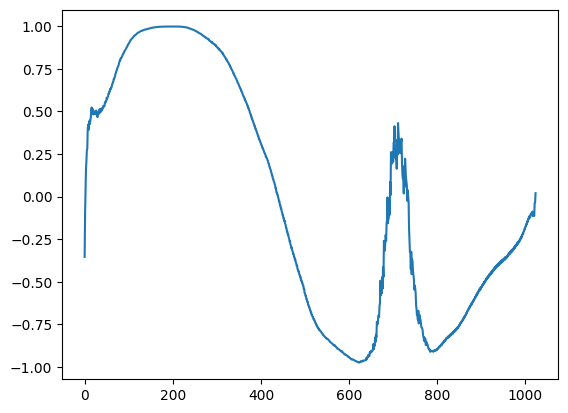

In [15]:
# take a look at a result using a random latent vector as input

random_input = torch.randn(100).to(device)
x = gen_sine(random_input.unsqueeze(1).unsqueeze(0))
x = x.detach().cpu()

plt.plot(x.squeeze(0).squeeze(0))

In [16]:
# save the weights of the models/generators
torch.save(gen_sine.state_dict(), save_dir + 'Model Weights/sine_generator_weights.pkl')
torch.save(gen_gaussian.state_dict(), save_dir + 'Model Weights/gaussian_generator_weights.pkl')